In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time

import category_encoders as ce
import lightgbm as lgb
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric
#from messaging import send_message

pd.set_option('display.max_columns', None)

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
N_REPEATS = 3
DATASET_VERSION = "08"

In [4]:
OOF_PATH = Path(f"../data/oof/lgbm-dart-bce-dsv{DATASET_VERSION}")
SUB_PATH = Path(f"../data/subs/lgbm-dart-bce-dsv{DATASET_VERSION}")
ART_PATH = Path(f"../artifacts/lgbm-dart-bce-dsv{DATASET_VERSION}")

if not OOF_PATH.exists():
    OOF_PATH.mkdir(parents=True, exist_ok=True)
if not SUB_PATH.exists():
    SUB_PATH.mkdir(parents=True, exist_ok=True)
if not ART_PATH.exists():
    ART_PATH.mkdir(parents=True, exist_ok=True)

***
## load and prepare data

In [5]:
train = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [6]:
input_feats = train.columns.tolist()
len(input_feats)

949

In [7]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
del train_labels
gc.collect()

72

***
## model training

train with repeated cross validation

In [8]:
model_params = {
    'boosting': 'dart',
    'objective': 'binary',
    'metric': 'None',
    'num_iterations': 4350,
    'num_leaves': 15,
    'learning_rate': 0.05,
    'max_bin': 63,
    'bin_construct_sample_cnt': 100000000,
    'bagging_freq': 1,
    'bagging_fraction': 1.0,
    'feature_fraction': 0.15,
    'lambda_l1': 5.996099571922015,
    'lambda_l2': 2.8900783163910697,
    'min_data_in_leaf': 1000,
    'path_smooth': 1.476306537276899,
    'min_gain_to_split': 0.313937968985787,
    'seed': 2112,
    'force_col_wise': True,
    'feature_pre_filter': True,
    'verbosity': -1,
    # dropout params
    'drop_rate': 0.1,
    'max_drop': 40,
    'skip_drop': 0.7,
}

In [9]:
def train_models(dataframe: pd.DataFrame, n_folds: int = 5,) -> tuple:
    
    models = list()
    
    # dataframe to store the oof predictions
    oof = dataframe[["target"]].copy()
    oof["pred"] = -1

    for fold in range(n_folds):
        
        print(f" training model {fold+1}/{n_folds} ".center(100, "#"))
        
        train_df = dataframe.query("fold != @fold").copy()
        valid_df = dataframe.query("fold == @fold").copy()
                
        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_feats],
            label=train_df.loc[:,"target"].values,
            free_raw_data=True,
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_feats],
            label=valid_df.loc[:,"target"].values,
            free_raw_data=True,
        )
                
        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
            callbacks=[lgb.log_evaluation(period=50),],
        )
        
        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()        
        
        oof.loc[valid_df.index,"pred"] = model.predict(valid_df.loc[:,input_feats])
        
        models.append(model)
        del train_df,valid_df,train_dset,valid_dset
        gc.collect()
    
    return models,oof

In [10]:
# implement repeated cross validation
sorted(glob("../data/processed/cv*.csv"))

['../data/processed/cv0.csv',
 '../data/processed/cv1.csv',
 '../data/processed/cv2.csv',
 '../data/processed/cv3.csv',
 '../data/processed/cv4.csv',
 '../data/processed/cv5.csv',
 '../data/processed/cv6.csv',
 '../data/processed/cv7.csv',
 '../data/processed/cv8.csv',
 '../data/processed/cv9.csv']

############################### repeated cross-validation step: 1/3 ################################


######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.750706	valid_0's recall_at4: 0.603509	valid_0's norm_gini: 0.897903


[100]	valid_0's amex_metric: 0.762529	valid_0's recall_at4: 0.620256	valid_0's norm_gini: 0.904803


[150]	valid_0's amex_metric: 0.769707	valid_0's recall_at4: 0.630733	valid_0's norm_gini: 0.90868


[200]	valid_0's amex_metric: 0.775255	valid_0's recall_at4: 0.638054	valid_0's norm_gini: 0.912455


[250]	valid_0's amex_metric: 0.778424	valid_0's recall_at4: 0.641925	valid_0's norm_gini: 0.914923


[300]	valid_0's amex_metric: 0.78197	valid_0's recall_at4: 0.647522	valid_0's norm_gini: 0.916419


[350]	valid_0's amex_metric: 0.783921	valid_0's recall_at4: 0.650341	valid_0's norm_gini: 0.917501


[400]	valid_0's amex_metric: 0.785104	valid_0's recall_at4: 0.651814	valid_0's norm_gini: 0.918395


[450]	valid_0's amex_metric: 0.785642	valid_0's recall_at4: 0.652276	valid_0's norm_gini: 0.919008


[500]	valid_0's amex_metric: 0.786401	valid_0's recall_at4: 0.653286	valid_0's norm_gini: 0.919516


[550]	valid_0's amex_metric: 0.786724	valid_0's recall_at4: 0.653539	valid_0's norm_gini: 0.919909


[600]	valid_0's amex_metric: 0.787117	valid_0's recall_at4: 0.654044	valid_0's norm_gini: 0.92019


[650]	valid_0's amex_metric: 0.787686	valid_0's recall_at4: 0.654885	valid_0's norm_gini: 0.920487


[700]	valid_0's amex_metric: 0.787751	valid_0's recall_at4: 0.654759	valid_0's norm_gini: 0.920744


[750]	valid_0's amex_metric: 0.788868	valid_0's recall_at4: 0.656779	valid_0's norm_gini: 0.920957


[800]	valid_0's amex_metric: 0.788993	valid_0's recall_at4: 0.656863	valid_0's norm_gini: 0.921123


[850]	valid_0's amex_metric: 0.788529	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.921332


[900]	valid_0's amex_metric: 0.789459	valid_0's recall_at4: 0.657368	valid_0's norm_gini: 0.921551


[950]	valid_0's amex_metric: 0.790118	valid_0's recall_at4: 0.658504	valid_0's norm_gini: 0.921732


[1000]	valid_0's amex_metric: 0.789922	valid_0's recall_at4: 0.657915	valid_0's norm_gini: 0.921929


[1050]	valid_0's amex_metric: 0.790593	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.922093


[1100]	valid_0's amex_metric: 0.790368	valid_0's recall_at4: 0.658504	valid_0's norm_gini: 0.922233


[1150]	valid_0's amex_metric: 0.790868	valid_0's recall_at4: 0.659387	valid_0's norm_gini: 0.922348


[1200]	valid_0's amex_metric: 0.790581	valid_0's recall_at4: 0.658756	valid_0's norm_gini: 0.922406


[1250]	valid_0's amex_metric: 0.791102	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.922523


[1300]	valid_0's amex_metric: 0.790961	valid_0's recall_at4: 0.659345	valid_0's norm_gini: 0.922577


[1350]	valid_0's amex_metric: 0.791325	valid_0's recall_at4: 0.660019	valid_0's norm_gini: 0.922631


[1400]	valid_0's amex_metric: 0.791732	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.922688


[1450]	valid_0's amex_metric: 0.791588	valid_0's recall_at4: 0.660439	valid_0's norm_gini: 0.922736


[1500]	valid_0's amex_metric: 0.79193	valid_0's recall_at4: 0.66107	valid_0's norm_gini: 0.922789


[1550]	valid_0's amex_metric: 0.791899	valid_0's recall_at4: 0.660944	valid_0's norm_gini: 0.922854


[1600]	valid_0's amex_metric: 0.792205	valid_0's recall_at4: 0.661491	valid_0's norm_gini: 0.922918


[1650]	valid_0's amex_metric: 0.792359	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.922974


[1700]	valid_0's amex_metric: 0.792462	valid_0's recall_at4: 0.661912	valid_0's norm_gini: 0.923012


[1750]	valid_0's amex_metric: 0.79233	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.923042


[1800]	valid_0's amex_metric: 0.792355	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.923092


[1850]	valid_0's amex_metric: 0.792641	valid_0's recall_at4: 0.662164	valid_0's norm_gini: 0.923118


[1900]	valid_0's amex_metric: 0.792699	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.923149


[1950]	valid_0's amex_metric: 0.79283	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.923201


[2000]	valid_0's amex_metric: 0.793146	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.923203


[2050]	valid_0's amex_metric: 0.79313	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.923212


[2100]	valid_0's amex_metric: 0.793297	valid_0's recall_at4: 0.663343	valid_0's norm_gini: 0.923251


[2150]	valid_0's amex_metric: 0.793816	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.923279


[2200]	valid_0's amex_metric: 0.793701	valid_0's recall_at4: 0.6641	valid_0's norm_gini: 0.923301


[2250]	valid_0's amex_metric: 0.793542	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.923321


[2300]	valid_0's amex_metric: 0.793575	valid_0's recall_at4: 0.663805	valid_0's norm_gini: 0.923344


[2350]	valid_0's amex_metric: 0.793772	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.92336


[2400]	valid_0's amex_metric: 0.793585	valid_0's recall_at4: 0.663805	valid_0's norm_gini: 0.923364


[2450]	valid_0's amex_metric: 0.793687	valid_0's recall_at4: 0.664016	valid_0's norm_gini: 0.923359


[2500]	valid_0's amex_metric: 0.793325	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.92335


[2550]	valid_0's amex_metric: 0.793474	valid_0's recall_at4: 0.663595	valid_0's norm_gini: 0.923352


[2600]	valid_0's amex_metric: 0.794025	valid_0's recall_at4: 0.664689	valid_0's norm_gini: 0.923361


[2650]	valid_0's amex_metric: 0.793736	valid_0's recall_at4: 0.6641	valid_0's norm_gini: 0.923371


[2700]	valid_0's amex_metric: 0.793903	valid_0's recall_at4: 0.664437	valid_0's norm_gini: 0.923369


[2750]	valid_0's amex_metric: 0.794299	valid_0's recall_at4: 0.665236	valid_0's norm_gini: 0.923363


[2800]	valid_0's amex_metric: 0.79453	valid_0's recall_at4: 0.665699	valid_0's norm_gini: 0.923361


[2850]	valid_0's amex_metric: 0.793898	valid_0's recall_at4: 0.664437	valid_0's norm_gini: 0.923359


[2900]	valid_0's amex_metric: 0.794166	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.923348


[2950]	valid_0's amex_metric: 0.794024	valid_0's recall_at4: 0.664689	valid_0's norm_gini: 0.923359


[3000]	valid_0's amex_metric: 0.793927	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.923375


[3050]	valid_0's amex_metric: 0.794315	valid_0's recall_at4: 0.665236	valid_0's norm_gini: 0.923393


[3100]	valid_0's amex_metric: 0.794246	valid_0's recall_at4: 0.66511	valid_0's norm_gini: 0.923382


[3150]	valid_0's amex_metric: 0.794205	valid_0's recall_at4: 0.665026	valid_0's norm_gini: 0.923384


[3200]	valid_0's amex_metric: 0.794017	valid_0's recall_at4: 0.664647	valid_0's norm_gini: 0.923387


[3250]	valid_0's amex_metric: 0.793665	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.923398


[3300]	valid_0's amex_metric: 0.793488	valid_0's recall_at4: 0.663595	valid_0's norm_gini: 0.923381


[3350]	valid_0's amex_metric: 0.793696	valid_0's recall_at4: 0.664016	valid_0's norm_gini: 0.923377


[3400]	valid_0's amex_metric: 0.794183	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.923383


[3450]	valid_0's amex_metric: 0.794167	valid_0's recall_at4: 0.664941	valid_0's norm_gini: 0.923392


[3500]	valid_0's amex_metric: 0.794134	valid_0's recall_at4: 0.664857	valid_0's norm_gini: 0.923411


[3550]	valid_0's amex_metric: 0.793813	valid_0's recall_at4: 0.664226	valid_0's norm_gini: 0.9234


[3600]	valid_0's amex_metric: 0.793965	valid_0's recall_at4: 0.664521	valid_0's norm_gini: 0.923409


[3650]	valid_0's amex_metric: 0.793363	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.923426


[3700]	valid_0's amex_metric: 0.793705	valid_0's recall_at4: 0.663974	valid_0's norm_gini: 0.923437


[3750]	valid_0's amex_metric: 0.793898	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.923443


[3800]	valid_0's amex_metric: 0.793895	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.923437


[3850]	valid_0's amex_metric: 0.793895	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.923437


[3900]	valid_0's amex_metric: 0.794122	valid_0's recall_at4: 0.664815	valid_0's norm_gini: 0.923429


[3950]	valid_0's amex_metric: 0.794017	valid_0's recall_at4: 0.664605	valid_0's norm_gini: 0.92343


[4000]	valid_0's amex_metric: 0.793974	valid_0's recall_at4: 0.664521	valid_0's norm_gini: 0.923427


[4050]	valid_0's amex_metric: 0.79408	valid_0's recall_at4: 0.664731	valid_0's norm_gini: 0.923429


[4100]	valid_0's amex_metric: 0.793525	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.923413


[4150]	valid_0's amex_metric: 0.793802	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.923419


[4200]	valid_0's amex_metric: 0.793567	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.923414


[4250]	valid_0's amex_metric: 0.79424	valid_0's recall_at4: 0.665068	valid_0's norm_gini: 0.923413


[4300]	valid_0's amex_metric: 0.793865	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.923377


[4350]	valid_0's amex_metric: 0.793476	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.9234


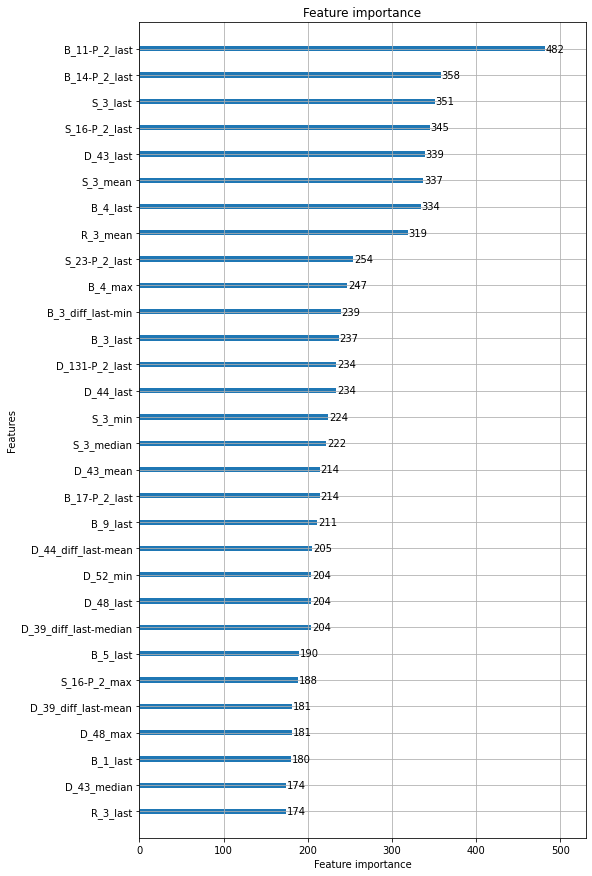

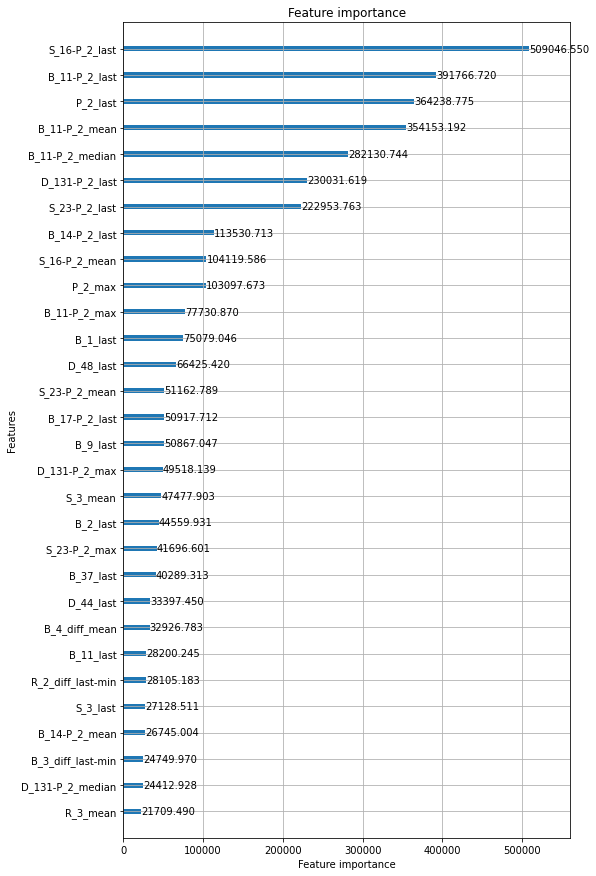

######################################## training model 2/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.74807	valid_0's recall_at4: 0.599259	valid_0's norm_gini: 0.89688


[100]	valid_0's amex_metric: 0.757571	valid_0's recall_at4: 0.61184	valid_0's norm_gini: 0.903301


[150]	valid_0's amex_metric: 0.763378	valid_0's recall_at4: 0.619498	valid_0's norm_gini: 0.907257


[200]	valid_0's amex_metric: 0.770548	valid_0's recall_at4: 0.630102	valid_0's norm_gini: 0.910994


[250]	valid_0's amex_metric: 0.775371	valid_0's recall_at4: 0.637255	valid_0's norm_gini: 0.913487


[300]	valid_0's amex_metric: 0.77709	valid_0's recall_at4: 0.639106	valid_0's norm_gini: 0.915074


[350]	valid_0's amex_metric: 0.779234	valid_0's recall_at4: 0.642346	valid_0's norm_gini: 0.916122


[400]	valid_0's amex_metric: 0.781881	valid_0's recall_at4: 0.64668	valid_0's norm_gini: 0.917082


[450]	valid_0's amex_metric: 0.783384	valid_0's recall_at4: 0.648994	valid_0's norm_gini: 0.917773


[500]	valid_0's amex_metric: 0.7842	valid_0's recall_at4: 0.650088	valid_0's norm_gini: 0.918311


[550]	valid_0's amex_metric: 0.784573	valid_0's recall_at4: 0.650383	valid_0's norm_gini: 0.918763


[600]	valid_0's amex_metric: 0.784433	valid_0's recall_at4: 0.649836	valid_0's norm_gini: 0.919031


[650]	valid_0's amex_metric: 0.78583	valid_0's recall_at4: 0.652318	valid_0's norm_gini: 0.919342


[700]	valid_0's amex_metric: 0.785874	valid_0's recall_at4: 0.65215	valid_0's norm_gini: 0.919599


[750]	valid_0's amex_metric: 0.786178	valid_0's recall_at4: 0.652529	valid_0's norm_gini: 0.919827


[800]	valid_0's amex_metric: 0.786177	valid_0's recall_at4: 0.65236	valid_0's norm_gini: 0.919993


[850]	valid_0's amex_metric: 0.787657	valid_0's recall_at4: 0.655053	valid_0's norm_gini: 0.92026


[900]	valid_0's amex_metric: 0.787907	valid_0's recall_at4: 0.65539	valid_0's norm_gini: 0.920424


[950]	valid_0's amex_metric: 0.788113	valid_0's recall_at4: 0.655558	valid_0's norm_gini: 0.920668


[1000]	valid_0's amex_metric: 0.788299	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.920872


[1050]	valid_0's amex_metric: 0.788411	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.921095


[1100]	valid_0's amex_metric: 0.789809	valid_0's recall_at4: 0.658293	valid_0's norm_gini: 0.921325


[1150]	valid_0's amex_metric: 0.789944	valid_0's recall_at4: 0.65842	valid_0's norm_gini: 0.921469


[1200]	valid_0's amex_metric: 0.790055	valid_0's recall_at4: 0.658504	valid_0's norm_gini: 0.921605


[1250]	valid_0's amex_metric: 0.790386	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.921679


[1300]	valid_0's amex_metric: 0.790799	valid_0's recall_at4: 0.65985	valid_0's norm_gini: 0.921749


[1350]	valid_0's amex_metric: 0.790457	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.921821


[1400]	valid_0's amex_metric: 0.790535	valid_0's recall_at4: 0.659177	valid_0's norm_gini: 0.921893


[1450]	valid_0's amex_metric: 0.790883	valid_0's recall_at4: 0.659808	valid_0's norm_gini: 0.921958


[1500]	valid_0's amex_metric: 0.790755	valid_0's recall_at4: 0.659472	valid_0's norm_gini: 0.922039


[1550]	valid_0's amex_metric: 0.791158	valid_0's recall_at4: 0.660187	valid_0's norm_gini: 0.922129


[1600]	valid_0's amex_metric: 0.791215	valid_0's recall_at4: 0.660229	valid_0's norm_gini: 0.9222


[1650]	valid_0's amex_metric: 0.791056	valid_0's recall_at4: 0.65985	valid_0's norm_gini: 0.922261


[1700]	valid_0's amex_metric: 0.791338	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.922321


[1750]	valid_0's amex_metric: 0.791157	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.92238


[1800]	valid_0's amex_metric: 0.790681	valid_0's recall_at4: 0.658967	valid_0's norm_gini: 0.922396


[1850]	valid_0's amex_metric: 0.791165	valid_0's recall_at4: 0.659892	valid_0's norm_gini: 0.922439


[1900]	valid_0's amex_metric: 0.790967	valid_0's recall_at4: 0.659472	valid_0's norm_gini: 0.922462


[1950]	valid_0's amex_metric: 0.790847	valid_0's recall_at4: 0.659177	valid_0's norm_gini: 0.922517


[2000]	valid_0's amex_metric: 0.791344	valid_0's recall_at4: 0.660145	valid_0's norm_gini: 0.922543


[2050]	valid_0's amex_metric: 0.791784	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.922581


[2100]	valid_0's amex_metric: 0.792187	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.92263


[2150]	valid_0's amex_metric: 0.791926	valid_0's recall_at4: 0.661197	valid_0's norm_gini: 0.922655


[2200]	valid_0's amex_metric: 0.792042	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.922677


[2250]	valid_0's amex_metric: 0.792499	valid_0's recall_at4: 0.662291	valid_0's norm_gini: 0.922707


[2300]	valid_0's amex_metric: 0.792547	valid_0's recall_at4: 0.662375	valid_0's norm_gini: 0.922718


[2350]	valid_0's amex_metric: 0.792477	valid_0's recall_at4: 0.662207	valid_0's norm_gini: 0.922747


[2400]	valid_0's amex_metric: 0.792412	valid_0's recall_at4: 0.662038	valid_0's norm_gini: 0.922786


[2450]	valid_0's amex_metric: 0.792395	valid_0's recall_at4: 0.661996	valid_0's norm_gini: 0.922795


[2500]	valid_0's amex_metric: 0.792265	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.922828


[2550]	valid_0's amex_metric: 0.792435	valid_0's recall_at4: 0.662038	valid_0's norm_gini: 0.922833


[2600]	valid_0's amex_metric: 0.792172	valid_0's recall_at4: 0.661491	valid_0's norm_gini: 0.922853


[2650]	valid_0's amex_metric: 0.792356	valid_0's recall_at4: 0.661828	valid_0's norm_gini: 0.922883


[2700]	valid_0's amex_metric: 0.792404	valid_0's recall_at4: 0.661912	valid_0's norm_gini: 0.922897


[2750]	valid_0's amex_metric: 0.792684	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.92291


[2800]	valid_0's amex_metric: 0.792783	valid_0's recall_at4: 0.662669	valid_0's norm_gini: 0.922897


[2850]	valid_0's amex_metric: 0.792453	valid_0's recall_at4: 0.661996	valid_0's norm_gini: 0.92291


[2900]	valid_0's amex_metric: 0.792829	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.922946


[2950]	valid_0's amex_metric: 0.792692	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.922926


[3000]	valid_0's amex_metric: 0.79257	valid_0's recall_at4: 0.662207	valid_0's norm_gini: 0.922933


[3050]	valid_0's amex_metric: 0.792328	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.922954


[3100]	valid_0's amex_metric: 0.792324	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.922946


[3150]	valid_0's amex_metric: 0.792273	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.922929


[3200]	valid_0's amex_metric: 0.792278	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.922939


[3250]	valid_0's amex_metric: 0.79191	valid_0's recall_at4: 0.660902	valid_0's norm_gini: 0.922917


[3300]	valid_0's amex_metric: 0.792301	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.922901


[3350]	valid_0's amex_metric: 0.792472	valid_0's recall_at4: 0.662038	valid_0's norm_gini: 0.922906


[3400]	valid_0's amex_metric: 0.792477	valid_0's recall_at4: 0.662038	valid_0's norm_gini: 0.922916


[3450]	valid_0's amex_metric: 0.792685	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.922912


[3500]	valid_0's amex_metric: 0.792427	valid_0's recall_at4: 0.661912	valid_0's norm_gini: 0.922942


[3550]	valid_0's amex_metric: 0.792494	valid_0's recall_at4: 0.662038	valid_0's norm_gini: 0.92295


[3600]	valid_0's amex_metric: 0.793183	valid_0's recall_at4: 0.663427	valid_0's norm_gini: 0.922939


[3650]	valid_0's amex_metric: 0.793259	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.922964


[3700]	valid_0's amex_metric: 0.793156	valid_0's recall_at4: 0.663343	valid_0's norm_gini: 0.92297


[3750]	valid_0's amex_metric: 0.793139	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.922978


[3800]	valid_0's amex_metric: 0.793575	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.923008


[3850]	valid_0's amex_metric: 0.793446	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.923002


[3900]	valid_0's amex_metric: 0.793311	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.922984


[3950]	valid_0's amex_metric: 0.79319	valid_0's recall_at4: 0.663385	valid_0's norm_gini: 0.922995


[4000]	valid_0's amex_metric: 0.793503	valid_0's recall_at4: 0.664016	valid_0's norm_gini: 0.92299


[4050]	valid_0's amex_metric: 0.793145	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.92299


[4100]	valid_0's amex_metric: 0.792873	valid_0's recall_at4: 0.662754	valid_0's norm_gini: 0.922992


[4150]	valid_0's amex_metric: 0.793255	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.923


[4200]	valid_0's amex_metric: 0.79313	valid_0's recall_at4: 0.663258	valid_0's norm_gini: 0.923003


[4250]	valid_0's amex_metric: 0.792879	valid_0's recall_at4: 0.662754	valid_0's norm_gini: 0.923004


[4300]	valid_0's amex_metric: 0.793208	valid_0's recall_at4: 0.663427	valid_0's norm_gini: 0.922989


[4350]	valid_0's amex_metric: 0.793398	valid_0's recall_at4: 0.663805	valid_0's norm_gini: 0.92299


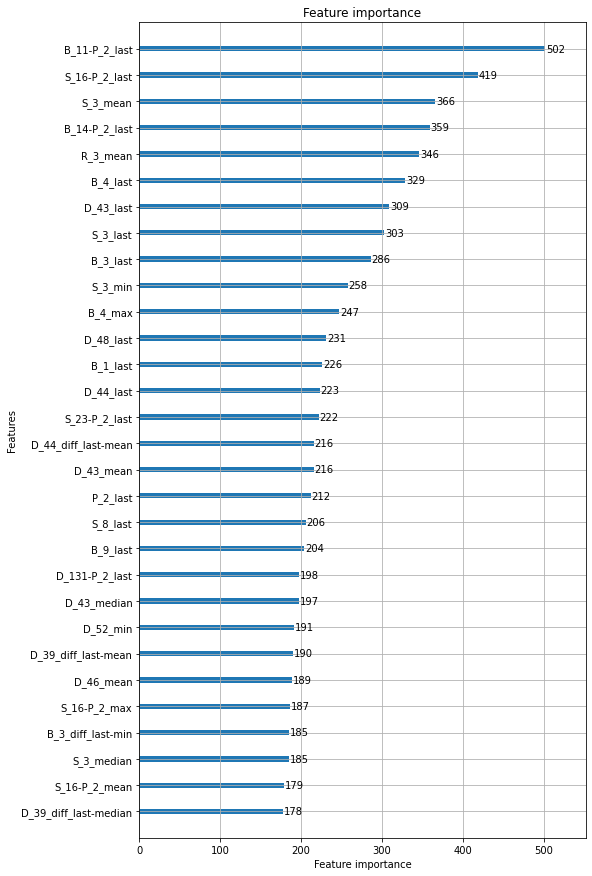

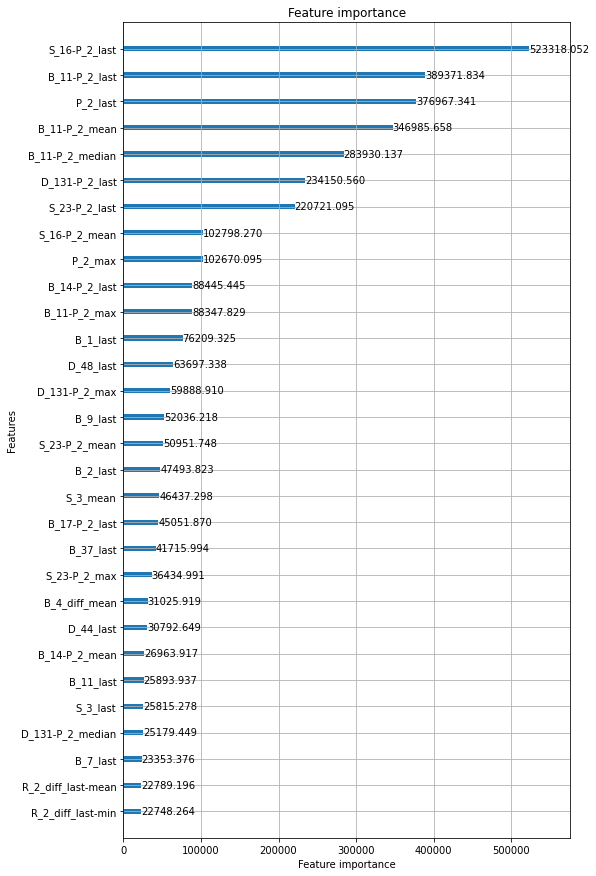

######################################## training model 3/5 ########################################


[50]	valid_0's amex_metric: 0.742242	valid_0's recall_at4: 0.588277	valid_0's norm_gini: 0.896207


[100]	valid_0's amex_metric: 0.752919	valid_0's recall_at4: 0.60271	valid_0's norm_gini: 0.903129


[150]	valid_0's amex_metric: 0.760544	valid_0's recall_at4: 0.614449	valid_0's norm_gini: 0.906638


[200]	valid_0's amex_metric: 0.766617	valid_0's recall_at4: 0.622907	valid_0's norm_gini: 0.910327


[250]	valid_0's amex_metric: 0.770092	valid_0's recall_at4: 0.627493	valid_0's norm_gini: 0.912692


[300]	valid_0's amex_metric: 0.773331	valid_0's recall_at4: 0.6325	valid_0's norm_gini: 0.914162


[350]	valid_0's amex_metric: 0.775047	valid_0's recall_at4: 0.634857	valid_0's norm_gini: 0.915237


[400]	valid_0's amex_metric: 0.776515	valid_0's recall_at4: 0.63696	valid_0's norm_gini: 0.916069


[450]	valid_0's amex_metric: 0.777571	valid_0's recall_at4: 0.638433	valid_0's norm_gini: 0.916709


[500]	valid_0's amex_metric: 0.77804	valid_0's recall_at4: 0.638854	valid_0's norm_gini: 0.917227


[550]	valid_0's amex_metric: 0.779233	valid_0's recall_at4: 0.640789	valid_0's norm_gini: 0.917676


[600]	valid_0's amex_metric: 0.779582	valid_0's recall_at4: 0.641252	valid_0's norm_gini: 0.917912


[650]	valid_0's amex_metric: 0.780991	valid_0's recall_at4: 0.643777	valid_0's norm_gini: 0.918205


[700]	valid_0's amex_metric: 0.781675	valid_0's recall_at4: 0.644829	valid_0's norm_gini: 0.918522


[750]	valid_0's amex_metric: 0.782264	valid_0's recall_at4: 0.645797	valid_0's norm_gini: 0.918731


[800]	valid_0's amex_metric: 0.782374	valid_0's recall_at4: 0.645839	valid_0's norm_gini: 0.91891


[850]	valid_0's amex_metric: 0.783093	valid_0's recall_at4: 0.647017	valid_0's norm_gini: 0.91917


[900]	valid_0's amex_metric: 0.783408	valid_0's recall_at4: 0.647522	valid_0's norm_gini: 0.919294


[950]	valid_0's amex_metric: 0.783383	valid_0's recall_at4: 0.647311	valid_0's norm_gini: 0.919455


[1000]	valid_0's amex_metric: 0.783969	valid_0's recall_at4: 0.648279	valid_0's norm_gini: 0.919659


[1050]	valid_0's amex_metric: 0.784843	valid_0's recall_at4: 0.649836	valid_0's norm_gini: 0.919849


[1100]	valid_0's amex_metric: 0.785055	valid_0's recall_at4: 0.650046	valid_0's norm_gini: 0.920063


[1150]	valid_0's amex_metric: 0.785579	valid_0's recall_at4: 0.650972	valid_0's norm_gini: 0.920187


[1200]	valid_0's amex_metric: 0.786199	valid_0's recall_at4: 0.652108	valid_0's norm_gini: 0.920291


[1250]	valid_0's amex_metric: 0.786573	valid_0's recall_at4: 0.652781	valid_0's norm_gini: 0.920364


[1300]	valid_0's amex_metric: 0.786626	valid_0's recall_at4: 0.652823	valid_0's norm_gini: 0.920429


[1350]	valid_0's amex_metric: 0.786628	valid_0's recall_at4: 0.652781	valid_0's norm_gini: 0.920475


[1400]	valid_0's amex_metric: 0.786852	valid_0's recall_at4: 0.653118	valid_0's norm_gini: 0.920586


[1450]	valid_0's amex_metric: 0.787059	valid_0's recall_at4: 0.653455	valid_0's norm_gini: 0.920664


[1500]	valid_0's amex_metric: 0.787032	valid_0's recall_at4: 0.653328	valid_0's norm_gini: 0.920735


[1550]	valid_0's amex_metric: 0.787026	valid_0's recall_at4: 0.653244	valid_0's norm_gini: 0.920808


[1600]	valid_0's amex_metric: 0.787243	valid_0's recall_at4: 0.653623	valid_0's norm_gini: 0.920863


[1650]	valid_0's amex_metric: 0.787181	valid_0's recall_at4: 0.653455	valid_0's norm_gini: 0.920908


[1700]	valid_0's amex_metric: 0.787115	valid_0's recall_at4: 0.653286	valid_0's norm_gini: 0.920944


[1750]	valid_0's amex_metric: 0.78714	valid_0's recall_at4: 0.653286	valid_0's norm_gini: 0.920993


[1800]	valid_0's amex_metric: 0.787533	valid_0's recall_at4: 0.654044	valid_0's norm_gini: 0.921022


[1850]	valid_0's amex_metric: 0.787203	valid_0's recall_at4: 0.653328	valid_0's norm_gini: 0.921078


[1900]	valid_0's amex_metric: 0.78716	valid_0's recall_at4: 0.653202	valid_0's norm_gini: 0.921117


[1950]	valid_0's amex_metric: 0.78748	valid_0's recall_at4: 0.653791	valid_0's norm_gini: 0.921168


[2000]	valid_0's amex_metric: 0.787273	valid_0's recall_at4: 0.65337	valid_0's norm_gini: 0.921175


[2050]	valid_0's amex_metric: 0.787227	valid_0's recall_at4: 0.653244	valid_0's norm_gini: 0.921209


[2100]	valid_0's amex_metric: 0.786876	valid_0's recall_at4: 0.652487	valid_0's norm_gini: 0.921265


[2150]	valid_0's amex_metric: 0.786971	valid_0's recall_at4: 0.652655	valid_0's norm_gini: 0.921287


[2200]	valid_0's amex_metric: 0.787196	valid_0's recall_at4: 0.653076	valid_0's norm_gini: 0.921316


[2250]	valid_0's amex_metric: 0.78727	valid_0's recall_at4: 0.653202	valid_0's norm_gini: 0.921337


[2300]	valid_0's amex_metric: 0.786828	valid_0's recall_at4: 0.652276	valid_0's norm_gini: 0.921379


[2350]	valid_0's amex_metric: 0.787053	valid_0's recall_at4: 0.652697	valid_0's norm_gini: 0.92141


[2400]	valid_0's amex_metric: 0.787325	valid_0's recall_at4: 0.653202	valid_0's norm_gini: 0.921448


[2450]	valid_0's amex_metric: 0.787475	valid_0's recall_at4: 0.653455	valid_0's norm_gini: 0.921496


[2500]	valid_0's amex_metric: 0.787697	valid_0's recall_at4: 0.653875	valid_0's norm_gini: 0.921519


[2550]	valid_0's amex_metric: 0.787686	valid_0's recall_at4: 0.653833	valid_0's norm_gini: 0.921539


[2600]	valid_0's amex_metric: 0.787636	valid_0's recall_at4: 0.653707	valid_0's norm_gini: 0.921565


[2650]	valid_0's amex_metric: 0.787319	valid_0's recall_at4: 0.653076	valid_0's norm_gini: 0.921561


[2700]	valid_0's amex_metric: 0.787422	valid_0's recall_at4: 0.653286	valid_0's norm_gini: 0.921558


[2750]	valid_0's amex_metric: 0.787398	valid_0's recall_at4: 0.653244	valid_0's norm_gini: 0.921551


[2800]	valid_0's amex_metric: 0.787341	valid_0's recall_at4: 0.653118	valid_0's norm_gini: 0.921564


[2850]	valid_0's amex_metric: 0.787854	valid_0's recall_at4: 0.654128	valid_0's norm_gini: 0.921579


[2900]	valid_0's amex_metric: 0.788079	valid_0's recall_at4: 0.654549	valid_0's norm_gini: 0.92161


[2950]	valid_0's amex_metric: 0.788254	valid_0's recall_at4: 0.654885	valid_0's norm_gini: 0.921623


[3000]	valid_0's amex_metric: 0.787695	valid_0's recall_at4: 0.653749	valid_0's norm_gini: 0.921641


[3050]	valid_0's amex_metric: 0.78808	valid_0's recall_at4: 0.654506	valid_0's norm_gini: 0.921653


[3100]	valid_0's amex_metric: 0.787914	valid_0's recall_at4: 0.65417	valid_0's norm_gini: 0.921659


[3150]	valid_0's amex_metric: 0.788266	valid_0's recall_at4: 0.654885	valid_0's norm_gini: 0.921647


[3200]	valid_0's amex_metric: 0.78865	valid_0's recall_at4: 0.655685	valid_0's norm_gini: 0.921614


[3250]	valid_0's amex_metric: 0.788887	valid_0's recall_at4: 0.656147	valid_0's norm_gini: 0.921626


[3300]	valid_0's amex_metric: 0.789065	valid_0's recall_at4: 0.656484	valid_0's norm_gini: 0.921645


[3350]	valid_0's amex_metric: 0.788685	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.921643


[3400]	valid_0's amex_metric: 0.78874	valid_0's recall_at4: 0.655853	valid_0's norm_gini: 0.921627


[3450]	valid_0's amex_metric: 0.788914	valid_0's recall_at4: 0.65619	valid_0's norm_gini: 0.921638


[3500]	valid_0's amex_metric: 0.788833	valid_0's recall_at4: 0.656021	valid_0's norm_gini: 0.921644


[3550]	valid_0's amex_metric: 0.789175	valid_0's recall_at4: 0.656694	valid_0's norm_gini: 0.921657


[3600]	valid_0's amex_metric: 0.789119	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.921669


[3650]	valid_0's amex_metric: 0.78932	valid_0's recall_at4: 0.656947	valid_0's norm_gini: 0.921693


[3700]	valid_0's amex_metric: 0.789119	valid_0's recall_at4: 0.656526	valid_0's norm_gini: 0.921712


[3750]	valid_0's amex_metric: 0.788866	valid_0's recall_at4: 0.656021	valid_0's norm_gini: 0.921712


[3800]	valid_0's amex_metric: 0.788867	valid_0's recall_at4: 0.656021	valid_0's norm_gini: 0.921714


[3850]	valid_0's amex_metric: 0.788735	valid_0's recall_at4: 0.655769	valid_0's norm_gini: 0.921701


[3900]	valid_0's amex_metric: 0.788862	valid_0's recall_at4: 0.656021	valid_0's norm_gini: 0.921703


[3950]	valid_0's amex_metric: 0.788844	valid_0's recall_at4: 0.655979	valid_0's norm_gini: 0.92171


[4000]	valid_0's amex_metric: 0.788757	valid_0's recall_at4: 0.655811	valid_0's norm_gini: 0.921703


[4050]	valid_0's amex_metric: 0.788641	valid_0's recall_at4: 0.655558	valid_0's norm_gini: 0.921725


[4100]	valid_0's amex_metric: 0.788929	valid_0's recall_at4: 0.656147	valid_0's norm_gini: 0.921711


[4150]	valid_0's amex_metric: 0.78912	valid_0's recall_at4: 0.656526	valid_0's norm_gini: 0.921714


[4200]	valid_0's amex_metric: 0.788724	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.92172


[4250]	valid_0's amex_metric: 0.78905	valid_0's recall_at4: 0.6564	valid_0's norm_gini: 0.921701


[4300]	valid_0's amex_metric: 0.78926	valid_0's recall_at4: 0.656821	valid_0's norm_gini: 0.921699


[4350]	valid_0's amex_metric: 0.789511	valid_0's recall_at4: 0.657326	valid_0's norm_gini: 0.921697


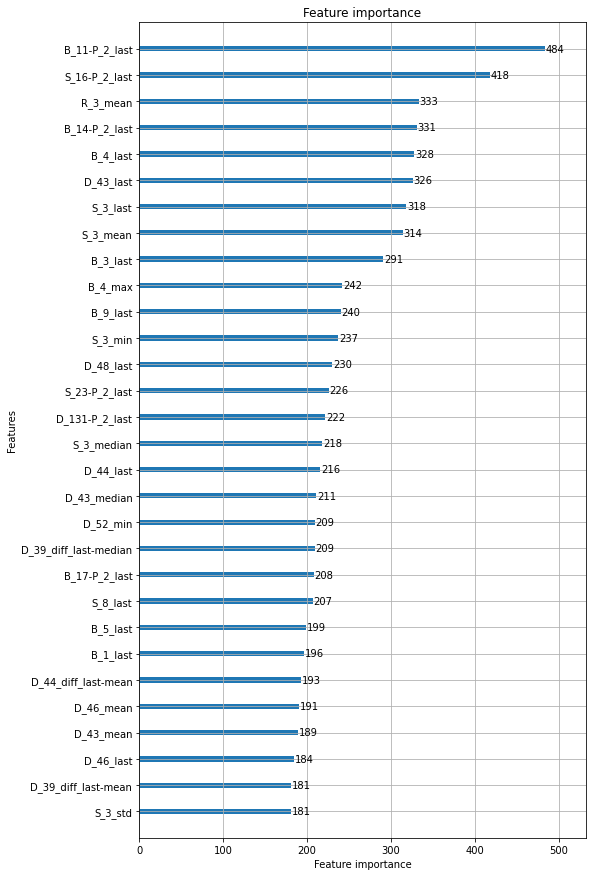

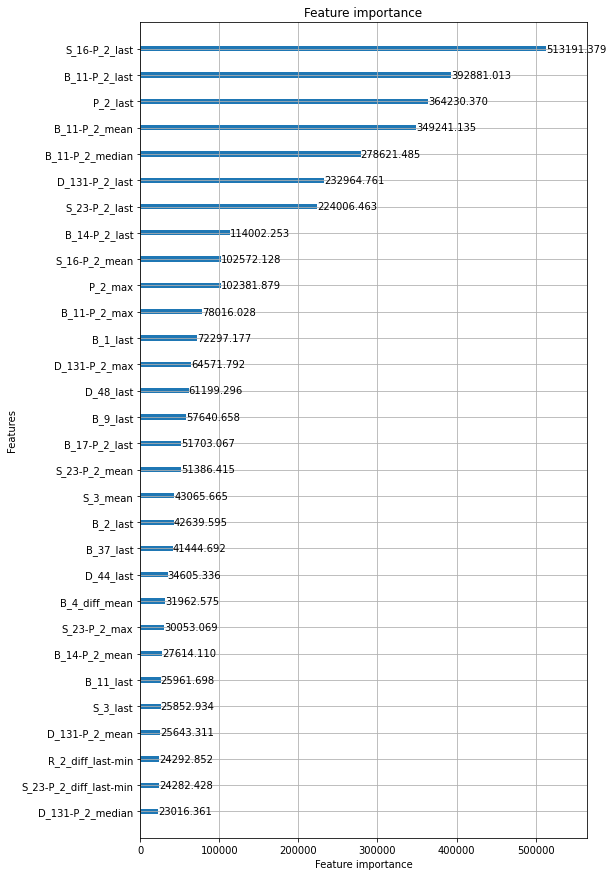

######################################## training model 4/5 ########################################


[50]	valid_0's amex_metric: 0.741649	valid_0's recall_at4: 0.587587	valid_0's norm_gini: 0.895712


[100]	valid_0's amex_metric: 0.754702	valid_0's recall_at4: 0.607027	valid_0's norm_gini: 0.902377


[150]	valid_0's amex_metric: 0.759181	valid_0's recall_at4: 0.612329	valid_0's norm_gini: 0.906033


[200]	valid_0's amex_metric: 0.765929	valid_0's recall_at4: 0.622091	valid_0's norm_gini: 0.909766


[250]	valid_0's amex_metric: 0.769651	valid_0's recall_at4: 0.627141	valid_0's norm_gini: 0.912161


[300]	valid_0's amex_metric: 0.771779	valid_0's recall_at4: 0.629792	valid_0's norm_gini: 0.913766


[350]	valid_0's amex_metric: 0.773984	valid_0's recall_at4: 0.633032	valid_0's norm_gini: 0.914936


[400]	valid_0's amex_metric: 0.774849	valid_0's recall_at4: 0.633873	valid_0's norm_gini: 0.915824


[450]	valid_0's amex_metric: 0.775857	valid_0's recall_at4: 0.635178	valid_0's norm_gini: 0.916537


[500]	valid_0's amex_metric: 0.776916	valid_0's recall_at4: 0.636735	valid_0's norm_gini: 0.917097


[550]	valid_0's amex_metric: 0.777634	valid_0's recall_at4: 0.637703	valid_0's norm_gini: 0.917566


[600]	valid_0's amex_metric: 0.778639	valid_0's recall_at4: 0.639428	valid_0's norm_gini: 0.91785


[650]	valid_0's amex_metric: 0.779443	valid_0's recall_at4: 0.64069	valid_0's norm_gini: 0.918195


[700]	valid_0's amex_metric: 0.779809	valid_0's recall_at4: 0.641111	valid_0's norm_gini: 0.918507


[750]	valid_0's amex_metric: 0.780263	valid_0's recall_at4: 0.641784	valid_0's norm_gini: 0.918741


[800]	valid_0's amex_metric: 0.780213	valid_0's recall_at4: 0.64149	valid_0's norm_gini: 0.918936


[850]	valid_0's amex_metric: 0.7804	valid_0's recall_at4: 0.641574	valid_0's norm_gini: 0.919226


[900]	valid_0's amex_metric: 0.780712	valid_0's recall_at4: 0.642037	valid_0's norm_gini: 0.919388


[950]	valid_0's amex_metric: 0.781519	valid_0's recall_at4: 0.643425	valid_0's norm_gini: 0.919613


[1000]	valid_0's amex_metric: 0.782358	valid_0's recall_at4: 0.644898	valid_0's norm_gini: 0.919818


[1050]	valid_0's amex_metric: 0.782869	valid_0's recall_at4: 0.645697	valid_0's norm_gini: 0.92004


[1100]	valid_0's amex_metric: 0.783428	valid_0's recall_at4: 0.646623	valid_0's norm_gini: 0.920233


[1150]	valid_0's amex_metric: 0.783774	valid_0's recall_at4: 0.64717	valid_0's norm_gini: 0.920378


[1200]	valid_0's amex_metric: 0.783699	valid_0's recall_at4: 0.646876	valid_0's norm_gini: 0.920522


[1250]	valid_0's amex_metric: 0.783594	valid_0's recall_at4: 0.646581	valid_0's norm_gini: 0.920606


[1300]	valid_0's amex_metric: 0.78352	valid_0's recall_at4: 0.646371	valid_0's norm_gini: 0.920668


[1350]	valid_0's amex_metric: 0.784101	valid_0's recall_at4: 0.647465	valid_0's norm_gini: 0.920738


[1400]	valid_0's amex_metric: 0.783771	valid_0's recall_at4: 0.646707	valid_0's norm_gini: 0.920835


[1450]	valid_0's amex_metric: 0.784714	valid_0's recall_at4: 0.648475	valid_0's norm_gini: 0.920954


[1500]	valid_0's amex_metric: 0.78407	valid_0's recall_at4: 0.647128	valid_0's norm_gini: 0.921012


[1550]	valid_0's amex_metric: 0.784637	valid_0's recall_at4: 0.64818	valid_0's norm_gini: 0.921094


[1600]	valid_0's amex_metric: 0.784844	valid_0's recall_at4: 0.648517	valid_0's norm_gini: 0.921171


[1650]	valid_0's amex_metric: 0.785392	valid_0's recall_at4: 0.649569	valid_0's norm_gini: 0.921215


[1700]	valid_0's amex_metric: 0.785365	valid_0's recall_at4: 0.649485	valid_0's norm_gini: 0.921245


[1750]	valid_0's amex_metric: 0.785806	valid_0's recall_at4: 0.650284	valid_0's norm_gini: 0.921328


[1800]	valid_0's amex_metric: 0.785596	valid_0's recall_at4: 0.649779	valid_0's norm_gini: 0.921413


[1850]	valid_0's amex_metric: 0.786021	valid_0's recall_at4: 0.650579	valid_0's norm_gini: 0.921463


[1900]	valid_0's amex_metric: 0.785826	valid_0's recall_at4: 0.650158	valid_0's norm_gini: 0.921495


[1950]	valid_0's amex_metric: 0.786601	valid_0's recall_at4: 0.651673	valid_0's norm_gini: 0.921529


[2000]	valid_0's amex_metric: 0.78615	valid_0's recall_at4: 0.650747	valid_0's norm_gini: 0.921553


[2050]	valid_0's amex_metric: 0.786495	valid_0's recall_at4: 0.65142	valid_0's norm_gini: 0.921569


[2100]	valid_0's amex_metric: 0.78733	valid_0's recall_at4: 0.653061	valid_0's norm_gini: 0.921598


[2150]	valid_0's amex_metric: 0.786971	valid_0's recall_at4: 0.652304	valid_0's norm_gini: 0.921637


[2200]	valid_0's amex_metric: 0.787126	valid_0's recall_at4: 0.652598	valid_0's norm_gini: 0.921653


[2250]	valid_0's amex_metric: 0.787215	valid_0's recall_at4: 0.652767	valid_0's norm_gini: 0.921662


[2300]	valid_0's amex_metric: 0.78746	valid_0's recall_at4: 0.65323	valid_0's norm_gini: 0.921691


[2350]	valid_0's amex_metric: 0.78747	valid_0's recall_at4: 0.65323	valid_0's norm_gini: 0.92171


[2400]	valid_0's amex_metric: 0.787562	valid_0's recall_at4: 0.653398	valid_0's norm_gini: 0.921726


[2450]	valid_0's amex_metric: 0.78684	valid_0's recall_at4: 0.651925	valid_0's norm_gini: 0.921754


[2500]	valid_0's amex_metric: 0.787374	valid_0's recall_at4: 0.652977	valid_0's norm_gini: 0.921771


[2550]	valid_0's amex_metric: 0.787016	valid_0's recall_at4: 0.652262	valid_0's norm_gini: 0.92177


[2600]	valid_0's amex_metric: 0.786851	valid_0's recall_at4: 0.651925	valid_0's norm_gini: 0.921778


[2650]	valid_0's amex_metric: 0.78751	valid_0's recall_at4: 0.65323	valid_0's norm_gini: 0.92179


[2700]	valid_0's amex_metric: 0.787403	valid_0's recall_at4: 0.653019	valid_0's norm_gini: 0.921788


[2750]	valid_0's amex_metric: 0.787099	valid_0's recall_at4: 0.652388	valid_0's norm_gini: 0.92181


[2800]	valid_0's amex_metric: 0.787162	valid_0's recall_at4: 0.652514	valid_0's norm_gini: 0.92181


[2850]	valid_0's amex_metric: 0.787316	valid_0's recall_at4: 0.652809	valid_0's norm_gini: 0.921824


[2900]	valid_0's amex_metric: 0.787223	valid_0's recall_at4: 0.652598	valid_0's norm_gini: 0.921848


[2950]	valid_0's amex_metric: 0.787373	valid_0's recall_at4: 0.652893	valid_0's norm_gini: 0.921852


[3000]	valid_0's amex_metric: 0.787131	valid_0's recall_at4: 0.652388	valid_0's norm_gini: 0.921873


[3050]	valid_0's amex_metric: 0.787133	valid_0's recall_at4: 0.652388	valid_0's norm_gini: 0.921878


[3100]	valid_0's amex_metric: 0.787445	valid_0's recall_at4: 0.653019	valid_0's norm_gini: 0.921871


[3150]	valid_0's amex_metric: 0.786952	valid_0's recall_at4: 0.652009	valid_0's norm_gini: 0.921895


[3200]	valid_0's amex_metric: 0.787318	valid_0's recall_at4: 0.652725	valid_0's norm_gini: 0.921911


[3250]	valid_0's amex_metric: 0.787547	valid_0's recall_at4: 0.653187	valid_0's norm_gini: 0.921907


[3300]	valid_0's amex_metric: 0.787154	valid_0's recall_at4: 0.652388	valid_0's norm_gini: 0.92192


[3350]	valid_0's amex_metric: 0.787488	valid_0's recall_at4: 0.653061	valid_0's norm_gini: 0.921916


[3400]	valid_0's amex_metric: 0.787021	valid_0's recall_at4: 0.652135	valid_0's norm_gini: 0.921907


[3450]	valid_0's amex_metric: 0.787199	valid_0's recall_at4: 0.652472	valid_0's norm_gini: 0.921926


[3500]	valid_0's amex_metric: 0.787098	valid_0's recall_at4: 0.652262	valid_0's norm_gini: 0.921933


[3550]	valid_0's amex_metric: 0.787067	valid_0's recall_at4: 0.652178	valid_0's norm_gini: 0.921957


[3600]	valid_0's amex_metric: 0.786966	valid_0's recall_at4: 0.651967	valid_0's norm_gini: 0.921965


[3650]	valid_0's amex_metric: 0.787297	valid_0's recall_at4: 0.65264	valid_0's norm_gini: 0.921953


[3700]	valid_0's amex_metric: 0.787048	valid_0's recall_at4: 0.652135	valid_0's norm_gini: 0.92196


[3750]	valid_0's amex_metric: 0.78718	valid_0's recall_at4: 0.652388	valid_0's norm_gini: 0.921972


[3800]	valid_0's amex_metric: 0.786755	valid_0's recall_at4: 0.651546	valid_0's norm_gini: 0.921964


[3850]	valid_0's amex_metric: 0.786823	valid_0's recall_at4: 0.651715	valid_0's norm_gini: 0.92193


[3900]	valid_0's amex_metric: 0.787164	valid_0's recall_at4: 0.652388	valid_0's norm_gini: 0.92194


[3950]	valid_0's amex_metric: 0.787415	valid_0's recall_at4: 0.652893	valid_0's norm_gini: 0.921937


[4000]	valid_0's amex_metric: 0.787106	valid_0's recall_at4: 0.652262	valid_0's norm_gini: 0.921949


[4050]	valid_0's amex_metric: 0.787429	valid_0's recall_at4: 0.652893	valid_0's norm_gini: 0.921965


[4100]	valid_0's amex_metric: 0.787339	valid_0's recall_at4: 0.652725	valid_0's norm_gini: 0.921953


[4150]	valid_0's amex_metric: 0.787364	valid_0's recall_at4: 0.652767	valid_0's norm_gini: 0.921961


[4200]	valid_0's amex_metric: 0.787849	valid_0's recall_at4: 0.653735	valid_0's norm_gini: 0.921963


[4250]	valid_0's amex_metric: 0.787655	valid_0's recall_at4: 0.653356	valid_0's norm_gini: 0.921954


[4300]	valid_0's amex_metric: 0.787463	valid_0's recall_at4: 0.652977	valid_0's norm_gini: 0.921949


[4350]	valid_0's amex_metric: 0.788014	valid_0's recall_at4: 0.654071	valid_0's norm_gini: 0.921957


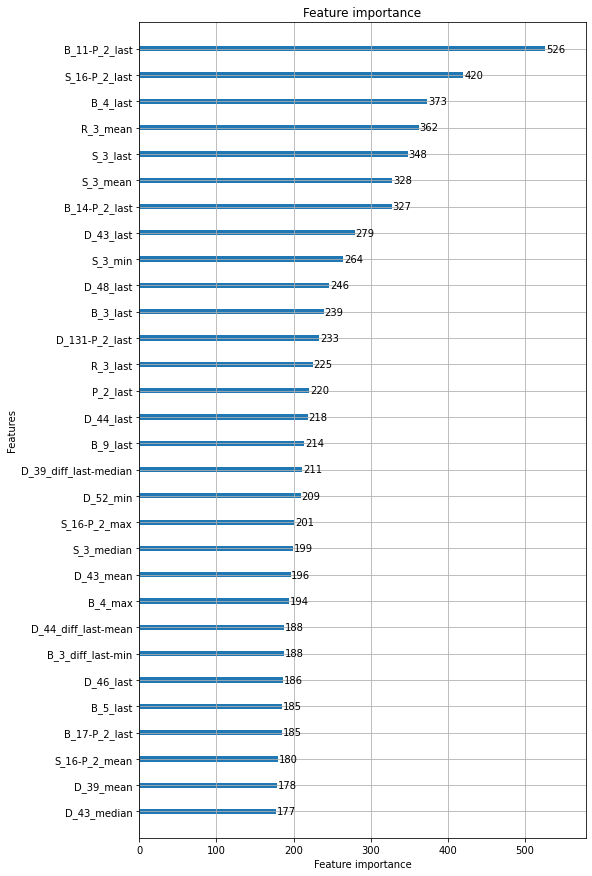

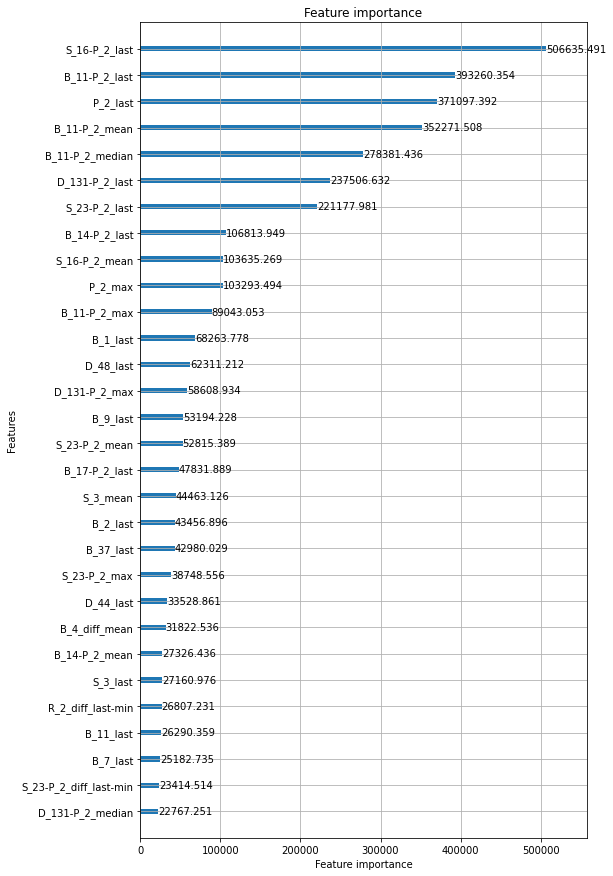

######################################## training model 5/5 ########################################


[50]	valid_0's amex_metric: 0.751177	valid_0's recall_at4: 0.60345	valid_0's norm_gini: 0.898903


[100]	valid_0's amex_metric: 0.763605	valid_0's recall_at4: 0.621502	valid_0's norm_gini: 0.905709


[150]	valid_0's amex_metric: 0.769657	valid_0's recall_at4: 0.629792	valid_0's norm_gini: 0.909523


[200]	valid_0's amex_metric: 0.774217	valid_0's recall_at4: 0.635136	valid_0's norm_gini: 0.913299


[250]	valid_0's amex_metric: 0.777864	valid_0's recall_at4: 0.639891	valid_0's norm_gini: 0.915837


[300]	valid_0's amex_metric: 0.783024	valid_0's recall_at4: 0.648643	valid_0's norm_gini: 0.917406


[350]	valid_0's amex_metric: 0.784998	valid_0's recall_at4: 0.651504	valid_0's norm_gini: 0.918491


[400]	valid_0's amex_metric: 0.786555	valid_0's recall_at4: 0.653777	valid_0's norm_gini: 0.919334


[450]	valid_0's amex_metric: 0.787481	valid_0's recall_at4: 0.654913	valid_0's norm_gini: 0.920049


[500]	valid_0's amex_metric: 0.788578	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.92056


[550]	valid_0's amex_metric: 0.789219	valid_0's recall_at4: 0.657437	valid_0's norm_gini: 0.921


[600]	valid_0's amex_metric: 0.789455	valid_0's recall_at4: 0.657564	valid_0's norm_gini: 0.921346


[650]	valid_0's amex_metric: 0.790843	valid_0's recall_at4: 0.660046	valid_0's norm_gini: 0.92164


[700]	valid_0's amex_metric: 0.790833	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.921914


[750]	valid_0's amex_metric: 0.79134	valid_0's recall_at4: 0.660551	valid_0's norm_gini: 0.922128


[800]	valid_0's amex_metric: 0.791986	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.922326


[850]	valid_0's amex_metric: 0.792408	valid_0's recall_at4: 0.662234	valid_0's norm_gini: 0.922582


[900]	valid_0's amex_metric: 0.792644	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.922802


[950]	valid_0's amex_metric: 0.793363	valid_0's recall_at4: 0.663749	valid_0's norm_gini: 0.922978


[1000]	valid_0's amex_metric: 0.793661	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.923152


[1050]	valid_0's amex_metric: 0.793577	valid_0's recall_at4: 0.663791	valid_0's norm_gini: 0.923362


[1100]	valid_0's amex_metric: 0.793143	valid_0's recall_at4: 0.662739	valid_0's norm_gini: 0.923547


[1150]	valid_0's amex_metric: 0.793947	valid_0's recall_at4: 0.664212	valid_0's norm_gini: 0.923681


[1200]	valid_0's amex_metric: 0.793887	valid_0's recall_at4: 0.66396	valid_0's norm_gini: 0.923814


[1250]	valid_0's amex_metric: 0.794665	valid_0's recall_at4: 0.665432	valid_0's norm_gini: 0.923898


[1300]	valid_0's amex_metric: 0.795187	valid_0's recall_at4: 0.6664	valid_0's norm_gini: 0.923973


[1350]	valid_0's amex_metric: 0.795451	valid_0's recall_at4: 0.666863	valid_0's norm_gini: 0.92404


[1400]	valid_0's amex_metric: 0.795121	valid_0's recall_at4: 0.666148	valid_0's norm_gini: 0.924094


[1450]	valid_0's amex_metric: 0.795088	valid_0's recall_at4: 0.665979	valid_0's norm_gini: 0.924197


[1500]	valid_0's amex_metric: 0.795363	valid_0's recall_at4: 0.666442	valid_0's norm_gini: 0.924285


[1550]	valid_0's amex_metric: 0.795378	valid_0's recall_at4: 0.6664	valid_0's norm_gini: 0.924356


[1600]	valid_0's amex_metric: 0.795129	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.924406


[1650]	valid_0's amex_metric: 0.795296	valid_0's recall_at4: 0.666106	valid_0's norm_gini: 0.924486


[1700]	valid_0's amex_metric: 0.795087	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.924531


[1750]	valid_0's amex_metric: 0.795203	valid_0's recall_at4: 0.665811	valid_0's norm_gini: 0.924594


[1800]	valid_0's amex_metric: 0.795372	valid_0's recall_at4: 0.666106	valid_0's norm_gini: 0.924639


[1850]	valid_0's amex_metric: 0.795269	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.924684


[1900]	valid_0's amex_metric: 0.795436	valid_0's recall_at4: 0.666148	valid_0's norm_gini: 0.924723


[1950]	valid_0's amex_metric: 0.79563	valid_0's recall_at4: 0.666484	valid_0's norm_gini: 0.924777


[2000]	valid_0's amex_metric: 0.795687	valid_0's recall_at4: 0.666568	valid_0's norm_gini: 0.924805


[2050]	valid_0's amex_metric: 0.795825	valid_0's recall_at4: 0.666821	valid_0's norm_gini: 0.924828


[2100]	valid_0's amex_metric: 0.796045	valid_0's recall_at4: 0.667242	valid_0's norm_gini: 0.924848


[2150]	valid_0's amex_metric: 0.795738	valid_0's recall_at4: 0.666611	valid_0's norm_gini: 0.924866


[2200]	valid_0's amex_metric: 0.796299	valid_0's recall_at4: 0.667705	valid_0's norm_gini: 0.924893


[2250]	valid_0's amex_metric: 0.796323	valid_0's recall_at4: 0.667747	valid_0's norm_gini: 0.9249


[2300]	valid_0's amex_metric: 0.79592	valid_0's recall_at4: 0.666947	valid_0's norm_gini: 0.924893


[2350]	valid_0's amex_metric: 0.796448	valid_0's recall_at4: 0.667957	valid_0's norm_gini: 0.924939


[2400]	valid_0's amex_metric: 0.796219	valid_0's recall_at4: 0.667452	valid_0's norm_gini: 0.924986


[2450]	valid_0's amex_metric: 0.796245	valid_0's recall_at4: 0.667494	valid_0's norm_gini: 0.924996


[2500]	valid_0's amex_metric: 0.796557	valid_0's recall_at4: 0.668083	valid_0's norm_gini: 0.92503


[2550]	valid_0's amex_metric: 0.7963	valid_0's recall_at4: 0.667578	valid_0's norm_gini: 0.925022


[2600]	valid_0's amex_metric: 0.796521	valid_0's recall_at4: 0.667999	valid_0's norm_gini: 0.925042


[2650]	valid_0's amex_metric: 0.796656	valid_0's recall_at4: 0.668252	valid_0's norm_gini: 0.925061


[2700]	valid_0's amex_metric: 0.796864	valid_0's recall_at4: 0.66863	valid_0's norm_gini: 0.925097


[2750]	valid_0's amex_metric: 0.797068	valid_0's recall_at4: 0.669009	valid_0's norm_gini: 0.925128


[2800]	valid_0's amex_metric: 0.796896	valid_0's recall_at4: 0.668672	valid_0's norm_gini: 0.925119


[2850]	valid_0's amex_metric: 0.797252	valid_0's recall_at4: 0.669346	valid_0's norm_gini: 0.925159


[2900]	valid_0's amex_metric: 0.79739	valid_0's recall_at4: 0.669598	valid_0's norm_gini: 0.925182


[2950]	valid_0's amex_metric: 0.797001	valid_0's recall_at4: 0.668799	valid_0's norm_gini: 0.925204


[3000]	valid_0's amex_metric: 0.796796	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.925214


[3050]	valid_0's amex_metric: 0.797031	valid_0's recall_at4: 0.668841	valid_0's norm_gini: 0.925221


[3100]	valid_0's amex_metric: 0.797071	valid_0's recall_at4: 0.668925	valid_0's norm_gini: 0.925218


[3150]	valid_0's amex_metric: 0.796797	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.925217


[3200]	valid_0's amex_metric: 0.79676	valid_0's recall_at4: 0.668294	valid_0's norm_gini: 0.925227


[3250]	valid_0's amex_metric: 0.79721	valid_0's recall_at4: 0.669177	valid_0's norm_gini: 0.925242


[3300]	valid_0's amex_metric: 0.797861	valid_0's recall_at4: 0.670482	valid_0's norm_gini: 0.92524


[3350]	valid_0's amex_metric: 0.797414	valid_0's recall_at4: 0.669598	valid_0's norm_gini: 0.92523


[3400]	valid_0's amex_metric: 0.797277	valid_0's recall_at4: 0.669304	valid_0's norm_gini: 0.925251


[3450]	valid_0's amex_metric: 0.796861	valid_0's recall_at4: 0.668462	valid_0's norm_gini: 0.925261


[3500]	valid_0's amex_metric: 0.796679	valid_0's recall_at4: 0.668083	valid_0's norm_gini: 0.925274


[3550]	valid_0's amex_metric: 0.796607	valid_0's recall_at4: 0.667915	valid_0's norm_gini: 0.925299


[3600]	valid_0's amex_metric: 0.796715	valid_0's recall_at4: 0.668125	valid_0's norm_gini: 0.925304


[3650]	valid_0's amex_metric: 0.797222	valid_0's recall_at4: 0.669135	valid_0's norm_gini: 0.925308


[3700]	valid_0's amex_metric: 0.796783	valid_0's recall_at4: 0.668252	valid_0's norm_gini: 0.925314


[3750]	valid_0's amex_metric: 0.796882	valid_0's recall_at4: 0.668462	valid_0's norm_gini: 0.925301


[3800]	valid_0's amex_metric: 0.796691	valid_0's recall_at4: 0.668083	valid_0's norm_gini: 0.925298


[3850]	valid_0's amex_metric: 0.79688	valid_0's recall_at4: 0.668462	valid_0's norm_gini: 0.925299


[3900]	valid_0's amex_metric: 0.796956	valid_0's recall_at4: 0.66863	valid_0's norm_gini: 0.925281


[3950]	valid_0's amex_metric: 0.796947	valid_0's recall_at4: 0.66863	valid_0's norm_gini: 0.925265


[4000]	valid_0's amex_metric: 0.797512	valid_0's recall_at4: 0.669766	valid_0's norm_gini: 0.925258


[4050]	valid_0's amex_metric: 0.797817	valid_0's recall_at4: 0.670398	valid_0's norm_gini: 0.925236


[4100]	valid_0's amex_metric: 0.797994	valid_0's recall_at4: 0.670734	valid_0's norm_gini: 0.925253


[4150]	valid_0's amex_metric: 0.798228	valid_0's recall_at4: 0.671197	valid_0's norm_gini: 0.925259


[4200]	valid_0's amex_metric: 0.797939	valid_0's recall_at4: 0.670608	valid_0's norm_gini: 0.925271


[4250]	valid_0's amex_metric: 0.797454	valid_0's recall_at4: 0.66964	valid_0's norm_gini: 0.925268


[4300]	valid_0's amex_metric: 0.797664	valid_0's recall_at4: 0.670061	valid_0's norm_gini: 0.925267


[4350]	valid_0's amex_metric: 0.797753	valid_0's recall_at4: 0.670229	valid_0's norm_gini: 0.925277


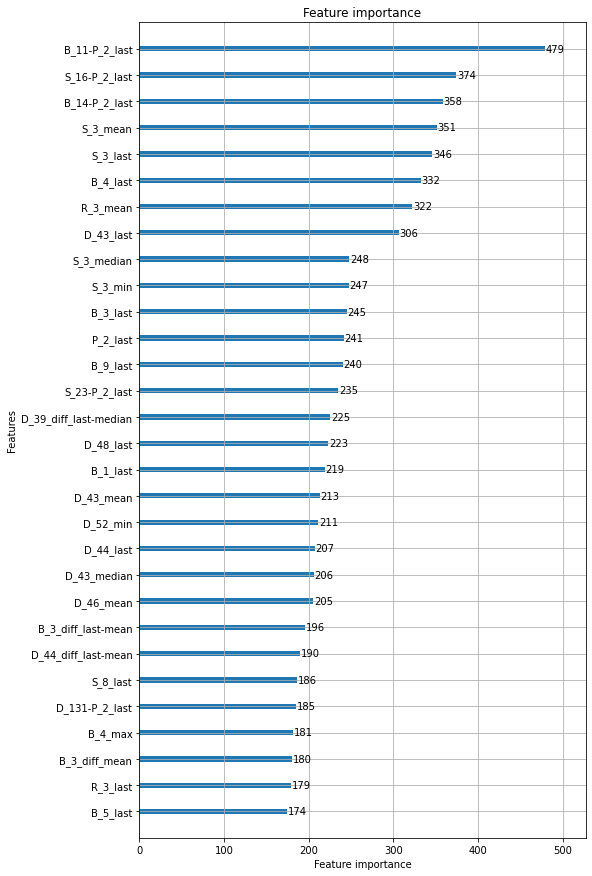

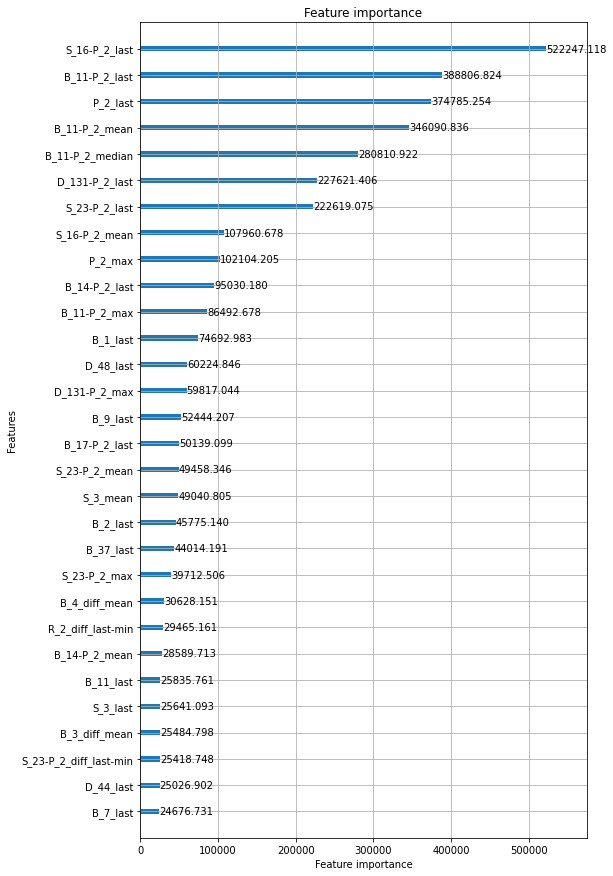

Training time: 39.83211627801259 min.


OOF recall_at4: 0.6620409331134076


OOF normalized_gini: 0.9229335020227624


OOF competition metric: 0.792487217568085


############################### repeated cross-validation step: 2/3 ################################


######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.747859	valid_0's recall_at4: 0.597829	valid_0's norm_gini: 0.897889


[100]	valid_0's amex_metric: 0.760106	valid_0's recall_at4: 0.615922	valid_0's norm_gini: 0.904291


[150]	valid_0's amex_metric: 0.767794	valid_0's recall_at4: 0.627283	valid_0's norm_gini: 0.908305


[200]	valid_0's amex_metric: 0.774288	valid_0's recall_at4: 0.636329	valid_0's norm_gini: 0.912246


[250]	valid_0's amex_metric: 0.777725	valid_0's recall_at4: 0.640747	valid_0's norm_gini: 0.914702


[300]	valid_0's amex_metric: 0.78014	valid_0's recall_at4: 0.643903	valid_0's norm_gini: 0.916376


[350]	valid_0's amex_metric: 0.782184	valid_0's recall_at4: 0.646848	valid_0's norm_gini: 0.917519


[400]	valid_0's amex_metric: 0.783519	valid_0's recall_at4: 0.648616	valid_0's norm_gini: 0.918423


[450]	valid_0's amex_metric: 0.785682	valid_0's recall_at4: 0.652234	valid_0's norm_gini: 0.919131


[500]	valid_0's amex_metric: 0.786864	valid_0's recall_at4: 0.654044	valid_0's norm_gini: 0.919683


[550]	valid_0's amex_metric: 0.786965	valid_0's recall_at4: 0.653791	valid_0's norm_gini: 0.920139


[600]	valid_0's amex_metric: 0.787884	valid_0's recall_at4: 0.655348	valid_0's norm_gini: 0.92042


[650]	valid_0's amex_metric: 0.788872	valid_0's recall_at4: 0.656989	valid_0's norm_gini: 0.920755


[700]	valid_0's amex_metric: 0.789376	valid_0's recall_at4: 0.657704	valid_0's norm_gini: 0.921048


[750]	valid_0's amex_metric: 0.789784	valid_0's recall_at4: 0.658293	valid_0's norm_gini: 0.921275


[800]	valid_0's amex_metric: 0.790142	valid_0's recall_at4: 0.65884	valid_0's norm_gini: 0.921444


[850]	valid_0's amex_metric: 0.789989	valid_0's recall_at4: 0.658293	valid_0's norm_gini: 0.921684


[900]	valid_0's amex_metric: 0.791445	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.921861


[950]	valid_0's amex_metric: 0.791447	valid_0's recall_at4: 0.660818	valid_0's norm_gini: 0.922076


[1000]	valid_0's amex_metric: 0.791516	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.922257


[1050]	valid_0's amex_metric: 0.792867	valid_0's recall_at4: 0.663258	valid_0's norm_gini: 0.922475


[1100]	valid_0's amex_metric: 0.793398	valid_0's recall_at4: 0.6641	valid_0's norm_gini: 0.922696


[1150]	valid_0's amex_metric: 0.793589	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.922825


[1200]	valid_0's amex_metric: 0.793926	valid_0's recall_at4: 0.664899	valid_0's norm_gini: 0.922952


[1250]	valid_0's amex_metric: 0.794366	valid_0's recall_at4: 0.665657	valid_0's norm_gini: 0.923076


[1300]	valid_0's amex_metric: 0.794294	valid_0's recall_at4: 0.665446	valid_0's norm_gini: 0.923142


[1350]	valid_0's amex_metric: 0.794359	valid_0's recall_at4: 0.665489	valid_0's norm_gini: 0.923229


[1400]	valid_0's amex_metric: 0.794774	valid_0's recall_at4: 0.666246	valid_0's norm_gini: 0.923302


[1450]	valid_0's amex_metric: 0.794928	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.9234


[1500]	valid_0's amex_metric: 0.794929	valid_0's recall_at4: 0.666372	valid_0's norm_gini: 0.923485


[1550]	valid_0's amex_metric: 0.795373	valid_0's recall_at4: 0.667172	valid_0's norm_gini: 0.923575


[1600]	valid_0's amex_metric: 0.795829	valid_0's recall_at4: 0.668013	valid_0's norm_gini: 0.923645


[1650]	valid_0's amex_metric: 0.796027	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.923703


[1700]	valid_0's amex_metric: 0.795601	valid_0's recall_at4: 0.667466	valid_0's norm_gini: 0.923736


[1750]	valid_0's amex_metric: 0.795989	valid_0's recall_at4: 0.668181	valid_0's norm_gini: 0.923796


[1800]	valid_0's amex_metric: 0.795376	valid_0's recall_at4: 0.666919	valid_0's norm_gini: 0.923834


[1850]	valid_0's amex_metric: 0.7952	valid_0's recall_at4: 0.66654	valid_0's norm_gini: 0.92386


[1900]	valid_0's amex_metric: 0.795498	valid_0's recall_at4: 0.667087	valid_0's norm_gini: 0.923908


[1950]	valid_0's amex_metric: 0.795366	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.923981


[2000]	valid_0's amex_metric: 0.79516	valid_0's recall_at4: 0.666288	valid_0's norm_gini: 0.924032


[2050]	valid_0's amex_metric: 0.795051	valid_0's recall_at4: 0.666036	valid_0's norm_gini: 0.924067


[2100]	valid_0's amex_metric: 0.795473	valid_0's recall_at4: 0.666835	valid_0's norm_gini: 0.924111


[2150]	valid_0's amex_metric: 0.79528	valid_0's recall_at4: 0.666414	valid_0's norm_gini: 0.924147


[2200]	valid_0's amex_metric: 0.795526	valid_0's recall_at4: 0.666877	valid_0's norm_gini: 0.924176


[2250]	valid_0's amex_metric: 0.795249	valid_0's recall_at4: 0.666288	valid_0's norm_gini: 0.924211


[2300]	valid_0's amex_metric: 0.795198	valid_0's recall_at4: 0.666162	valid_0's norm_gini: 0.924234


[2350]	valid_0's amex_metric: 0.795871	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924233


[2400]	valid_0's amex_metric: 0.79593	valid_0's recall_at4: 0.667592	valid_0's norm_gini: 0.924267


[2450]	valid_0's amex_metric: 0.795962	valid_0's recall_at4: 0.667634	valid_0's norm_gini: 0.924289


[2500]	valid_0's amex_metric: 0.795999	valid_0's recall_at4: 0.667677	valid_0's norm_gini: 0.924322


[2550]	valid_0's amex_metric: 0.796216	valid_0's recall_at4: 0.668097	valid_0's norm_gini: 0.924335


[2600]	valid_0's amex_metric: 0.796153	valid_0's recall_at4: 0.667971	valid_0's norm_gini: 0.924334


[2650]	valid_0's amex_metric: 0.796653	valid_0's recall_at4: 0.668939	valid_0's norm_gini: 0.924367


[2700]	valid_0's amex_metric: 0.796538	valid_0's recall_at4: 0.668686	valid_0's norm_gini: 0.924389


[2750]	valid_0's amex_metric: 0.796401	valid_0's recall_at4: 0.668392	valid_0's norm_gini: 0.924411


[2800]	valid_0's amex_metric: 0.796521	valid_0's recall_at4: 0.668644	valid_0's norm_gini: 0.924397


[2850]	valid_0's amex_metric: 0.795952	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924395


[2900]	valid_0's amex_metric: 0.79595	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924393


[2950]	valid_0's amex_metric: 0.795762	valid_0's recall_at4: 0.66713	valid_0's norm_gini: 0.924394


[3000]	valid_0's amex_metric: 0.795573	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.924394


[3050]	valid_0's amex_metric: 0.796092	valid_0's recall_at4: 0.667803	valid_0's norm_gini: 0.924381


[3100]	valid_0's amex_metric: 0.796201	valid_0's recall_at4: 0.668013	valid_0's norm_gini: 0.924389


[3150]	valid_0's amex_metric: 0.79616	valid_0's recall_at4: 0.667929	valid_0's norm_gini: 0.92439


[3200]	valid_0's amex_metric: 0.79665	valid_0's recall_at4: 0.668897	valid_0's norm_gini: 0.924403


[3250]	valid_0's amex_metric: 0.796341	valid_0's recall_at4: 0.668266	valid_0's norm_gini: 0.924417


[3300]	valid_0's amex_metric: 0.796386	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.924423


[3350]	valid_0's amex_metric: 0.795985	valid_0's recall_at4: 0.66755	valid_0's norm_gini: 0.92442


[3400]	valid_0's amex_metric: 0.796303	valid_0's recall_at4: 0.668181	valid_0's norm_gini: 0.924424


[3450]	valid_0's amex_metric: 0.795931	valid_0's recall_at4: 0.667424	valid_0's norm_gini: 0.924437


[3500]	valid_0's amex_metric: 0.796068	valid_0's recall_at4: 0.667677	valid_0's norm_gini: 0.924459


[3550]	valid_0's amex_metric: 0.796034	valid_0's recall_at4: 0.667592	valid_0's norm_gini: 0.924476


[3600]	valid_0's amex_metric: 0.795984	valid_0's recall_at4: 0.667466	valid_0's norm_gini: 0.924502


[3650]	valid_0's amex_metric: 0.796118	valid_0's recall_at4: 0.667719	valid_0's norm_gini: 0.924518


[3700]	valid_0's amex_metric: 0.796463	valid_0's recall_at4: 0.668392	valid_0's norm_gini: 0.924534


[3750]	valid_0's amex_metric: 0.796777	valid_0's recall_at4: 0.669023	valid_0's norm_gini: 0.92453


[3800]	valid_0's amex_metric: 0.796451	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.924552


[3850]	valid_0's amex_metric: 0.796885	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.924579


[3900]	valid_0's amex_metric: 0.796525	valid_0's recall_at4: 0.668476	valid_0's norm_gini: 0.924574


[3950]	valid_0's amex_metric: 0.797195	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.924567


[4000]	valid_0's amex_metric: 0.796845	valid_0's recall_at4: 0.669107	valid_0's norm_gini: 0.924582


[4050]	valid_0's amex_metric: 0.797159	valid_0's recall_at4: 0.669738	valid_0's norm_gini: 0.924579


[4100]	valid_0's amex_metric: 0.796996	valid_0's recall_at4: 0.669402	valid_0's norm_gini: 0.924591


[4150]	valid_0's amex_metric: 0.796934	valid_0's recall_at4: 0.669275	valid_0's norm_gini: 0.924593


[4200]	valid_0's amex_metric: 0.796958	valid_0's recall_at4: 0.669317	valid_0's norm_gini: 0.924599


[4250]	valid_0's amex_metric: 0.79689	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.924588


[4300]	valid_0's amex_metric: 0.797243	valid_0's recall_at4: 0.669907	valid_0's norm_gini: 0.924579


[4350]	valid_0's amex_metric: 0.797035	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.924584


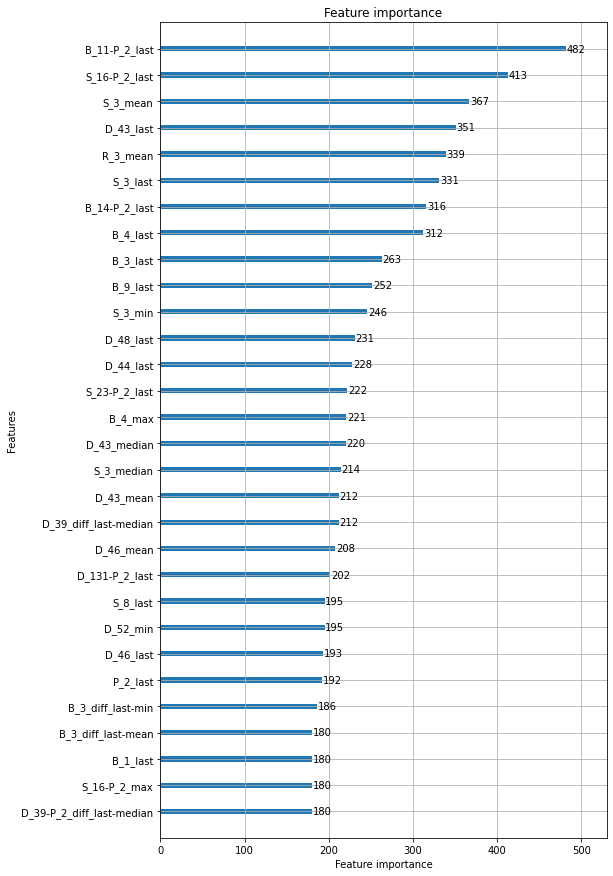

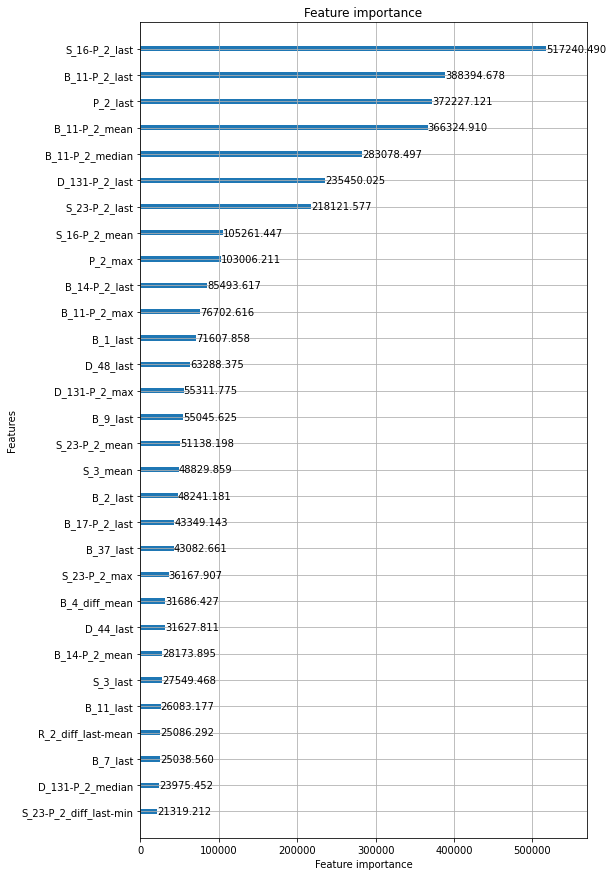

######################################## training model 2/5 ########################################


[50]	valid_0's amex_metric: 0.745261	valid_0's recall_at4: 0.594	valid_0's norm_gini: 0.896522


[100]	valid_0's amex_metric: 0.757169	valid_0's recall_at4: 0.611041	valid_0's norm_gini: 0.903297


[150]	valid_0's amex_metric: 0.762065	valid_0's recall_at4: 0.617016	valid_0's norm_gini: 0.907114


[200]	valid_0's amex_metric: 0.766863	valid_0's recall_at4: 0.622865	valid_0's norm_gini: 0.910862


[250]	valid_0's amex_metric: 0.770666	valid_0's recall_at4: 0.627956	valid_0's norm_gini: 0.913375


[300]	valid_0's amex_metric: 0.773266	valid_0's recall_at4: 0.631659	valid_0's norm_gini: 0.914874


[350]	valid_0's amex_metric: 0.775919	valid_0's recall_at4: 0.635782	valid_0's norm_gini: 0.916055


[400]	valid_0's amex_metric: 0.776452	valid_0's recall_at4: 0.635993	valid_0's norm_gini: 0.916912


[450]	valid_0's amex_metric: 0.778674	valid_0's recall_at4: 0.639737	valid_0's norm_gini: 0.91761


[500]	valid_0's amex_metric: 0.779756	valid_0's recall_at4: 0.641378	valid_0's norm_gini: 0.918133


[550]	valid_0's amex_metric: 0.780823	valid_0's recall_at4: 0.643062	valid_0's norm_gini: 0.918584


[600]	valid_0's amex_metric: 0.780689	valid_0's recall_at4: 0.642515	valid_0's norm_gini: 0.918863


[650]	valid_0's amex_metric: 0.78102	valid_0's recall_at4: 0.642851	valid_0's norm_gini: 0.919188


[700]	valid_0's amex_metric: 0.78146	valid_0's recall_at4: 0.64344	valid_0's norm_gini: 0.91948


[750]	valid_0's amex_metric: 0.782134	valid_0's recall_at4: 0.644618	valid_0's norm_gini: 0.91965


[800]	valid_0's amex_metric: 0.782113	valid_0's recall_at4: 0.644366	valid_0's norm_gini: 0.919859


[850]	valid_0's amex_metric: 0.782871	valid_0's recall_at4: 0.645628	valid_0's norm_gini: 0.920113


[900]	valid_0's amex_metric: 0.783324	valid_0's recall_at4: 0.646386	valid_0's norm_gini: 0.920262


[950]	valid_0's amex_metric: 0.78348	valid_0's recall_at4: 0.64647	valid_0's norm_gini: 0.92049


[1000]	valid_0's amex_metric: 0.784104	valid_0's recall_at4: 0.647522	valid_0's norm_gini: 0.920686


[1050]	valid_0's amex_metric: 0.784733	valid_0's recall_at4: 0.648574	valid_0's norm_gini: 0.920893


[1100]	valid_0's amex_metric: 0.785407	valid_0's recall_at4: 0.64971	valid_0's norm_gini: 0.921104


[1150]	valid_0's amex_metric: 0.785816	valid_0's recall_at4: 0.650425	valid_0's norm_gini: 0.921208


[1200]	valid_0's amex_metric: 0.785889	valid_0's recall_at4: 0.650467	valid_0's norm_gini: 0.921312


[1250]	valid_0's amex_metric: 0.786077	valid_0's recall_at4: 0.650762	valid_0's norm_gini: 0.921392


[1300]	valid_0's amex_metric: 0.786601	valid_0's recall_at4: 0.651729	valid_0's norm_gini: 0.921474


[1350]	valid_0's amex_metric: 0.786173	valid_0's recall_at4: 0.650804	valid_0's norm_gini: 0.921542


[1400]	valid_0's amex_metric: 0.786675	valid_0's recall_at4: 0.651729	valid_0's norm_gini: 0.921621


[1450]	valid_0's amex_metric: 0.786708	valid_0's recall_at4: 0.651729	valid_0's norm_gini: 0.921687


[1500]	valid_0's amex_metric: 0.787093	valid_0's recall_at4: 0.652403	valid_0's norm_gini: 0.921784


[1550]	valid_0's amex_metric: 0.787489	valid_0's recall_at4: 0.653118	valid_0's norm_gini: 0.921859


[1600]	valid_0's amex_metric: 0.787352	valid_0's recall_at4: 0.652781	valid_0's norm_gini: 0.921923


[1650]	valid_0's amex_metric: 0.787588	valid_0's recall_at4: 0.653202	valid_0's norm_gini: 0.921973


[1700]	valid_0's amex_metric: 0.787675	valid_0's recall_at4: 0.653328	valid_0's norm_gini: 0.922022


[1750]	valid_0's amex_metric: 0.788014	valid_0's recall_at4: 0.653959	valid_0's norm_gini: 0.92207


[1800]	valid_0's amex_metric: 0.787614	valid_0's recall_at4: 0.653118	valid_0's norm_gini: 0.922111


[1850]	valid_0's amex_metric: 0.787891	valid_0's recall_at4: 0.653623	valid_0's norm_gini: 0.922159


[1900]	valid_0's amex_metric: 0.788381	valid_0's recall_at4: 0.654591	valid_0's norm_gini: 0.922172


[1950]	valid_0's amex_metric: 0.787815	valid_0's recall_at4: 0.653412	valid_0's norm_gini: 0.922217


[2000]	valid_0's amex_metric: 0.787905	valid_0's recall_at4: 0.653581	valid_0's norm_gini: 0.922229


[2050]	valid_0's amex_metric: 0.788074	valid_0's recall_at4: 0.653875	valid_0's norm_gini: 0.922273


[2100]	valid_0's amex_metric: 0.788349	valid_0's recall_at4: 0.65438	valid_0's norm_gini: 0.922317


[2150]	valid_0's amex_metric: 0.788044	valid_0's recall_at4: 0.653749	valid_0's norm_gini: 0.922339


[2200]	valid_0's amex_metric: 0.788595	valid_0's recall_at4: 0.654801	valid_0's norm_gini: 0.922389


[2250]	valid_0's amex_metric: 0.787781	valid_0's recall_at4: 0.65316	valid_0's norm_gini: 0.922403


[2300]	valid_0's amex_metric: 0.788004	valid_0's recall_at4: 0.653581	valid_0's norm_gini: 0.922427


[2350]	valid_0's amex_metric: 0.788566	valid_0's recall_at4: 0.654675	valid_0's norm_gini: 0.922457


[2400]	valid_0's amex_metric: 0.788605	valid_0's recall_at4: 0.654717	valid_0's norm_gini: 0.922493


[2450]	valid_0's amex_metric: 0.78844	valid_0's recall_at4: 0.65438	valid_0's norm_gini: 0.922499


[2500]	valid_0's amex_metric: 0.788544	valid_0's recall_at4: 0.654591	valid_0's norm_gini: 0.922497


[2550]	valid_0's amex_metric: 0.788574	valid_0's recall_at4: 0.654633	valid_0's norm_gini: 0.922515


[2600]	valid_0's amex_metric: 0.78866	valid_0's recall_at4: 0.654801	valid_0's norm_gini: 0.92252


[2650]	valid_0's amex_metric: 0.788717	valid_0's recall_at4: 0.654885	valid_0's norm_gini: 0.922549


[2700]	valid_0's amex_metric: 0.788994	valid_0's recall_at4: 0.655432	valid_0's norm_gini: 0.922555


[2750]	valid_0's amex_metric: 0.788511	valid_0's recall_at4: 0.654464	valid_0's norm_gini: 0.922558


[2800]	valid_0's amex_metric: 0.78879	valid_0's recall_at4: 0.655011	valid_0's norm_gini: 0.922568


[2850]	valid_0's amex_metric: 0.788917	valid_0's recall_at4: 0.655264	valid_0's norm_gini: 0.922571


[2900]	valid_0's amex_metric: 0.789344	valid_0's recall_at4: 0.656105	valid_0's norm_gini: 0.922582


[2950]	valid_0's amex_metric: 0.788552	valid_0's recall_at4: 0.654506	valid_0's norm_gini: 0.922598


[3000]	valid_0's amex_metric: 0.788703	valid_0's recall_at4: 0.654801	valid_0's norm_gini: 0.922605


[3050]	valid_0's amex_metric: 0.78875	valid_0's recall_at4: 0.654885	valid_0's norm_gini: 0.922616


[3100]	valid_0's amex_metric: 0.788776	valid_0's recall_at4: 0.654927	valid_0's norm_gini: 0.922624


[3150]	valid_0's amex_metric: 0.788697	valid_0's recall_at4: 0.654759	valid_0's norm_gini: 0.922635


[3200]	valid_0's amex_metric: 0.789221	valid_0's recall_at4: 0.655811	valid_0's norm_gini: 0.922631


[3250]	valid_0's amex_metric: 0.788529	valid_0's recall_at4: 0.654422	valid_0's norm_gini: 0.922635


[3300]	valid_0's amex_metric: 0.788527	valid_0's recall_at4: 0.654422	valid_0's norm_gini: 0.922631


[3350]	valid_0's amex_metric: 0.788804	valid_0's recall_at4: 0.654969	valid_0's norm_gini: 0.922638


[3400]	valid_0's amex_metric: 0.788929	valid_0's recall_at4: 0.655222	valid_0's norm_gini: 0.922637


[3450]	valid_0's amex_metric: 0.788595	valid_0's recall_at4: 0.654549	valid_0's norm_gini: 0.922641


[3500]	valid_0's amex_metric: 0.788656	valid_0's recall_at4: 0.654675	valid_0's norm_gini: 0.922638


[3550]	valid_0's amex_metric: 0.789186	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.922645


[3600]	valid_0's amex_metric: 0.788657	valid_0's recall_at4: 0.654675	valid_0's norm_gini: 0.92264


[3650]	valid_0's amex_metric: 0.788819	valid_0's recall_at4: 0.655011	valid_0's norm_gini: 0.922626


[3700]	valid_0's amex_metric: 0.789137	valid_0's recall_at4: 0.655643	valid_0's norm_gini: 0.922632


[3750]	valid_0's amex_metric: 0.789191	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.922655


[3800]	valid_0's amex_metric: 0.789424	valid_0's recall_at4: 0.65619	valid_0's norm_gini: 0.922659


[3850]	valid_0's amex_metric: 0.789151	valid_0's recall_at4: 0.655643	valid_0's norm_gini: 0.92266


[3900]	valid_0's amex_metric: 0.789273	valid_0's recall_at4: 0.655895	valid_0's norm_gini: 0.922652


[3950]	valid_0's amex_metric: 0.789372	valid_0's recall_at4: 0.656105	valid_0's norm_gini: 0.922639


[4000]	valid_0's amex_metric: 0.789456	valid_0's recall_at4: 0.656274	valid_0's norm_gini: 0.922639


[4050]	valid_0's amex_metric: 0.789179	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.922631


[4100]	valid_0's amex_metric: 0.788805	valid_0's recall_at4: 0.654969	valid_0's norm_gini: 0.92264


[4150]	valid_0's amex_metric: 0.788974	valid_0's recall_at4: 0.655306	valid_0's norm_gini: 0.922641


[4200]	valid_0's amex_metric: 0.788999	valid_0's recall_at4: 0.655348	valid_0's norm_gini: 0.92265


[4250]	valid_0's amex_metric: 0.7889	valid_0's recall_at4: 0.655138	valid_0's norm_gini: 0.922663


[4300]	valid_0's amex_metric: 0.788982	valid_0's recall_at4: 0.655306	valid_0's norm_gini: 0.922658


[4350]	valid_0's amex_metric: 0.789202	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.922677


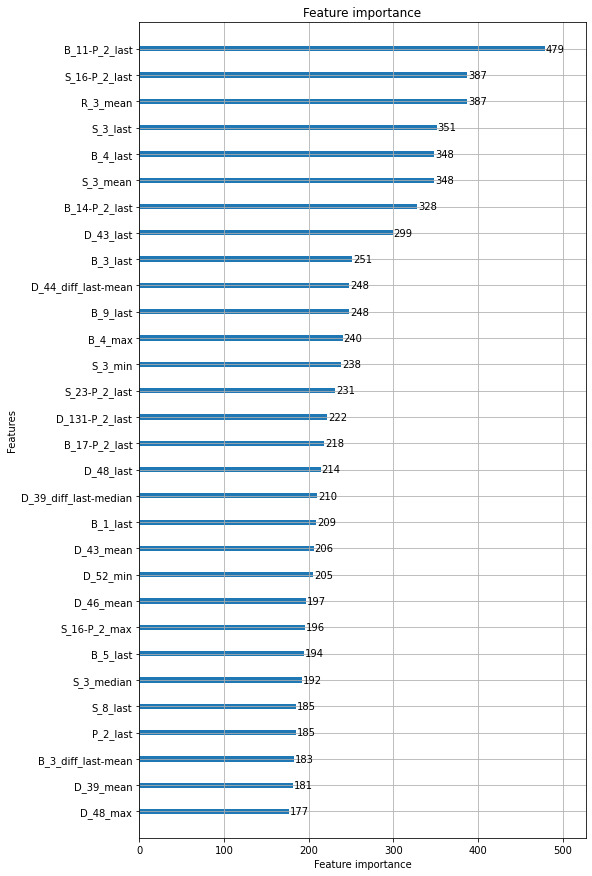

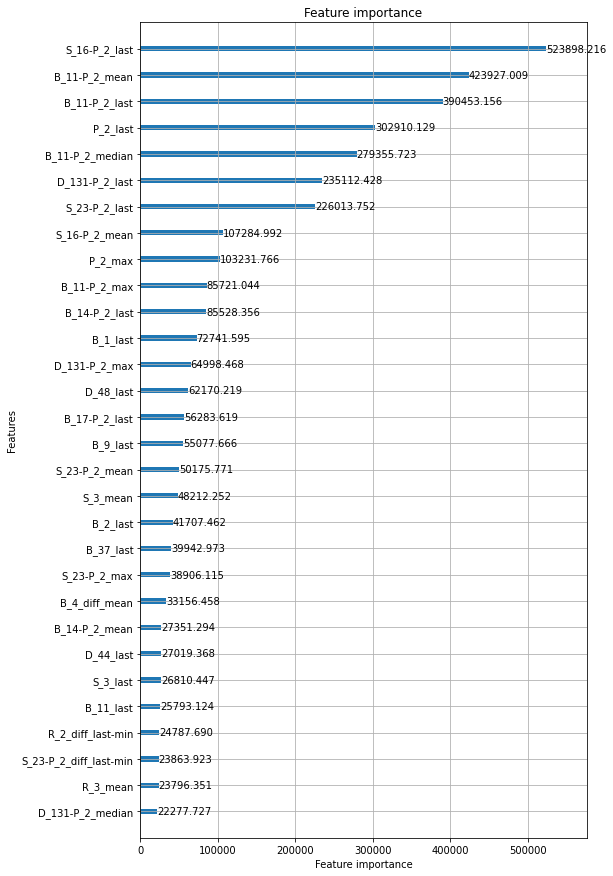

######################################## training model 3/5 ########################################


[50]	valid_0's amex_metric: 0.741743	valid_0's recall_at4: 0.588277	valid_0's norm_gini: 0.895209


[100]	valid_0's amex_metric: 0.753488	valid_0's recall_at4: 0.60494	valid_0's norm_gini: 0.902036


[150]	valid_0's amex_metric: 0.760196	valid_0's recall_at4: 0.614449	valid_0's norm_gini: 0.905943


[200]	valid_0's amex_metric: 0.765432	valid_0's recall_at4: 0.621139	valid_0's norm_gini: 0.909725


[250]	valid_0's amex_metric: 0.769423	valid_0's recall_at4: 0.626525	valid_0's norm_gini: 0.912322


[300]	valid_0's amex_metric: 0.77201	valid_0's recall_at4: 0.630102	valid_0's norm_gini: 0.913919


[350]	valid_0's amex_metric: 0.773811	valid_0's recall_at4: 0.6325	valid_0's norm_gini: 0.915123


[400]	valid_0's amex_metric: 0.776649	valid_0's recall_at4: 0.637339	valid_0's norm_gini: 0.91596


[450]	valid_0's amex_metric: 0.778174	valid_0's recall_at4: 0.639695	valid_0's norm_gini: 0.916652


[500]	valid_0's amex_metric: 0.779552	valid_0's recall_at4: 0.641925	valid_0's norm_gini: 0.917178


[550]	valid_0's amex_metric: 0.780179	valid_0's recall_at4: 0.642725	valid_0's norm_gini: 0.917634


[600]	valid_0's amex_metric: 0.78045	valid_0's recall_at4: 0.643019	valid_0's norm_gini: 0.91788


[650]	valid_0's amex_metric: 0.78151	valid_0's recall_at4: 0.644787	valid_0's norm_gini: 0.918233


[700]	valid_0's amex_metric: 0.781607	valid_0's recall_at4: 0.64466	valid_0's norm_gini: 0.918553


[750]	valid_0's amex_metric: 0.7821	valid_0's recall_at4: 0.645418	valid_0's norm_gini: 0.918783


[800]	valid_0's amex_metric: 0.781892	valid_0's recall_at4: 0.644787	valid_0's norm_gini: 0.918997


[850]	valid_0's amex_metric: 0.78242	valid_0's recall_at4: 0.645544	valid_0's norm_gini: 0.919295


[900]	valid_0's amex_metric: 0.78257	valid_0's recall_at4: 0.64567	valid_0's norm_gini: 0.919469


[950]	valid_0's amex_metric: 0.783392	valid_0's recall_at4: 0.647101	valid_0's norm_gini: 0.919682


[1000]	valid_0's amex_metric: 0.784069	valid_0's recall_at4: 0.648237	valid_0's norm_gini: 0.919901


[1050]	valid_0's amex_metric: 0.783827	valid_0's recall_at4: 0.647522	valid_0's norm_gini: 0.920133


[1100]	valid_0's amex_metric: 0.784658	valid_0's recall_at4: 0.648994	valid_0's norm_gini: 0.920322


[1150]	valid_0's amex_metric: 0.784329	valid_0's recall_at4: 0.648237	valid_0's norm_gini: 0.92042


[1200]	valid_0's amex_metric: 0.784704	valid_0's recall_at4: 0.64891	valid_0's norm_gini: 0.920498


[1250]	valid_0's amex_metric: 0.784704	valid_0's recall_at4: 0.648784	valid_0's norm_gini: 0.920624


[1300]	valid_0's amex_metric: 0.785054	valid_0's recall_at4: 0.649415	valid_0's norm_gini: 0.920694


[1350]	valid_0's amex_metric: 0.784805	valid_0's recall_at4: 0.648868	valid_0's norm_gini: 0.920742


[1400]	valid_0's amex_metric: 0.784921	valid_0's recall_at4: 0.648994	valid_0's norm_gini: 0.920848


[1450]	valid_0's amex_metric: 0.784959	valid_0's recall_at4: 0.648994	valid_0's norm_gini: 0.920924


[1500]	valid_0's amex_metric: 0.78527	valid_0's recall_at4: 0.649541	valid_0's norm_gini: 0.920999


[1550]	valid_0's amex_metric: 0.785183	valid_0's recall_at4: 0.649289	valid_0's norm_gini: 0.921077


[1600]	valid_0's amex_metric: 0.785533	valid_0's recall_at4: 0.649962	valid_0's norm_gini: 0.921105


[1650]	valid_0's amex_metric: 0.785485	valid_0's recall_at4: 0.649836	valid_0's norm_gini: 0.921135


[1700]	valid_0's amex_metric: 0.785362	valid_0's recall_at4: 0.649583	valid_0's norm_gini: 0.92114


[1750]	valid_0's amex_metric: 0.785857	valid_0's recall_at4: 0.650509	valid_0's norm_gini: 0.921205


[1800]	valid_0's amex_metric: 0.786019	valid_0's recall_at4: 0.650804	valid_0's norm_gini: 0.921233


[1850]	valid_0's amex_metric: 0.785948	valid_0's recall_at4: 0.650635	valid_0's norm_gini: 0.92126


[1900]	valid_0's amex_metric: 0.785666	valid_0's recall_at4: 0.650046	valid_0's norm_gini: 0.921285


[1950]	valid_0's amex_metric: 0.786137	valid_0's recall_at4: 0.65093	valid_0's norm_gini: 0.921345


[2000]	valid_0's amex_metric: 0.785769	valid_0's recall_at4: 0.650173	valid_0's norm_gini: 0.921366


[2050]	valid_0's amex_metric: 0.786001	valid_0's recall_at4: 0.650593	valid_0's norm_gini: 0.921408


[2100]	valid_0's amex_metric: 0.785823	valid_0's recall_at4: 0.650173	valid_0's norm_gini: 0.921473


[2150]	valid_0's amex_metric: 0.785792	valid_0's recall_at4: 0.650088	valid_0's norm_gini: 0.921496


[2200]	valid_0's amex_metric: 0.785722	valid_0's recall_at4: 0.64992	valid_0's norm_gini: 0.921523


[2250]	valid_0's amex_metric: 0.785621	valid_0's recall_at4: 0.64971	valid_0's norm_gini: 0.921532


[2300]	valid_0's amex_metric: 0.785375	valid_0's recall_at4: 0.649205	valid_0's norm_gini: 0.921545


[2350]	valid_0's amex_metric: 0.785673	valid_0's recall_at4: 0.649794	valid_0's norm_gini: 0.921553


[2400]	valid_0's amex_metric: 0.785555	valid_0's recall_at4: 0.649541	valid_0's norm_gini: 0.921568


[2450]	valid_0's amex_metric: 0.785923	valid_0's recall_at4: 0.650257	valid_0's norm_gini: 0.921588


[2500]	valid_0's amex_metric: 0.785678	valid_0's recall_at4: 0.649752	valid_0's norm_gini: 0.921604


[2550]	valid_0's amex_metric: 0.785641	valid_0's recall_at4: 0.649668	valid_0's norm_gini: 0.921614


[2600]	valid_0's amex_metric: 0.786269	valid_0's recall_at4: 0.65093	valid_0's norm_gini: 0.921607


[2650]	valid_0's amex_metric: 0.785834	valid_0's recall_at4: 0.650046	valid_0's norm_gini: 0.921622


[2700]	valid_0's amex_metric: 0.786483	valid_0's recall_at4: 0.651351	valid_0's norm_gini: 0.921616


[2750]	valid_0's amex_metric: 0.786254	valid_0's recall_at4: 0.650888	valid_0's norm_gini: 0.92162


[2800]	valid_0's amex_metric: 0.78641	valid_0's recall_at4: 0.651182	valid_0's norm_gini: 0.921637


[2850]	valid_0's amex_metric: 0.786685	valid_0's recall_at4: 0.651729	valid_0's norm_gini: 0.921641


[2900]	valid_0's amex_metric: 0.786453	valid_0's recall_at4: 0.651267	valid_0's norm_gini: 0.921639


[2950]	valid_0's amex_metric: 0.786255	valid_0's recall_at4: 0.650846	valid_0's norm_gini: 0.921665


[3000]	valid_0's amex_metric: 0.786235	valid_0's recall_at4: 0.650804	valid_0's norm_gini: 0.921665


[3050]	valid_0's amex_metric: 0.786211	valid_0's recall_at4: 0.650762	valid_0's norm_gini: 0.92166


[3100]	valid_0's amex_metric: 0.78623	valid_0's recall_at4: 0.650804	valid_0's norm_gini: 0.921656


[3150]	valid_0's amex_metric: 0.786592	valid_0's recall_at4: 0.651519	valid_0's norm_gini: 0.921665


[3200]	valid_0's amex_metric: 0.786507	valid_0's recall_at4: 0.651351	valid_0's norm_gini: 0.921663


[3250]	valid_0's amex_metric: 0.786377	valid_0's recall_at4: 0.651098	valid_0's norm_gini: 0.921655


[3300]	valid_0's amex_metric: 0.7862	valid_0's recall_at4: 0.650762	valid_0's norm_gini: 0.921637


[3350]	valid_0's amex_metric: 0.78626	valid_0's recall_at4: 0.650888	valid_0's norm_gini: 0.921633


[3400]	valid_0's amex_metric: 0.78565	valid_0's recall_at4: 0.649668	valid_0's norm_gini: 0.921633


[3450]	valid_0's amex_metric: 0.785712	valid_0's recall_at4: 0.649794	valid_0's norm_gini: 0.921631


[3500]	valid_0's amex_metric: 0.785885	valid_0's recall_at4: 0.650173	valid_0's norm_gini: 0.921598


[3550]	valid_0's amex_metric: 0.785623	valid_0's recall_at4: 0.649626	valid_0's norm_gini: 0.921621


[3600]	valid_0's amex_metric: 0.786085	valid_0's recall_at4: 0.650551	valid_0's norm_gini: 0.92162


[3650]	valid_0's amex_metric: 0.785991	valid_0's recall_at4: 0.650341	valid_0's norm_gini: 0.921642


[3700]	valid_0's amex_metric: 0.786055	valid_0's recall_at4: 0.650467	valid_0's norm_gini: 0.921643


[3750]	valid_0's amex_metric: 0.78545	valid_0's recall_at4: 0.649247	valid_0's norm_gini: 0.921654


[3800]	valid_0's amex_metric: 0.785893	valid_0's recall_at4: 0.65013	valid_0's norm_gini: 0.921656


[3850]	valid_0's amex_metric: 0.785682	valid_0's recall_at4: 0.64971	valid_0's norm_gini: 0.921655


[3900]	valid_0's amex_metric: 0.785764	valid_0's recall_at4: 0.649878	valid_0's norm_gini: 0.92165


[3950]	valid_0's amex_metric: 0.785526	valid_0's recall_at4: 0.649415	valid_0's norm_gini: 0.921636


[4000]	valid_0's amex_metric: 0.785305	valid_0's recall_at4: 0.648994	valid_0's norm_gini: 0.921616


[4050]	valid_0's amex_metric: 0.785667	valid_0's recall_at4: 0.64971	valid_0's norm_gini: 0.921625


[4100]	valid_0's amex_metric: 0.785962	valid_0's recall_at4: 0.650299	valid_0's norm_gini: 0.921625


[4150]	valid_0's amex_metric: 0.785288	valid_0's recall_at4: 0.648952	valid_0's norm_gini: 0.921623


[4200]	valid_0's amex_metric: 0.78548	valid_0's recall_at4: 0.649331	valid_0's norm_gini: 0.921629


[4250]	valid_0's amex_metric: 0.785496	valid_0's recall_at4: 0.649373	valid_0's norm_gini: 0.92162


[4300]	valid_0's amex_metric: 0.785846	valid_0's recall_at4: 0.650046	valid_0's norm_gini: 0.921646


[4350]	valid_0's amex_metric: 0.785657	valid_0's recall_at4: 0.649668	valid_0's norm_gini: 0.921646


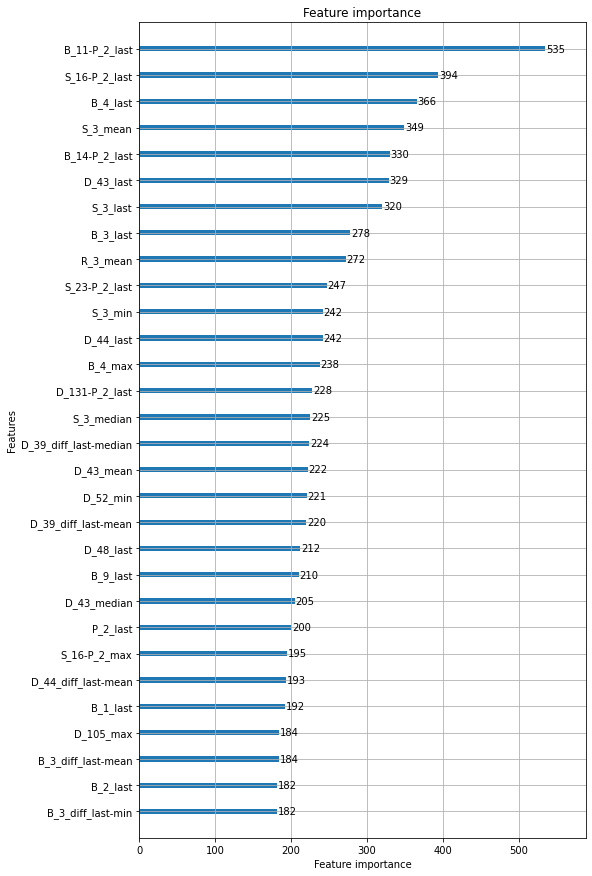

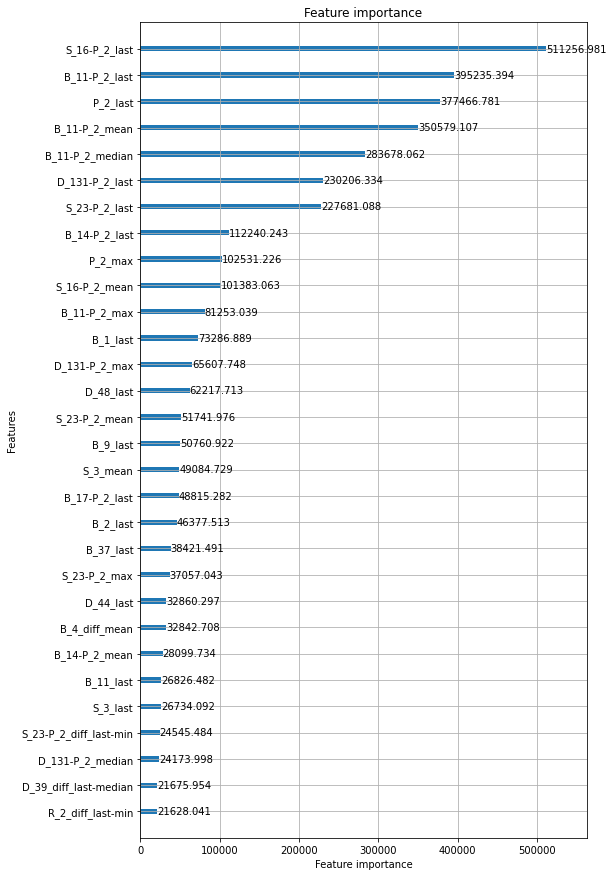

######################################## training model 4/5 ########################################


[50]	valid_0's amex_metric: 0.750095	valid_0's recall_at4: 0.602356	valid_0's norm_gini: 0.897833


[100]	valid_0's amex_metric: 0.760235	valid_0's recall_at4: 0.6162	valid_0's norm_gini: 0.90427


[150]	valid_0's amex_metric: 0.765421	valid_0's recall_at4: 0.622765	valid_0's norm_gini: 0.908078


[200]	valid_0's amex_metric: 0.77185	valid_0's recall_at4: 0.631938	valid_0's norm_gini: 0.911762


[250]	valid_0's amex_metric: 0.776102	valid_0's recall_at4: 0.637997	valid_0's norm_gini: 0.914208


[300]	valid_0's amex_metric: 0.77865	valid_0's recall_at4: 0.641658	valid_0's norm_gini: 0.915642


[350]	valid_0's amex_metric: 0.78074	valid_0's recall_at4: 0.644772	valid_0's norm_gini: 0.916708


[400]	valid_0's amex_metric: 0.781749	valid_0's recall_at4: 0.645908	valid_0's norm_gini: 0.91759


[450]	valid_0's amex_metric: 0.782395	valid_0's recall_at4: 0.646581	valid_0's norm_gini: 0.91821


[500]	valid_0's amex_metric: 0.783861	valid_0's recall_at4: 0.649022	valid_0's norm_gini: 0.918701


[550]	valid_0's amex_metric: 0.784319	valid_0's recall_at4: 0.649527	valid_0's norm_gini: 0.919112


[600]	valid_0's amex_metric: 0.785347	valid_0's recall_at4: 0.651252	valid_0's norm_gini: 0.919443


[650]	valid_0's amex_metric: 0.785288	valid_0's recall_at4: 0.650831	valid_0's norm_gini: 0.919745


[700]	valid_0's amex_metric: 0.786227	valid_0's recall_at4: 0.652388	valid_0's norm_gini: 0.920067


[750]	valid_0's amex_metric: 0.786707	valid_0's recall_at4: 0.653145	valid_0's norm_gini: 0.920269


[800]	valid_0's amex_metric: 0.787145	valid_0's recall_at4: 0.653819	valid_0's norm_gini: 0.92047


[850]	valid_0's amex_metric: 0.787089	valid_0's recall_at4: 0.653482	valid_0's norm_gini: 0.920697


[900]	valid_0's amex_metric: 0.7875	valid_0's recall_at4: 0.654155	valid_0's norm_gini: 0.920846


[950]	valid_0's amex_metric: 0.787972	valid_0's recall_at4: 0.654913	valid_0's norm_gini: 0.921032


[1000]	valid_0's amex_metric: 0.788245	valid_0's recall_at4: 0.655291	valid_0's norm_gini: 0.921198


[1050]	valid_0's amex_metric: 0.78825	valid_0's recall_at4: 0.655081	valid_0's norm_gini: 0.921419


[1100]	valid_0's amex_metric: 0.789103	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.921611


[1150]	valid_0's amex_metric: 0.789166	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.921736


[1200]	valid_0's amex_metric: 0.789262	valid_0's recall_at4: 0.65668	valid_0's norm_gini: 0.921844


[1250]	valid_0's amex_metric: 0.7899	valid_0's recall_at4: 0.657858	valid_0's norm_gini: 0.921942


[1300]	valid_0's amex_metric: 0.789732	valid_0's recall_at4: 0.657437	valid_0's norm_gini: 0.922027


[1350]	valid_0's amex_metric: 0.790202	valid_0's recall_at4: 0.658321	valid_0's norm_gini: 0.922082


[1400]	valid_0's amex_metric: 0.790223	valid_0's recall_at4: 0.658279	valid_0's norm_gini: 0.922167


[1450]	valid_0's amex_metric: 0.790412	valid_0's recall_at4: 0.658574	valid_0's norm_gini: 0.922251


[1500]	valid_0's amex_metric: 0.790943	valid_0's recall_at4: 0.659541	valid_0's norm_gini: 0.922344


[1550]	valid_0's amex_metric: 0.790858	valid_0's recall_at4: 0.659289	valid_0's norm_gini: 0.922427


[1600]	valid_0's amex_metric: 0.790649	valid_0's recall_at4: 0.658826	valid_0's norm_gini: 0.922473


[1650]	valid_0's amex_metric: 0.790964	valid_0's recall_at4: 0.659373	valid_0's norm_gini: 0.922554


[1700]	valid_0's amex_metric: 0.790744	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.922578


[1750]	valid_0's amex_metric: 0.790665	valid_0's recall_at4: 0.6587	valid_0's norm_gini: 0.92263


[1800]	valid_0's amex_metric: 0.790286	valid_0's recall_at4: 0.6579	valid_0's norm_gini: 0.922671


[1850]	valid_0's amex_metric: 0.790245	valid_0's recall_at4: 0.657774	valid_0's norm_gini: 0.922717


[1900]	valid_0's amex_metric: 0.790577	valid_0's recall_at4: 0.658405	valid_0's norm_gini: 0.922749


[1950]	valid_0's amex_metric: 0.790704	valid_0's recall_at4: 0.658616	valid_0's norm_gini: 0.922792


[2000]	valid_0's amex_metric: 0.790789	valid_0's recall_at4: 0.658742	valid_0's norm_gini: 0.922835


[2050]	valid_0's amex_metric: 0.791168	valid_0's recall_at4: 0.659457	valid_0's norm_gini: 0.922878


[2100]	valid_0's amex_metric: 0.791138	valid_0's recall_at4: 0.659373	valid_0's norm_gini: 0.922903


[2150]	valid_0's amex_metric: 0.791118	valid_0's recall_at4: 0.659289	valid_0's norm_gini: 0.922948


[2200]	valid_0's amex_metric: 0.790961	valid_0's recall_at4: 0.658952	valid_0's norm_gini: 0.92297


[2250]	valid_0's amex_metric: 0.791307	valid_0's recall_at4: 0.659625	valid_0's norm_gini: 0.922989


[2300]	valid_0's amex_metric: 0.791707	valid_0's recall_at4: 0.660383	valid_0's norm_gini: 0.923032


[2350]	valid_0's amex_metric: 0.791845	valid_0's recall_at4: 0.660635	valid_0's norm_gini: 0.923055


[2400]	valid_0's amex_metric: 0.791911	valid_0's recall_at4: 0.66072	valid_0's norm_gini: 0.923103


[2450]	valid_0's amex_metric: 0.792056	valid_0's recall_at4: 0.661014	valid_0's norm_gini: 0.923098


[2500]	valid_0's amex_metric: 0.792088	valid_0's recall_at4: 0.661056	valid_0's norm_gini: 0.92312


[2550]	valid_0's amex_metric: 0.79196	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.923116


[2600]	valid_0's amex_metric: 0.79184	valid_0's recall_at4: 0.660551	valid_0's norm_gini: 0.923129


[2650]	valid_0's amex_metric: 0.791866	valid_0's recall_at4: 0.660593	valid_0's norm_gini: 0.923139


[2700]	valid_0's amex_metric: 0.792296	valid_0's recall_at4: 0.661435	valid_0's norm_gini: 0.923156


[2750]	valid_0's amex_metric: 0.792155	valid_0's recall_at4: 0.66114	valid_0's norm_gini: 0.923169


[2800]	valid_0's amex_metric: 0.792428	valid_0's recall_at4: 0.661687	valid_0's norm_gini: 0.923169


[2850]	valid_0's amex_metric: 0.792331	valid_0's recall_at4: 0.661477	valid_0's norm_gini: 0.923185


[2900]	valid_0's amex_metric: 0.791818	valid_0's recall_at4: 0.660467	valid_0's norm_gini: 0.923169


[2950]	valid_0's amex_metric: 0.791897	valid_0's recall_at4: 0.660593	valid_0's norm_gini: 0.923201


[3000]	valid_0's amex_metric: 0.792093	valid_0's recall_at4: 0.660972	valid_0's norm_gini: 0.923215


[3050]	valid_0's amex_metric: 0.791999	valid_0's recall_at4: 0.660762	valid_0's norm_gini: 0.923237


[3100]	valid_0's amex_metric: 0.792534	valid_0's recall_at4: 0.661814	valid_0's norm_gini: 0.923254


[3150]	valid_0's amex_metric: 0.792619	valid_0's recall_at4: 0.661982	valid_0's norm_gini: 0.923255


[3200]	valid_0's amex_metric: 0.792536	valid_0's recall_at4: 0.661814	valid_0's norm_gini: 0.923258


[3250]	valid_0's amex_metric: 0.792004	valid_0's recall_at4: 0.660762	valid_0's norm_gini: 0.923247


[3300]	valid_0's amex_metric: 0.791941	valid_0's recall_at4: 0.660635	valid_0's norm_gini: 0.923246


[3350]	valid_0's amex_metric: 0.791307	valid_0's recall_at4: 0.659373	valid_0's norm_gini: 0.923242


[3400]	valid_0's amex_metric: 0.791492	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.923233


[3450]	valid_0's amex_metric: 0.791745	valid_0's recall_at4: 0.660257	valid_0's norm_gini: 0.923233


[3500]	valid_0's amex_metric: 0.791172	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.923224


[3550]	valid_0's amex_metric: 0.791387	valid_0's recall_at4: 0.659541	valid_0's norm_gini: 0.923233


[3600]	valid_0's amex_metric: 0.79176	valid_0's recall_at4: 0.660299	valid_0's norm_gini: 0.923222


[3650]	valid_0's amex_metric: 0.791397	valid_0's recall_at4: 0.659583	valid_0's norm_gini: 0.923212


[3700]	valid_0's amex_metric: 0.791807	valid_0's recall_at4: 0.660383	valid_0's norm_gini: 0.923231


[3750]	valid_0's amex_metric: 0.791597	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.923232


[3800]	valid_0's amex_metric: 0.791523	valid_0's recall_at4: 0.659794	valid_0's norm_gini: 0.923253


[3850]	valid_0's amex_metric: 0.791817	valid_0's recall_at4: 0.660383	valid_0's norm_gini: 0.923251


[3900]	valid_0's amex_metric: 0.791414	valid_0's recall_at4: 0.659583	valid_0's norm_gini: 0.923244


[3950]	valid_0's amex_metric: 0.791625	valid_0's recall_at4: 0.660004	valid_0's norm_gini: 0.923245


[4000]	valid_0's amex_metric: 0.791989	valid_0's recall_at4: 0.66072	valid_0's norm_gini: 0.923259


[4050]	valid_0's amex_metric: 0.791588	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.923215


[4100]	valid_0's amex_metric: 0.791758	valid_0's recall_at4: 0.660299	valid_0's norm_gini: 0.923217


[4150]	valid_0's amex_metric: 0.79157	valid_0's recall_at4: 0.65992	valid_0's norm_gini: 0.92322


[4200]	valid_0's amex_metric: 0.791779	valid_0's recall_at4: 0.660341	valid_0's norm_gini: 0.923217


[4250]	valid_0's amex_metric: 0.79195	valid_0's recall_at4: 0.660677	valid_0's norm_gini: 0.923223


[4300]	valid_0's amex_metric: 0.792142	valid_0's recall_at4: 0.661056	valid_0's norm_gini: 0.923229


[4350]	valid_0's amex_metric: 0.791786	valid_0's recall_at4: 0.660341	valid_0's norm_gini: 0.923231


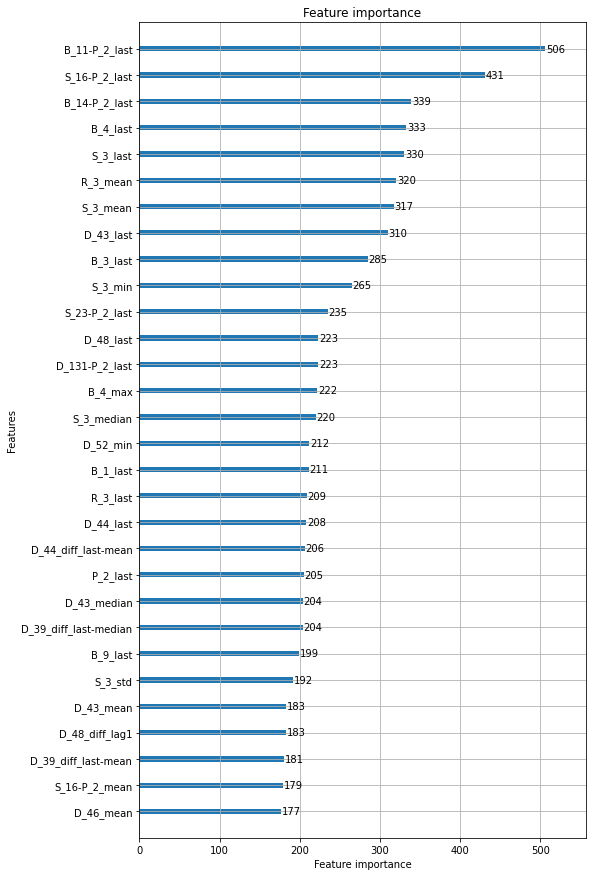

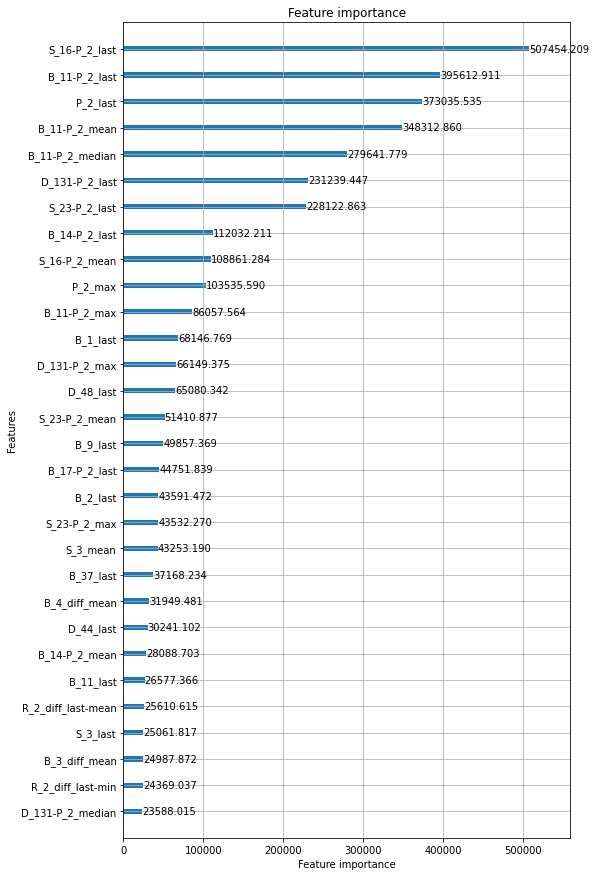

######################################## training model 5/5 ########################################


[50]	valid_0's amex_metric: 0.747616	valid_0's recall_at4: 0.596928	valid_0's norm_gini: 0.898304


[100]	valid_0's amex_metric: 0.758156	valid_0's recall_at4: 0.61153	valid_0's norm_gini: 0.904783


[150]	valid_0's amex_metric: 0.765484	valid_0's recall_at4: 0.62247	valid_0's norm_gini: 0.908498


[200]	valid_0's amex_metric: 0.772228	valid_0's recall_at4: 0.632316	valid_0's norm_gini: 0.91214


[250]	valid_0's amex_metric: 0.774714	valid_0's recall_at4: 0.635052	valid_0's norm_gini: 0.914377


[300]	valid_0's amex_metric: 0.777289	valid_0's recall_at4: 0.638754	valid_0's norm_gini: 0.915823


[350]	valid_0's amex_metric: 0.780087	valid_0's recall_at4: 0.643299	valid_0's norm_gini: 0.916875


[400]	valid_0's amex_metric: 0.780772	valid_0's recall_at4: 0.643804	valid_0's norm_gini: 0.91774


[450]	valid_0's amex_metric: 0.78254	valid_0's recall_at4: 0.646749	valid_0's norm_gini: 0.91833


[500]	valid_0's amex_metric: 0.783985	valid_0's recall_at4: 0.649148	valid_0's norm_gini: 0.918822


[550]	valid_0's amex_metric: 0.785016	valid_0's recall_at4: 0.650789	valid_0's norm_gini: 0.919243


[600]	valid_0's amex_metric: 0.785586	valid_0's recall_at4: 0.651673	valid_0's norm_gini: 0.919499


[650]	valid_0's amex_metric: 0.785957	valid_0's recall_at4: 0.652135	valid_0's norm_gini: 0.919779


[700]	valid_0's amex_metric: 0.786376	valid_0's recall_at4: 0.652725	valid_0's norm_gini: 0.920028


[750]	valid_0's amex_metric: 0.786242	valid_0's recall_at4: 0.65222	valid_0's norm_gini: 0.920264


[800]	valid_0's amex_metric: 0.786851	valid_0's recall_at4: 0.653272	valid_0's norm_gini: 0.92043


[850]	valid_0's amex_metric: 0.787287	valid_0's recall_at4: 0.653903	valid_0's norm_gini: 0.92067


[900]	valid_0's amex_metric: 0.788271	valid_0's recall_at4: 0.655712	valid_0's norm_gini: 0.92083


[950]	valid_0's amex_metric: 0.788864	valid_0's recall_at4: 0.656722	valid_0's norm_gini: 0.921006


[1000]	valid_0's amex_metric: 0.789011	valid_0's recall_at4: 0.656806	valid_0's norm_gini: 0.921215


[1050]	valid_0's amex_metric: 0.7897	valid_0's recall_at4: 0.657984	valid_0's norm_gini: 0.921415


[1100]	valid_0's amex_metric: 0.789221	valid_0's recall_at4: 0.656806	valid_0's norm_gini: 0.921636


[1150]	valid_0's amex_metric: 0.789733	valid_0's recall_at4: 0.657732	valid_0's norm_gini: 0.921733


[1200]	valid_0's amex_metric: 0.789816	valid_0's recall_at4: 0.657774	valid_0's norm_gini: 0.921858


[1250]	valid_0's amex_metric: 0.790465	valid_0's recall_at4: 0.658952	valid_0's norm_gini: 0.921977


[1300]	valid_0's amex_metric: 0.790893	valid_0's recall_at4: 0.65971	valid_0's norm_gini: 0.922076


[1350]	valid_0's amex_metric: 0.790875	valid_0's recall_at4: 0.659625	valid_0's norm_gini: 0.922124


[1400]	valid_0's amex_metric: 0.790567	valid_0's recall_at4: 0.658952	valid_0's norm_gini: 0.922182


[1450]	valid_0's amex_metric: 0.790779	valid_0's recall_at4: 0.659331	valid_0's norm_gini: 0.922226


[1500]	valid_0's amex_metric: 0.791057	valid_0's recall_at4: 0.659794	valid_0's norm_gini: 0.92232


[1550]	valid_0's amex_metric: 0.791866	valid_0's recall_at4: 0.661351	valid_0's norm_gini: 0.922381


[1600]	valid_0's amex_metric: 0.792128	valid_0's recall_at4: 0.661814	valid_0's norm_gini: 0.922443


[1650]	valid_0's amex_metric: 0.79199	valid_0's recall_at4: 0.661477	valid_0's norm_gini: 0.922502


[1700]	valid_0's amex_metric: 0.792197	valid_0's recall_at4: 0.661856	valid_0's norm_gini: 0.922538


[1750]	valid_0's amex_metric: 0.791892	valid_0's recall_at4: 0.661182	valid_0's norm_gini: 0.922602


[1800]	valid_0's amex_metric: 0.79183	valid_0's recall_at4: 0.661014	valid_0's norm_gini: 0.922646


[1850]	valid_0's amex_metric: 0.792436	valid_0's recall_at4: 0.662192	valid_0's norm_gini: 0.922679


[1900]	valid_0's amex_metric: 0.792825	valid_0's recall_at4: 0.66295	valid_0's norm_gini: 0.9227


[1950]	valid_0's amex_metric: 0.792457	valid_0's recall_at4: 0.662192	valid_0's norm_gini: 0.922721


[2000]	valid_0's amex_metric: 0.792953	valid_0's recall_at4: 0.66316	valid_0's norm_gini: 0.922745


[2050]	valid_0's amex_metric: 0.792957	valid_0's recall_at4: 0.663118	valid_0's norm_gini: 0.922797


[2100]	valid_0's amex_metric: 0.792807	valid_0's recall_at4: 0.662781	valid_0's norm_gini: 0.922832


[2150]	valid_0's amex_metric: 0.792742	valid_0's recall_at4: 0.662613	valid_0's norm_gini: 0.92287


[2200]	valid_0's amex_metric: 0.793111	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.922893


[2250]	valid_0's amex_metric: 0.79328	valid_0's recall_at4: 0.663623	valid_0's norm_gini: 0.922938


[2300]	valid_0's amex_metric: 0.792987	valid_0's recall_at4: 0.663034	valid_0's norm_gini: 0.922939


[2350]	valid_0's amex_metric: 0.79319	valid_0's recall_at4: 0.663413	valid_0's norm_gini: 0.922968


[2400]	valid_0's amex_metric: 0.793048	valid_0's recall_at4: 0.663118	valid_0's norm_gini: 0.922977


[2450]	valid_0's amex_metric: 0.793058	valid_0's recall_at4: 0.663118	valid_0's norm_gini: 0.922997


[2500]	valid_0's amex_metric: 0.792872	valid_0's recall_at4: 0.662739	valid_0's norm_gini: 0.923005


[2550]	valid_0's amex_metric: 0.792786	valid_0's recall_at4: 0.662571	valid_0's norm_gini: 0.923001


[2600]	valid_0's amex_metric: 0.792981	valid_0's recall_at4: 0.66295	valid_0's norm_gini: 0.923012


[2650]	valid_0's amex_metric: 0.793273	valid_0's recall_at4: 0.663497	valid_0's norm_gini: 0.923049


[2700]	valid_0's amex_metric: 0.793795	valid_0's recall_at4: 0.664549	valid_0's norm_gini: 0.923041


[2750]	valid_0's amex_metric: 0.793231	valid_0's recall_at4: 0.663413	valid_0's norm_gini: 0.92305


[2800]	valid_0's amex_metric: 0.79318	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.923032


[2850]	valid_0's amex_metric: 0.79366	valid_0's recall_at4: 0.664296	valid_0's norm_gini: 0.923023


[2900]	valid_0's amex_metric: 0.793895	valid_0's recall_at4: 0.664759	valid_0's norm_gini: 0.92303


[2950]	valid_0's amex_metric: 0.793987	valid_0's recall_at4: 0.664927	valid_0's norm_gini: 0.923046


[3000]	valid_0's amex_metric: 0.793763	valid_0's recall_at4: 0.664465	valid_0's norm_gini: 0.923062


[3050]	valid_0's amex_metric: 0.793941	valid_0's recall_at4: 0.664801	valid_0's norm_gini: 0.923081


[3100]	valid_0's amex_metric: 0.793754	valid_0's recall_at4: 0.664422	valid_0's norm_gini: 0.923085


[3150]	valid_0's amex_metric: 0.794391	valid_0's recall_at4: 0.665685	valid_0's norm_gini: 0.923098


[3200]	valid_0's amex_metric: 0.794504	valid_0's recall_at4: 0.665895	valid_0's norm_gini: 0.923114


[3250]	valid_0's amex_metric: 0.794531	valid_0's recall_at4: 0.665937	valid_0's norm_gini: 0.923125


[3300]	valid_0's amex_metric: 0.794559	valid_0's recall_at4: 0.665979	valid_0's norm_gini: 0.923138


[3350]	valid_0's amex_metric: 0.794197	valid_0's recall_at4: 0.665264	valid_0's norm_gini: 0.923129


[3400]	valid_0's amex_metric: 0.794051	valid_0's recall_at4: 0.66497	valid_0's norm_gini: 0.923133


[3450]	valid_0's amex_metric: 0.793784	valid_0's recall_at4: 0.664422	valid_0's norm_gini: 0.923145


[3500]	valid_0's amex_metric: 0.793895	valid_0's recall_at4: 0.664633	valid_0's norm_gini: 0.923158


[3550]	valid_0's amex_metric: 0.793981	valid_0's recall_at4: 0.664801	valid_0's norm_gini: 0.923161


[3600]	valid_0's amex_metric: 0.794322	valid_0's recall_at4: 0.665474	valid_0's norm_gini: 0.923169


[3650]	valid_0's amex_metric: 0.794535	valid_0's recall_at4: 0.665895	valid_0's norm_gini: 0.923175


[3700]	valid_0's amex_metric: 0.794461	valid_0's recall_at4: 0.665727	valid_0's norm_gini: 0.923195


[3750]	valid_0's amex_metric: 0.794761	valid_0's recall_at4: 0.666316	valid_0's norm_gini: 0.923206


[3800]	valid_0's amex_metric: 0.794448	valid_0's recall_at4: 0.665685	valid_0's norm_gini: 0.923212


[3850]	valid_0's amex_metric: 0.794514	valid_0's recall_at4: 0.665811	valid_0's norm_gini: 0.923217


[3900]	valid_0's amex_metric: 0.794597	valid_0's recall_at4: 0.665979	valid_0's norm_gini: 0.923214


[3950]	valid_0's amex_metric: 0.794786	valid_0's recall_at4: 0.666358	valid_0's norm_gini: 0.923215


[4000]	valid_0's amex_metric: 0.795121	valid_0's recall_at4: 0.667031	valid_0's norm_gini: 0.923211


[4050]	valid_0's amex_metric: 0.794958	valid_0's recall_at4: 0.666695	valid_0's norm_gini: 0.923222


[4100]	valid_0's amex_metric: 0.794874	valid_0's recall_at4: 0.666526	valid_0's norm_gini: 0.923222


[4150]	valid_0's amex_metric: 0.795178	valid_0's recall_at4: 0.667116	valid_0's norm_gini: 0.92324


[4200]	valid_0's amex_metric: 0.794527	valid_0's recall_at4: 0.665811	valid_0's norm_gini: 0.923242


[4250]	valid_0's amex_metric: 0.794413	valid_0's recall_at4: 0.665601	valid_0's norm_gini: 0.923226


[4300]	valid_0's amex_metric: 0.794534	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.923215


[4350]	valid_0's amex_metric: 0.794535	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.923216


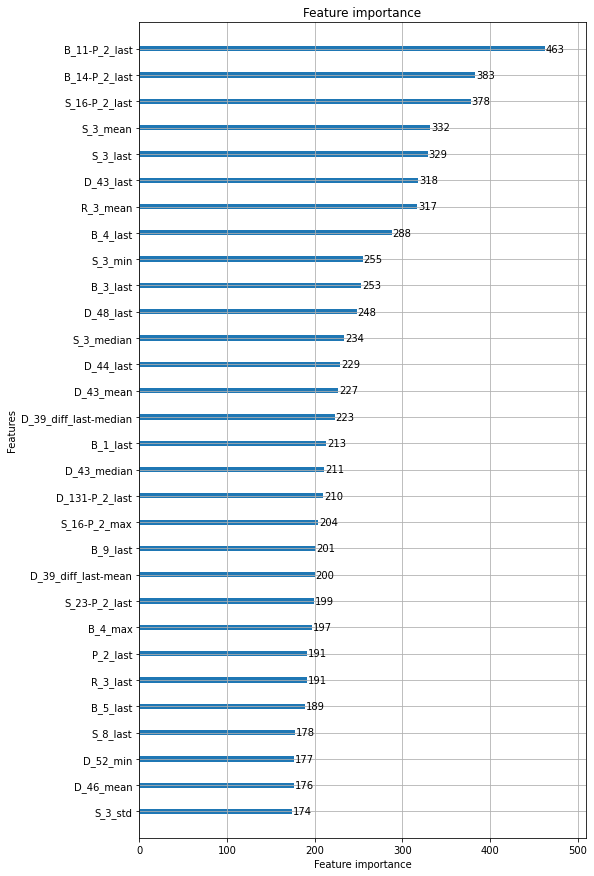

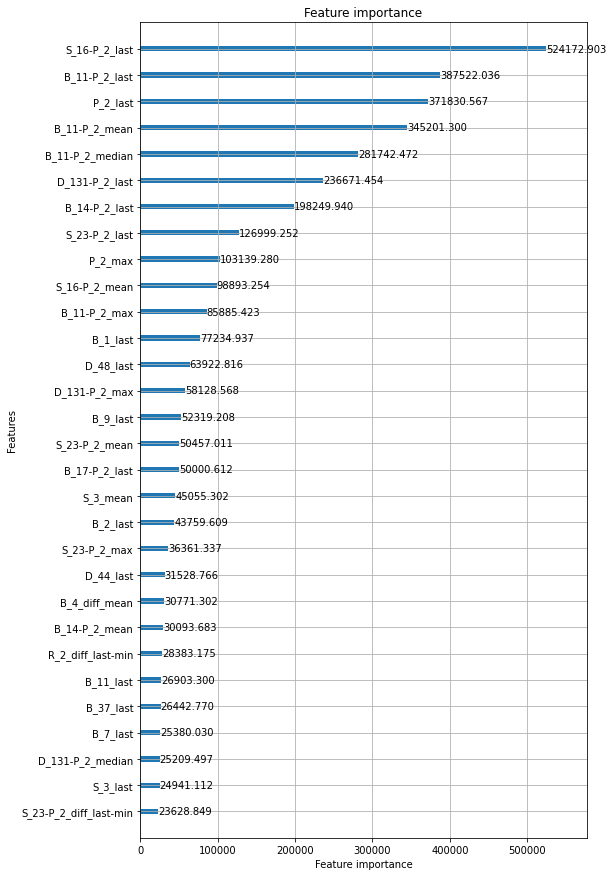

Training time: 39.60963479677836 min.
OOF recall_at4: 0.6601979331470698
OOF normalized_gini: 0.9229355720765944
OOF competition metric: 0.7915667526118321


############################### repeated cross-validation step: 3/3 ################################


######################################## training model 1/5 ########################################


[50]	valid_0's amex_metric: 0.743851	valid_0's recall_at4: 0.592233	valid_0's norm_gini: 0.895469


[100]	valid_0's amex_metric: 0.753607	valid_0's recall_at4: 0.605108	valid_0's norm_gini: 0.902106


[150]	valid_0's amex_metric: 0.761228	valid_0's recall_at4: 0.616343	valid_0's norm_gini: 0.906114


[200]	valid_0's amex_metric: 0.768139	valid_0's recall_at4: 0.626273	valid_0's norm_gini: 0.910006


[250]	valid_0's amex_metric: 0.771727	valid_0's recall_at4: 0.630985	valid_0's norm_gini: 0.912468


[300]	valid_0's amex_metric: 0.774811	valid_0's recall_at4: 0.63553	valid_0's norm_gini: 0.914093


[350]	valid_0's amex_metric: 0.776967	valid_0's recall_at4: 0.638728	valid_0's norm_gini: 0.915206


[400]	valid_0's amex_metric: 0.778549	valid_0's recall_at4: 0.641	valid_0's norm_gini: 0.916098


[450]	valid_0's amex_metric: 0.779861	valid_0's recall_at4: 0.642935	valid_0's norm_gini: 0.916786


[500]	valid_0's amex_metric: 0.780571	valid_0's recall_at4: 0.643861	valid_0's norm_gini: 0.917281


[550]	valid_0's amex_metric: 0.781553	valid_0's recall_at4: 0.645418	valid_0's norm_gini: 0.917689


[600]	valid_0's amex_metric: 0.782222	valid_0's recall_at4: 0.64647	valid_0's norm_gini: 0.917975


[650]	valid_0's amex_metric: 0.782612	valid_0's recall_at4: 0.646975	valid_0's norm_gini: 0.918249


[700]	valid_0's amex_metric: 0.783075	valid_0's recall_at4: 0.647606	valid_0's norm_gini: 0.918544


[750]	valid_0's amex_metric: 0.783374	valid_0's recall_at4: 0.647985	valid_0's norm_gini: 0.918763


[800]	valid_0's amex_metric: 0.783733	valid_0's recall_at4: 0.648531	valid_0's norm_gini: 0.918934


[850]	valid_0's amex_metric: 0.784358	valid_0's recall_at4: 0.649541	valid_0's norm_gini: 0.919175


[900]	valid_0's amex_metric: 0.784839	valid_0's recall_at4: 0.650341	valid_0's norm_gini: 0.919338


[950]	valid_0's amex_metric: 0.785086	valid_0's recall_at4: 0.650677	valid_0's norm_gini: 0.919494


[1000]	valid_0's amex_metric: 0.7859	valid_0's recall_at4: 0.652108	valid_0's norm_gini: 0.919692


[1050]	valid_0's amex_metric: 0.78619	valid_0's recall_at4: 0.652487	valid_0's norm_gini: 0.919892


[1100]	valid_0's amex_metric: 0.786459	valid_0's recall_at4: 0.652823	valid_0's norm_gini: 0.920094


[1150]	valid_0's amex_metric: 0.78685	valid_0's recall_at4: 0.653497	valid_0's norm_gini: 0.920204


[1200]	valid_0's amex_metric: 0.787296	valid_0's recall_at4: 0.654296	valid_0's norm_gini: 0.920295


[1250]	valid_0's amex_metric: 0.787473	valid_0's recall_at4: 0.654549	valid_0's norm_gini: 0.920398


[1300]	valid_0's amex_metric: 0.787993	valid_0's recall_at4: 0.655516	valid_0's norm_gini: 0.920469


[1350]	valid_0's amex_metric: 0.788459	valid_0's recall_at4: 0.6564	valid_0's norm_gini: 0.920519


[1400]	valid_0's amex_metric: 0.788711	valid_0's recall_at4: 0.656863	valid_0's norm_gini: 0.920558


[1450]	valid_0's amex_metric: 0.788636	valid_0's recall_at4: 0.656652	valid_0's norm_gini: 0.92062


[1500]	valid_0's amex_metric: 0.788571	valid_0's recall_at4: 0.656442	valid_0's norm_gini: 0.9207


[1550]	valid_0's amex_metric: 0.78841	valid_0's recall_at4: 0.656063	valid_0's norm_gini: 0.920757


[1600]	valid_0's amex_metric: 0.789264	valid_0's recall_at4: 0.657746	valid_0's norm_gini: 0.920782


[1650]	valid_0's amex_metric: 0.789298	valid_0's recall_at4: 0.657746	valid_0's norm_gini: 0.92085


[1700]	valid_0's amex_metric: 0.789419	valid_0's recall_at4: 0.657957	valid_0's norm_gini: 0.920882


[1750]	valid_0's amex_metric: 0.78996	valid_0's recall_at4: 0.658967	valid_0's norm_gini: 0.920954


[1800]	valid_0's amex_metric: 0.78951	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.92098


[1850]	valid_0's amex_metric: 0.789933	valid_0's recall_at4: 0.65884	valid_0's norm_gini: 0.921026


[1900]	valid_0's amex_metric: 0.789688	valid_0's recall_at4: 0.658335	valid_0's norm_gini: 0.921041


[1950]	valid_0's amex_metric: 0.789837	valid_0's recall_at4: 0.65863	valid_0's norm_gini: 0.921043


[2000]	valid_0's amex_metric: 0.790162	valid_0's recall_at4: 0.659261	valid_0's norm_gini: 0.921063


[2050]	valid_0's amex_metric: 0.790406	valid_0's recall_at4: 0.659724	valid_0's norm_gini: 0.921088


[2100]	valid_0's amex_metric: 0.789937	valid_0's recall_at4: 0.658756	valid_0's norm_gini: 0.921118


[2150]	valid_0's amex_metric: 0.789838	valid_0's recall_at4: 0.658546	valid_0's norm_gini: 0.92113


[2200]	valid_0's amex_metric: 0.789769	valid_0's recall_at4: 0.658378	valid_0's norm_gini: 0.92116


[2250]	valid_0's amex_metric: 0.789867	valid_0's recall_at4: 0.658546	valid_0's norm_gini: 0.921188


[2300]	valid_0's amex_metric: 0.789739	valid_0's recall_at4: 0.658293	valid_0's norm_gini: 0.921185


[2350]	valid_0's amex_metric: 0.790497	valid_0's recall_at4: 0.659808	valid_0's norm_gini: 0.921186


[2400]	valid_0's amex_metric: 0.789725	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.921198


[2450]	valid_0's amex_metric: 0.789689	valid_0's recall_at4: 0.658167	valid_0's norm_gini: 0.921211


[2500]	valid_0's amex_metric: 0.789349	valid_0's recall_at4: 0.657494	valid_0's norm_gini: 0.921205


[2550]	valid_0's amex_metric: 0.789308	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.921205


[2600]	valid_0's amex_metric: 0.789348	valid_0's recall_at4: 0.657494	valid_0's norm_gini: 0.921202


[2650]	valid_0's amex_metric: 0.789485	valid_0's recall_at4: 0.657746	valid_0's norm_gini: 0.921224


[2700]	valid_0's amex_metric: 0.789513	valid_0's recall_at4: 0.657788	valid_0's norm_gini: 0.921238


[2750]	valid_0's amex_metric: 0.78982	valid_0's recall_at4: 0.65842	valid_0's norm_gini: 0.92122


[2800]	valid_0's amex_metric: 0.789846	valid_0's recall_at4: 0.658462	valid_0's norm_gini: 0.921231


[2850]	valid_0's amex_metric: 0.78988	valid_0's recall_at4: 0.658504	valid_0's norm_gini: 0.921256


[2900]	valid_0's amex_metric: 0.789419	valid_0's recall_at4: 0.657578	valid_0's norm_gini: 0.921259


[2950]	valid_0's amex_metric: 0.789515	valid_0's recall_at4: 0.657746	valid_0's norm_gini: 0.921284


[3000]	valid_0's amex_metric: 0.789769	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.921288


[3050]	valid_0's amex_metric: 0.789535	valid_0's recall_at4: 0.657788	valid_0's norm_gini: 0.921281


[3100]	valid_0's amex_metric: 0.789575	valid_0's recall_at4: 0.657873	valid_0's norm_gini: 0.921277


[3150]	valid_0's amex_metric: 0.789643	valid_0's recall_at4: 0.657999	valid_0's norm_gini: 0.921288


[3200]	valid_0's amex_metric: 0.78934	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.92127


[3250]	valid_0's amex_metric: 0.789484	valid_0's recall_at4: 0.657704	valid_0's norm_gini: 0.921264


[3300]	valid_0's amex_metric: 0.789305	valid_0's recall_at4: 0.657326	valid_0's norm_gini: 0.921285


[3350]	valid_0's amex_metric: 0.789352	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.921295


[3400]	valid_0's amex_metric: 0.789286	valid_0's recall_at4: 0.657283	valid_0's norm_gini: 0.921289


[3450]	valid_0's amex_metric: 0.789328	valid_0's recall_at4: 0.657368	valid_0's norm_gini: 0.921289


[3500]	valid_0's amex_metric: 0.789557	valid_0's recall_at4: 0.657831	valid_0's norm_gini: 0.921283


[3550]	valid_0's amex_metric: 0.789394	valid_0's recall_at4: 0.657494	valid_0's norm_gini: 0.921295


[3600]	valid_0's amex_metric: 0.789162	valid_0's recall_at4: 0.657031	valid_0's norm_gini: 0.921293


[3650]	valid_0's amex_metric: 0.78965	valid_0's recall_at4: 0.657999	valid_0's norm_gini: 0.921301


[3700]	valid_0's amex_metric: 0.789546	valid_0's recall_at4: 0.657788	valid_0's norm_gini: 0.921303


[3750]	valid_0's amex_metric: 0.789387	valid_0's recall_at4: 0.657494	valid_0's norm_gini: 0.921281


[3800]	valid_0's amex_metric: 0.789593	valid_0's recall_at4: 0.657915	valid_0's norm_gini: 0.921271


[3850]	valid_0's amex_metric: 0.789447	valid_0's recall_at4: 0.65762	valid_0's norm_gini: 0.921274


[3900]	valid_0's amex_metric: 0.789425	valid_0's recall_at4: 0.657578	valid_0's norm_gini: 0.921273


[3950]	valid_0's amex_metric: 0.789317	valid_0's recall_at4: 0.657368	valid_0's norm_gini: 0.921266


[4000]	valid_0's amex_metric: 0.78945	valid_0's recall_at4: 0.65762	valid_0's norm_gini: 0.921279


[4050]	valid_0's amex_metric: 0.78965	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.921259


[4100]	valid_0's amex_metric: 0.789489	valid_0's recall_at4: 0.657704	valid_0's norm_gini: 0.921273


[4150]	valid_0's amex_metric: 0.789547	valid_0's recall_at4: 0.657831	valid_0's norm_gini: 0.921263


[4200]	valid_0's amex_metric: 0.789794	valid_0's recall_at4: 0.658335	valid_0's norm_gini: 0.921253


[4250]	valid_0's amex_metric: 0.789651	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.921262


[4300]	valid_0's amex_metric: 0.789696	valid_0's recall_at4: 0.658125	valid_0's norm_gini: 0.921267


[4350]	valid_0's amex_metric: 0.789743	valid_0's recall_at4: 0.658209	valid_0's norm_gini: 0.921276


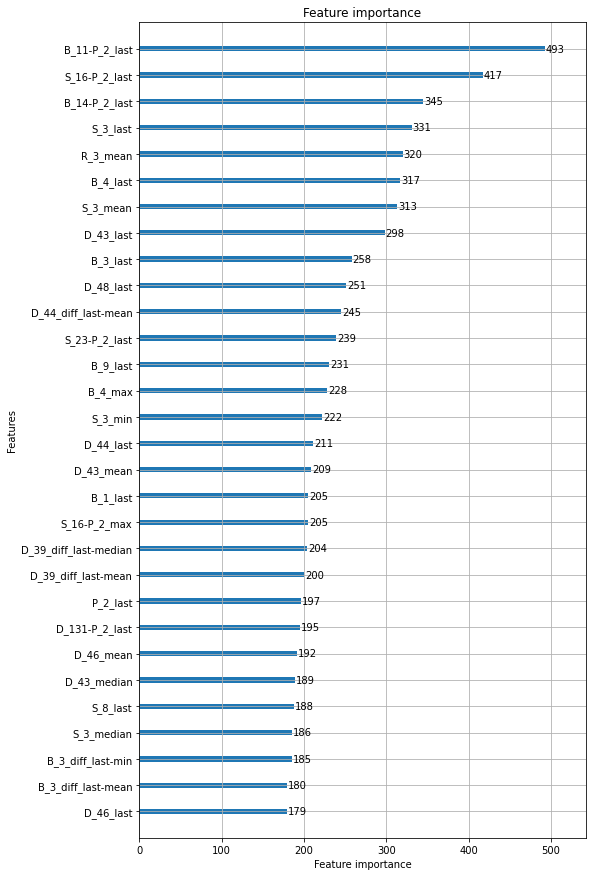

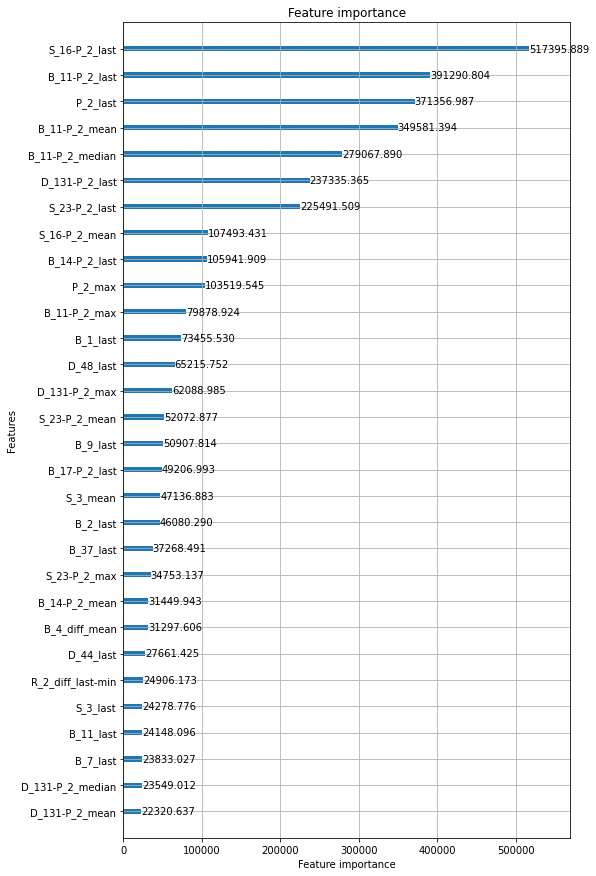

######################################## training model 2/5 ########################################


[50]	valid_0's amex_metric: 0.746075	valid_0's recall_at4: 0.594926	valid_0's norm_gini: 0.897225


[100]	valid_0's amex_metric: 0.754767	valid_0's recall_at4: 0.605739	valid_0's norm_gini: 0.903795


[150]	valid_0's amex_metric: 0.760494	valid_0's recall_at4: 0.61365	valid_0's norm_gini: 0.907339


[200]	valid_0's amex_metric: 0.76526	valid_0's recall_at4: 0.619583	valid_0's norm_gini: 0.910938


[250]	valid_0's amex_metric: 0.769844	valid_0's recall_at4: 0.626273	valid_0's norm_gini: 0.913414


[300]	valid_0's amex_metric: 0.773551	valid_0's recall_at4: 0.632164	valid_0's norm_gini: 0.914939


[350]	valid_0's amex_metric: 0.775505	valid_0's recall_at4: 0.634941	valid_0's norm_gini: 0.91607


[400]	valid_0's amex_metric: 0.776828	valid_0's recall_at4: 0.636708	valid_0's norm_gini: 0.916947


[450]	valid_0's amex_metric: 0.777409	valid_0's recall_at4: 0.637213	valid_0's norm_gini: 0.917604


[500]	valid_0's amex_metric: 0.777755	valid_0's recall_at4: 0.637381	valid_0's norm_gini: 0.918129


[550]	valid_0's amex_metric: 0.778361	valid_0's recall_at4: 0.638181	valid_0's norm_gini: 0.918541


[600]	valid_0's amex_metric: 0.778896	valid_0's recall_at4: 0.638896	valid_0's norm_gini: 0.918897


[650]	valid_0's amex_metric: 0.779495	valid_0's recall_at4: 0.639737	valid_0's norm_gini: 0.919253


[700]	valid_0's amex_metric: 0.780494	valid_0's recall_at4: 0.641421	valid_0's norm_gini: 0.919568


[750]	valid_0's amex_metric: 0.781381	valid_0's recall_at4: 0.642977	valid_0's norm_gini: 0.919785


[800]	valid_0's amex_metric: 0.781267	valid_0's recall_at4: 0.642557	valid_0's norm_gini: 0.919978


[850]	valid_0's amex_metric: 0.781742	valid_0's recall_at4: 0.64323	valid_0's norm_gini: 0.920254


[900]	valid_0's amex_metric: 0.781104	valid_0's recall_at4: 0.641799	valid_0's norm_gini: 0.920408


[950]	valid_0's amex_metric: 0.781626	valid_0's recall_at4: 0.642641	valid_0's norm_gini: 0.920611


[1000]	valid_0's amex_metric: 0.782573	valid_0's recall_at4: 0.644366	valid_0's norm_gini: 0.92078


[1050]	valid_0's amex_metric: 0.783737	valid_0's recall_at4: 0.64647	valid_0's norm_gini: 0.921004


[1100]	valid_0's amex_metric: 0.783828	valid_0's recall_at4: 0.646428	valid_0's norm_gini: 0.921228


[1150]	valid_0's amex_metric: 0.784252	valid_0's recall_at4: 0.647143	valid_0's norm_gini: 0.921361


[1200]	valid_0's amex_metric: 0.784513	valid_0's recall_at4: 0.647522	valid_0's norm_gini: 0.921505


[1250]	valid_0's amex_metric: 0.784889	valid_0's recall_at4: 0.648153	valid_0's norm_gini: 0.921625


[1300]	valid_0's amex_metric: 0.784936	valid_0's recall_at4: 0.648153	valid_0's norm_gini: 0.921719


[1350]	valid_0's amex_metric: 0.784634	valid_0's recall_at4: 0.64748	valid_0's norm_gini: 0.921789


[1400]	valid_0's amex_metric: 0.785018	valid_0's recall_at4: 0.648153	valid_0's norm_gini: 0.921883


[1450]	valid_0's amex_metric: 0.785012	valid_0's recall_at4: 0.648069	valid_0's norm_gini: 0.921956


[1500]	valid_0's amex_metric: 0.784983	valid_0's recall_at4: 0.6479	valid_0's norm_gini: 0.922067


[1550]	valid_0's amex_metric: 0.78578	valid_0's recall_at4: 0.649415	valid_0's norm_gini: 0.922145


[1600]	valid_0's amex_metric: 0.786046	valid_0's recall_at4: 0.649878	valid_0's norm_gini: 0.922214


[1650]	valid_0's amex_metric: 0.786419	valid_0's recall_at4: 0.650551	valid_0's norm_gini: 0.922286


[1700]	valid_0's amex_metric: 0.786165	valid_0's recall_at4: 0.650004	valid_0's norm_gini: 0.922325


[1750]	valid_0's amex_metric: 0.786677	valid_0's recall_at4: 0.650972	valid_0's norm_gini: 0.922383


[1800]	valid_0's amex_metric: 0.786356	valid_0's recall_at4: 0.650257	valid_0's norm_gini: 0.922455


[1850]	valid_0's amex_metric: 0.78687	valid_0's recall_at4: 0.651224	valid_0's norm_gini: 0.922515


[1900]	valid_0's amex_metric: 0.786953	valid_0's recall_at4: 0.651351	valid_0's norm_gini: 0.922556


[1950]	valid_0's amex_metric: 0.786793	valid_0's recall_at4: 0.650972	valid_0's norm_gini: 0.922615


[2000]	valid_0's amex_metric: 0.786916	valid_0's recall_at4: 0.651182	valid_0's norm_gini: 0.922649


[2050]	valid_0's amex_metric: 0.786444	valid_0's recall_at4: 0.650215	valid_0's norm_gini: 0.922673


[2100]	valid_0's amex_metric: 0.7867	valid_0's recall_at4: 0.650677	valid_0's norm_gini: 0.922722


[2150]	valid_0's amex_metric: 0.786596	valid_0's recall_at4: 0.650425	valid_0's norm_gini: 0.922767


[2200]	valid_0's amex_metric: 0.787081	valid_0's recall_at4: 0.651351	valid_0's norm_gini: 0.922811


[2250]	valid_0's amex_metric: 0.786402	valid_0's recall_at4: 0.649962	valid_0's norm_gini: 0.922842


[2300]	valid_0's amex_metric: 0.786677	valid_0's recall_at4: 0.650509	valid_0's norm_gini: 0.922846


[2350]	valid_0's amex_metric: 0.786845	valid_0's recall_at4: 0.650846	valid_0's norm_gini: 0.922844


[2400]	valid_0's amex_metric: 0.78736	valid_0's recall_at4: 0.651856	valid_0's norm_gini: 0.922864


[2450]	valid_0's amex_metric: 0.787242	valid_0's recall_at4: 0.651603	valid_0's norm_gini: 0.922881


[2500]	valid_0's amex_metric: 0.787618	valid_0's recall_at4: 0.65236	valid_0's norm_gini: 0.922875


[2550]	valid_0's amex_metric: 0.787434	valid_0's recall_at4: 0.651982	valid_0's norm_gini: 0.922886


[2600]	valid_0's amex_metric: 0.787286	valid_0's recall_at4: 0.651687	valid_0's norm_gini: 0.922885


[2650]	valid_0's amex_metric: 0.787122	valid_0's recall_at4: 0.651351	valid_0's norm_gini: 0.922893


[2700]	valid_0's amex_metric: 0.787211	valid_0's recall_at4: 0.651519	valid_0's norm_gini: 0.922904


[2750]	valid_0's amex_metric: 0.787433	valid_0's recall_at4: 0.65194	valid_0's norm_gini: 0.922927


[2800]	valid_0's amex_metric: 0.787439	valid_0's recall_at4: 0.65194	valid_0's norm_gini: 0.922937


[2850]	valid_0's amex_metric: 0.787833	valid_0's recall_at4: 0.652697	valid_0's norm_gini: 0.922969


[2900]	valid_0's amex_metric: 0.787879	valid_0's recall_at4: 0.652781	valid_0's norm_gini: 0.922977


[2950]	valid_0's amex_metric: 0.788092	valid_0's recall_at4: 0.653202	valid_0's norm_gini: 0.922982


[3000]	valid_0's amex_metric: 0.788112	valid_0's recall_at4: 0.653202	valid_0's norm_gini: 0.923021


[3050]	valid_0's amex_metric: 0.788199	valid_0's recall_at4: 0.65337	valid_0's norm_gini: 0.923028


[3100]	valid_0's amex_metric: 0.787876	valid_0's recall_at4: 0.652739	valid_0's norm_gini: 0.923014


[3150]	valid_0's amex_metric: 0.788109	valid_0's recall_at4: 0.653202	valid_0's norm_gini: 0.923016


[3200]	valid_0's amex_metric: 0.78839	valid_0's recall_at4: 0.653749	valid_0's norm_gini: 0.923031


[3250]	valid_0's amex_metric: 0.788096	valid_0's recall_at4: 0.65316	valid_0's norm_gini: 0.923032


[3300]	valid_0's amex_metric: 0.788059	valid_0's recall_at4: 0.653076	valid_0's norm_gini: 0.923041


[3350]	valid_0's amex_metric: 0.7877	valid_0's recall_at4: 0.65236	valid_0's norm_gini: 0.923039


[3400]	valid_0's amex_metric: 0.787941	valid_0's recall_at4: 0.652823	valid_0's norm_gini: 0.923058


[3450]	valid_0's amex_metric: 0.787709	valid_0's recall_at4: 0.65236	valid_0's norm_gini: 0.923058


[3500]	valid_0's amex_metric: 0.787753	valid_0's recall_at4: 0.652445	valid_0's norm_gini: 0.923061


[3550]	valid_0's amex_metric: 0.788073	valid_0's recall_at4: 0.653076	valid_0's norm_gini: 0.923069


[3600]	valid_0's amex_metric: 0.78787	valid_0's recall_at4: 0.652655	valid_0's norm_gini: 0.923085


[3650]	valid_0's amex_metric: 0.787728	valid_0's recall_at4: 0.65236	valid_0's norm_gini: 0.923095


[3700]	valid_0's amex_metric: 0.787435	valid_0's recall_at4: 0.651771	valid_0's norm_gini: 0.923099


[3750]	valid_0's amex_metric: 0.787697	valid_0's recall_at4: 0.652276	valid_0's norm_gini: 0.923118


[3800]	valid_0's amex_metric: 0.787597	valid_0's recall_at4: 0.652066	valid_0's norm_gini: 0.923128


[3850]	valid_0's amex_metric: 0.787384	valid_0's recall_at4: 0.651645	valid_0's norm_gini: 0.923122


[3900]	valid_0's amex_metric: 0.787677	valid_0's recall_at4: 0.652234	valid_0's norm_gini: 0.92312


[3950]	valid_0's amex_metric: 0.787547	valid_0's recall_at4: 0.651982	valid_0's norm_gini: 0.923113


[4000]	valid_0's amex_metric: 0.787656	valid_0's recall_at4: 0.652192	valid_0's norm_gini: 0.923121


[4050]	valid_0's amex_metric: 0.787586	valid_0's recall_at4: 0.652066	valid_0's norm_gini: 0.923106


[4100]	valid_0's amex_metric: 0.787549	valid_0's recall_at4: 0.652024	valid_0's norm_gini: 0.923075


[4150]	valid_0's amex_metric: 0.787531	valid_0's recall_at4: 0.651982	valid_0's norm_gini: 0.923081


[4200]	valid_0's amex_metric: 0.787294	valid_0's recall_at4: 0.651519	valid_0's norm_gini: 0.923069


[4250]	valid_0's amex_metric: 0.787334	valid_0's recall_at4: 0.651603	valid_0's norm_gini: 0.923065


[4300]	valid_0's amex_metric: 0.787642	valid_0's recall_at4: 0.652192	valid_0's norm_gini: 0.923092


[4350]	valid_0's amex_metric: 0.787956	valid_0's recall_at4: 0.652823	valid_0's norm_gini: 0.923088


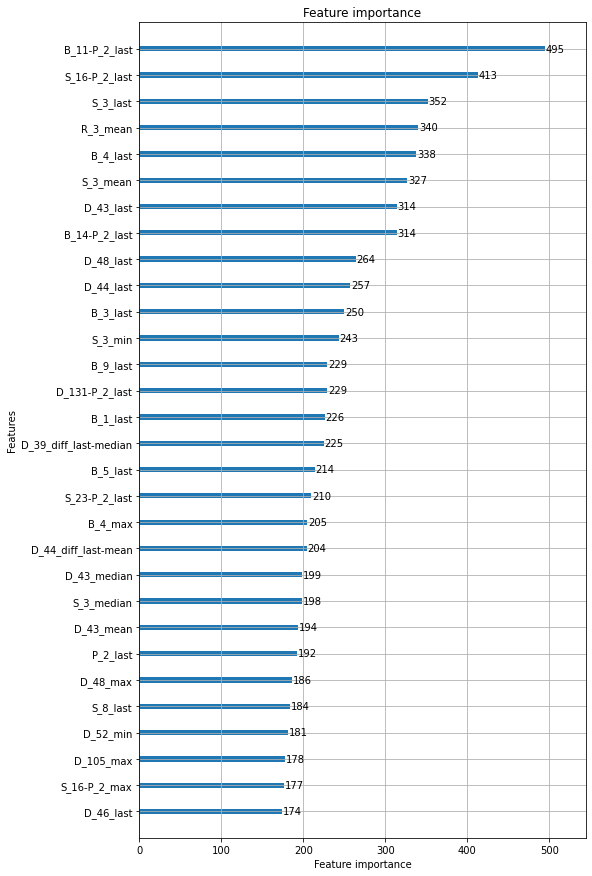

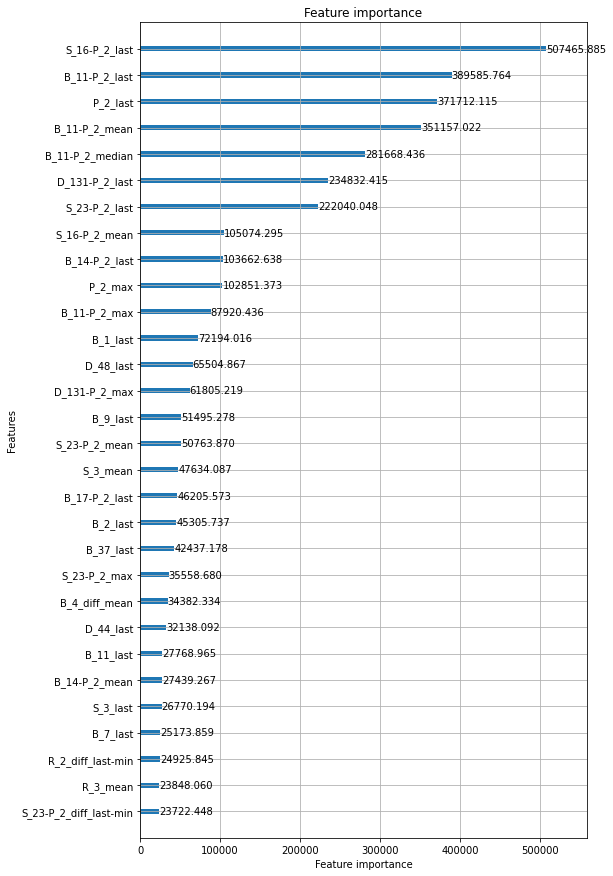

######################################## training model 3/5 ########################################


[50]	valid_0's amex_metric: 0.74585	valid_0's recall_at4: 0.595725	valid_0's norm_gini: 0.895974


[100]	valid_0's amex_metric: 0.757954	valid_0's recall_at4: 0.612808	valid_0's norm_gini: 0.9031


[150]	valid_0's amex_metric: 0.765536	valid_0's recall_at4: 0.623917	valid_0's norm_gini: 0.907156


[200]	valid_0's amex_metric: 0.770963	valid_0's recall_at4: 0.630943	valid_0's norm_gini: 0.910983


[250]	valid_0's amex_metric: 0.774459	valid_0's recall_at4: 0.635361	valid_0's norm_gini: 0.913556


[300]	valid_0's amex_metric: 0.777071	valid_0's recall_at4: 0.63898	valid_0's norm_gini: 0.915163


[350]	valid_0's amex_metric: 0.780294	valid_0's recall_at4: 0.64424	valid_0's norm_gini: 0.916349


[400]	valid_0's amex_metric: 0.781928	valid_0's recall_at4: 0.646512	valid_0's norm_gini: 0.917344


[450]	valid_0's amex_metric: 0.782786	valid_0's recall_at4: 0.647564	valid_0's norm_gini: 0.918008


[500]	valid_0's amex_metric: 0.783954	valid_0's recall_at4: 0.649331	valid_0's norm_gini: 0.918576


[550]	valid_0's amex_metric: 0.784429	valid_0's recall_at4: 0.649836	valid_0's norm_gini: 0.919022


[600]	valid_0's amex_metric: 0.785284	valid_0's recall_at4: 0.651267	valid_0's norm_gini: 0.919302


[650]	valid_0's amex_metric: 0.785498	valid_0's recall_at4: 0.651351	valid_0's norm_gini: 0.919645


[700]	valid_0's amex_metric: 0.785671	valid_0's recall_at4: 0.651393	valid_0's norm_gini: 0.919949


[750]	valid_0's amex_metric: 0.786091	valid_0's recall_at4: 0.652024	valid_0's norm_gini: 0.920158


[800]	valid_0's amex_metric: 0.786832	valid_0's recall_at4: 0.65337	valid_0's norm_gini: 0.920294


[850]	valid_0's amex_metric: 0.787627	valid_0's recall_at4: 0.654675	valid_0's norm_gini: 0.920579


[900]	valid_0's amex_metric: 0.788176	valid_0's recall_at4: 0.6556	valid_0's norm_gini: 0.920751


[950]	valid_0's amex_metric: 0.789037	valid_0's recall_at4: 0.657115	valid_0's norm_gini: 0.920959


[1000]	valid_0's amex_metric: 0.789806	valid_0's recall_at4: 0.658462	valid_0's norm_gini: 0.92115


[1050]	valid_0's amex_metric: 0.790712	valid_0's recall_at4: 0.660061	valid_0's norm_gini: 0.921363


[1100]	valid_0's amex_metric: 0.791515	valid_0's recall_at4: 0.661449	valid_0's norm_gini: 0.921581


[1150]	valid_0's amex_metric: 0.79172	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.921696


[1200]	valid_0's amex_metric: 0.791624	valid_0's recall_at4: 0.661449	valid_0's norm_gini: 0.921798


[1250]	valid_0's amex_metric: 0.79133	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.921885


[1300]	valid_0's amex_metric: 0.791709	valid_0's recall_at4: 0.661449	valid_0's norm_gini: 0.921969


[1350]	valid_0's amex_metric: 0.792231	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.922004


[1400]	valid_0's amex_metric: 0.7921	valid_0's recall_at4: 0.66208	valid_0's norm_gini: 0.922119


[1450]	valid_0's amex_metric: 0.791803	valid_0's recall_at4: 0.661449	valid_0's norm_gini: 0.922157


[1500]	valid_0's amex_metric: 0.79194	valid_0's recall_at4: 0.66166	valid_0's norm_gini: 0.92222


[1550]	valid_0's amex_metric: 0.792317	valid_0's recall_at4: 0.662333	valid_0's norm_gini: 0.9223


[1600]	valid_0's amex_metric: 0.791981	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.922344


[1650]	valid_0's amex_metric: 0.792418	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.922378


[1700]	valid_0's amex_metric: 0.791703	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.92242


[1750]	valid_0's amex_metric: 0.791719	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.922452


[1800]	valid_0's amex_metric: 0.79248	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.922502


[1850]	valid_0's amex_metric: 0.792127	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.922553


[1900]	valid_0's amex_metric: 0.792127	valid_0's recall_at4: 0.66166	valid_0's norm_gini: 0.922594


[1950]	valid_0's amex_metric: 0.792136	valid_0's recall_at4: 0.66166	valid_0's norm_gini: 0.922612


[2000]	valid_0's amex_metric: 0.79225	valid_0's recall_at4: 0.66187	valid_0's norm_gini: 0.922631


[2050]	valid_0's amex_metric: 0.792141	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.922664


[2100]	valid_0's amex_metric: 0.79224	valid_0's recall_at4: 0.661786	valid_0's norm_gini: 0.922694


[2150]	valid_0's amex_metric: 0.792281	valid_0's recall_at4: 0.661828	valid_0's norm_gini: 0.922735


[2200]	valid_0's amex_metric: 0.792376	valid_0's recall_at4: 0.661996	valid_0's norm_gini: 0.922756


[2250]	valid_0's amex_metric: 0.791863	valid_0's recall_at4: 0.660944	valid_0's norm_gini: 0.922781


[2300]	valid_0's amex_metric: 0.791673	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.92278


[2350]	valid_0's amex_metric: 0.791734	valid_0's recall_at4: 0.660692	valid_0's norm_gini: 0.922776


[2400]	valid_0's amex_metric: 0.79163	valid_0's recall_at4: 0.660481	valid_0's norm_gini: 0.922779


[2450]	valid_0's amex_metric: 0.79177	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.922765


[2500]	valid_0's amex_metric: 0.791582	valid_0's recall_at4: 0.660397	valid_0's norm_gini: 0.922768


[2550]	valid_0's amex_metric: 0.791714	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.922778


[2600]	valid_0's amex_metric: 0.791791	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.922806


[2650]	valid_0's amex_metric: 0.791923	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.922817


[2700]	valid_0's amex_metric: 0.791791	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.922805


[2750]	valid_0's amex_metric: 0.79169	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.922815


[2800]	valid_0's amex_metric: 0.79175	valid_0's recall_at4: 0.660692	valid_0's norm_gini: 0.922808


[2850]	valid_0's amex_metric: 0.792092	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.922818


[2900]	valid_0's amex_metric: 0.792216	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.922856


[2950]	valid_0's amex_metric: 0.791914	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.922843


[3000]	valid_0's amex_metric: 0.792277	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.922852


[3050]	valid_0's amex_metric: 0.792152	valid_0's recall_at4: 0.661449	valid_0's norm_gini: 0.922854


[3100]	valid_0's amex_metric: 0.792163	valid_0's recall_at4: 0.661491	valid_0's norm_gini: 0.922835


[3150]	valid_0's amex_metric: 0.79233	valid_0's recall_at4: 0.661828	valid_0's norm_gini: 0.922832


[3200]	valid_0's amex_metric: 0.792107	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.92285


[3250]	valid_0's amex_metric: 0.792288	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.922833


[3300]	valid_0's amex_metric: 0.792211	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.922846


[3350]	valid_0's amex_metric: 0.792072	valid_0's recall_at4: 0.661281	valid_0's norm_gini: 0.922863


[3400]	valid_0's amex_metric: 0.792524	valid_0's recall_at4: 0.662164	valid_0's norm_gini: 0.922884


[3450]	valid_0's amex_metric: 0.792329	valid_0's recall_at4: 0.661786	valid_0's norm_gini: 0.922872


[3500]	valid_0's amex_metric: 0.792087	valid_0's recall_at4: 0.661281	valid_0's norm_gini: 0.922893


[3550]	valid_0's amex_metric: 0.791942	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.922898


[3600]	valid_0's amex_metric: 0.792295	valid_0's recall_at4: 0.66166	valid_0's norm_gini: 0.92293


[3650]	valid_0's amex_metric: 0.792237	valid_0's recall_at4: 0.661533	valid_0's norm_gini: 0.922941


[3700]	valid_0's amex_metric: 0.792364	valid_0's recall_at4: 0.661786	valid_0's norm_gini: 0.922942


[3750]	valid_0's amex_metric: 0.792308	valid_0's recall_at4: 0.66166	valid_0's norm_gini: 0.922956


[3800]	valid_0's amex_metric: 0.792719	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.922979


[3850]	valid_0's amex_metric: 0.79229	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.922963


[3900]	valid_0's amex_metric: 0.792277	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.922936


[3950]	valid_0's amex_metric: 0.792382	valid_0's recall_at4: 0.661828	valid_0's norm_gini: 0.922937


[4000]	valid_0's amex_metric: 0.79256	valid_0's recall_at4: 0.662207	valid_0's norm_gini: 0.922913


[4050]	valid_0's amex_metric: 0.792687	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.922915


[4100]	valid_0's amex_metric: 0.792292	valid_0's recall_at4: 0.66166	valid_0's norm_gini: 0.922924


[4150]	valid_0's amex_metric: 0.791959	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.922931


[4200]	valid_0's amex_metric: 0.791873	valid_0's recall_at4: 0.660818	valid_0's norm_gini: 0.922928


[4250]	valid_0's amex_metric: 0.791744	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.922922


[4300]	valid_0's amex_metric: 0.791781	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.922912


[4350]	valid_0's amex_metric: 0.791547	valid_0's recall_at4: 0.660187	valid_0's norm_gini: 0.922907


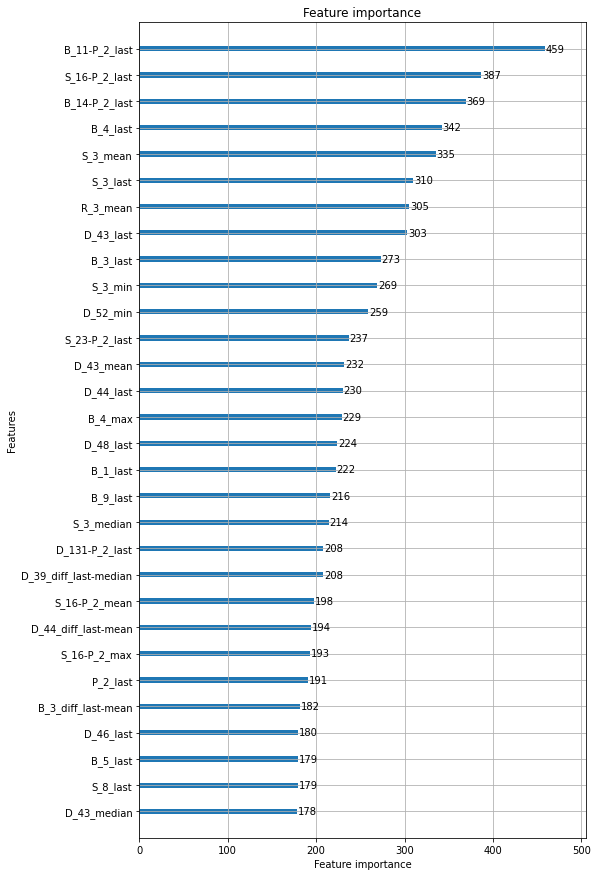

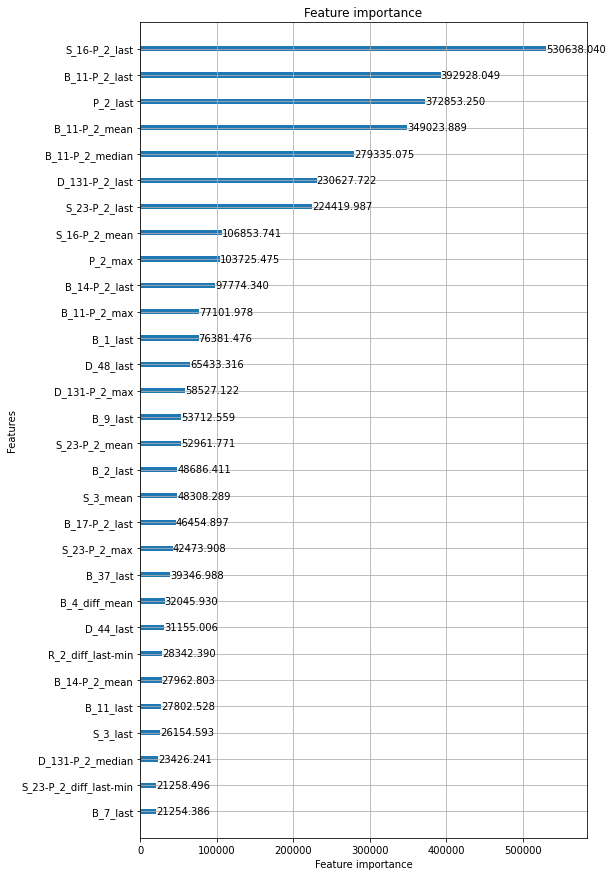

######################################## training model 4/5 ########################################


[50]	valid_0's amex_metric: 0.751094	valid_0's recall_at4: 0.601683	valid_0's norm_gini: 0.900506


[100]	valid_0's amex_metric: 0.762204	valid_0's recall_at4: 0.617505	valid_0's norm_gini: 0.906903


[150]	valid_0's amex_metric: 0.768227	valid_0's recall_at4: 0.625963	valid_0's norm_gini: 0.910491


[200]	valid_0's amex_metric: 0.775748	valid_0's recall_at4: 0.637198	valid_0's norm_gini: 0.914298


[250]	valid_0's amex_metric: 0.778828	valid_0's recall_at4: 0.640985	valid_0's norm_gini: 0.91667


[300]	valid_0's amex_metric: 0.783294	valid_0's recall_at4: 0.648348	valid_0's norm_gini: 0.918239


[350]	valid_0's amex_metric: 0.785469	valid_0's recall_at4: 0.651588	valid_0's norm_gini: 0.91935


[400]	valid_0's amex_metric: 0.786508	valid_0's recall_at4: 0.652809	valid_0's norm_gini: 0.920208


[450]	valid_0's amex_metric: 0.787335	valid_0's recall_at4: 0.653819	valid_0's norm_gini: 0.920852


[500]	valid_0's amex_metric: 0.78854	valid_0's recall_at4: 0.655754	valid_0's norm_gini: 0.921325


[550]	valid_0's amex_metric: 0.7896	valid_0's recall_at4: 0.657437	valid_0's norm_gini: 0.921763


[600]	valid_0's amex_metric: 0.790381	valid_0's recall_at4: 0.658742	valid_0's norm_gini: 0.922021


[650]	valid_0's amex_metric: 0.791522	valid_0's recall_at4: 0.66072	valid_0's norm_gini: 0.922325


[700]	valid_0's amex_metric: 0.791892	valid_0's recall_at4: 0.661182	valid_0's norm_gini: 0.922601


[750]	valid_0's amex_metric: 0.792358	valid_0's recall_at4: 0.661898	valid_0's norm_gini: 0.922818


[800]	valid_0's amex_metric: 0.792708	valid_0's recall_at4: 0.662403	valid_0's norm_gini: 0.923013


[850]	valid_0's amex_metric: 0.792087	valid_0's recall_at4: 0.660888	valid_0's norm_gini: 0.923285


[900]	valid_0's amex_metric: 0.793036	valid_0's recall_at4: 0.662655	valid_0's norm_gini: 0.923417


[950]	valid_0's amex_metric: 0.793612	valid_0's recall_at4: 0.663623	valid_0's norm_gini: 0.923601


[1000]	valid_0's amex_metric: 0.793825	valid_0's recall_at4: 0.663875	valid_0's norm_gini: 0.923774


[1050]	valid_0's amex_metric: 0.794506	valid_0's recall_at4: 0.665012	valid_0's norm_gini: 0.924001


[1100]	valid_0's amex_metric: 0.794989	valid_0's recall_at4: 0.665811	valid_0's norm_gini: 0.924167


[1150]	valid_0's amex_metric: 0.795609	valid_0's recall_at4: 0.666905	valid_0's norm_gini: 0.924312


[1200]	valid_0's amex_metric: 0.795121	valid_0's recall_at4: 0.665811	valid_0's norm_gini: 0.924432


[1250]	valid_0's amex_metric: 0.795281	valid_0's recall_at4: 0.666021	valid_0's norm_gini: 0.924541


[1300]	valid_0's amex_metric: 0.795107	valid_0's recall_at4: 0.665601	valid_0's norm_gini: 0.924614


[1350]	valid_0's amex_metric: 0.795562	valid_0's recall_at4: 0.666442	valid_0's norm_gini: 0.924683


[1400]	valid_0's amex_metric: 0.795865	valid_0's recall_at4: 0.666989	valid_0's norm_gini: 0.92474


[1450]	valid_0's amex_metric: 0.795688	valid_0's recall_at4: 0.666568	valid_0's norm_gini: 0.924807


[1500]	valid_0's amex_metric: 0.795729	valid_0's recall_at4: 0.666568	valid_0's norm_gini: 0.924889


[1550]	valid_0's amex_metric: 0.796059	valid_0's recall_at4: 0.667158	valid_0's norm_gini: 0.924961


[1600]	valid_0's amex_metric: 0.795895	valid_0's recall_at4: 0.666779	valid_0's norm_gini: 0.925011


[1650]	valid_0's amex_metric: 0.796311	valid_0's recall_at4: 0.667578	valid_0's norm_gini: 0.925044


[1700]	valid_0's amex_metric: 0.796592	valid_0's recall_at4: 0.668083	valid_0's norm_gini: 0.925101


[1750]	valid_0's amex_metric: 0.796335	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.925133


[1800]	valid_0's amex_metric: 0.79626	valid_0's recall_at4: 0.667326	valid_0's norm_gini: 0.925195


[1850]	valid_0's amex_metric: 0.796216	valid_0's recall_at4: 0.6672	valid_0's norm_gini: 0.925233


[1900]	valid_0's amex_metric: 0.796838	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.925298


[1950]	valid_0's amex_metric: 0.796525	valid_0's recall_at4: 0.667705	valid_0's norm_gini: 0.925345


[2000]	valid_0's amex_metric: 0.797172	valid_0's recall_at4: 0.668967	valid_0's norm_gini: 0.925377


[2050]	valid_0's amex_metric: 0.797531	valid_0's recall_at4: 0.66964	valid_0's norm_gini: 0.925421


[2100]	valid_0's amex_metric: 0.797158	valid_0's recall_at4: 0.668841	valid_0's norm_gini: 0.925476


[2150]	valid_0's amex_metric: 0.797366	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925513


[2200]	valid_0's amex_metric: 0.797409	valid_0's recall_at4: 0.669304	valid_0's norm_gini: 0.925514


[2250]	valid_0's amex_metric: 0.796969	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.925561


[2300]	valid_0's amex_metric: 0.797382	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925544


[2350]	valid_0's amex_metric: 0.797383	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925547


[2400]	valid_0's amex_metric: 0.79709	valid_0's recall_at4: 0.668588	valid_0's norm_gini: 0.925591


[2450]	valid_0's amex_metric: 0.797004	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.925631


[2500]	valid_0's amex_metric: 0.797505	valid_0's recall_at4: 0.669346	valid_0's norm_gini: 0.925664


[2550]	valid_0's amex_metric: 0.797565	valid_0's recall_at4: 0.669472	valid_0's norm_gini: 0.925658


[2600]	valid_0's amex_metric: 0.79797	valid_0's recall_at4: 0.670271	valid_0's norm_gini: 0.925669


[2650]	valid_0's amex_metric: 0.797957	valid_0's recall_at4: 0.670229	valid_0's norm_gini: 0.925685


[2700]	valid_0's amex_metric: 0.798001	valid_0's recall_at4: 0.670313	valid_0's norm_gini: 0.925688


[2750]	valid_0's amex_metric: 0.797985	valid_0's recall_at4: 0.670271	valid_0's norm_gini: 0.925698


[2800]	valid_0's amex_metric: 0.798156	valid_0's recall_at4: 0.670608	valid_0's norm_gini: 0.925705


[2850]	valid_0's amex_metric: 0.797863	valid_0's recall_at4: 0.670019	valid_0's norm_gini: 0.925708


[2900]	valid_0's amex_metric: 0.797999	valid_0's recall_at4: 0.670271	valid_0's norm_gini: 0.925726


[2950]	valid_0's amex_metric: 0.797627	valid_0's recall_at4: 0.669514	valid_0's norm_gini: 0.92574


[3000]	valid_0's amex_metric: 0.797534	valid_0's recall_at4: 0.669304	valid_0's norm_gini: 0.925765


[3050]	valid_0's amex_metric: 0.797612	valid_0's recall_at4: 0.669472	valid_0's norm_gini: 0.925752


[3100]	valid_0's amex_metric: 0.797496	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925772


[3150]	valid_0's amex_metric: 0.797968	valid_0's recall_at4: 0.670145	valid_0's norm_gini: 0.92579


[3200]	valid_0's amex_metric: 0.798075	valid_0's recall_at4: 0.670356	valid_0's norm_gini: 0.925794


[3250]	valid_0's amex_metric: 0.798101	valid_0's recall_at4: 0.670398	valid_0's norm_gini: 0.925804


[3300]	valid_0's amex_metric: 0.798038	valid_0's recall_at4: 0.670271	valid_0's norm_gini: 0.925805


[3350]	valid_0's amex_metric: 0.797974	valid_0's recall_at4: 0.670145	valid_0's norm_gini: 0.925802


[3400]	valid_0's amex_metric: 0.797977	valid_0's recall_at4: 0.670145	valid_0's norm_gini: 0.925808


[3450]	valid_0's amex_metric: 0.79784	valid_0's recall_at4: 0.669893	valid_0's norm_gini: 0.925787


[3500]	valid_0's amex_metric: 0.798108	valid_0's recall_at4: 0.67044	valid_0's norm_gini: 0.925777


[3550]	valid_0's amex_metric: 0.798373	valid_0's recall_at4: 0.670987	valid_0's norm_gini: 0.925759


[3600]	valid_0's amex_metric: 0.798404	valid_0's recall_at4: 0.671029	valid_0's norm_gini: 0.925778


[3650]	valid_0's amex_metric: 0.798981	valid_0's recall_at4: 0.672165	valid_0's norm_gini: 0.925796


[3700]	valid_0's amex_metric: 0.797989	valid_0's recall_at4: 0.670187	valid_0's norm_gini: 0.925791


[3750]	valid_0's amex_metric: 0.798092	valid_0's recall_at4: 0.670398	valid_0's norm_gini: 0.925787


[3800]	valid_0's amex_metric: 0.798199	valid_0's recall_at4: 0.670608	valid_0's norm_gini: 0.925791


[3850]	valid_0's amex_metric: 0.79852	valid_0's recall_at4: 0.671239	valid_0's norm_gini: 0.9258


[3900]	valid_0's amex_metric: 0.798099	valid_0's recall_at4: 0.670398	valid_0's norm_gini: 0.925801


[3950]	valid_0's amex_metric: 0.798475	valid_0's recall_at4: 0.671155	valid_0's norm_gini: 0.925794


[4000]	valid_0's amex_metric: 0.798683	valid_0's recall_at4: 0.671576	valid_0's norm_gini: 0.925791


[4050]	valid_0's amex_metric: 0.798283	valid_0's recall_at4: 0.670776	valid_0's norm_gini: 0.92579


[4100]	valid_0's amex_metric: 0.798336	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.92577


[4150]	valid_0's amex_metric: 0.798184	valid_0's recall_at4: 0.670566	valid_0's norm_gini: 0.925802


[4200]	valid_0's amex_metric: 0.797914	valid_0's recall_at4: 0.670019	valid_0's norm_gini: 0.925808


[4250]	valid_0's amex_metric: 0.797894	valid_0's recall_at4: 0.669977	valid_0's norm_gini: 0.925812


[4300]	valid_0's amex_metric: 0.798103	valid_0's recall_at4: 0.670398	valid_0's norm_gini: 0.925809


[4350]	valid_0's amex_metric: 0.79817	valid_0's recall_at4: 0.670524	valid_0's norm_gini: 0.925817


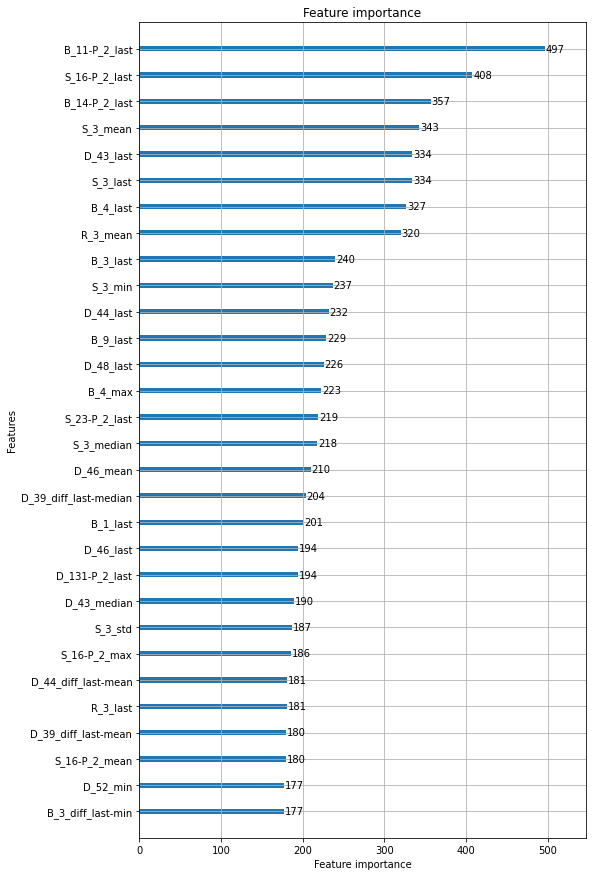

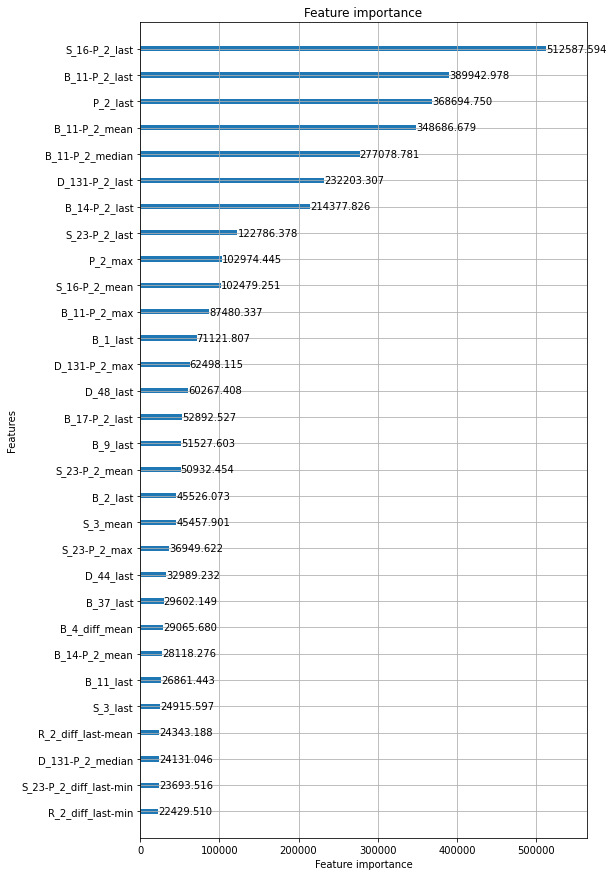

######################################## training model 5/5 ########################################


[50]	valid_0's amex_metric: 0.746469	valid_0's recall_at4: 0.596634	valid_0's norm_gini: 0.896305


[100]	valid_0's amex_metric: 0.758595	valid_0's recall_at4: 0.614054	valid_0's norm_gini: 0.903137


[150]	valid_0's amex_metric: 0.764192	valid_0's recall_at4: 0.62146	valid_0's norm_gini: 0.906924


[200]	valid_0's amex_metric: 0.769957	valid_0's recall_at4: 0.629329	valid_0's norm_gini: 0.910584


[250]	valid_0's amex_metric: 0.773225	valid_0's recall_at4: 0.633453	valid_0's norm_gini: 0.912998


[300]	valid_0's amex_metric: 0.776229	valid_0's recall_at4: 0.637913	valid_0's norm_gini: 0.914546


[350]	valid_0's amex_metric: 0.778462	valid_0's recall_at4: 0.641321	valid_0's norm_gini: 0.915603


[400]	valid_0's amex_metric: 0.779803	valid_0's recall_at4: 0.643131	valid_0's norm_gini: 0.916476


[450]	valid_0's amex_metric: 0.780913	valid_0's recall_at4: 0.64473	valid_0's norm_gini: 0.917097


[500]	valid_0's amex_metric: 0.781874	valid_0's recall_at4: 0.646118	valid_0's norm_gini: 0.917631


[550]	valid_0's amex_metric: 0.782469	valid_0's recall_at4: 0.646918	valid_0's norm_gini: 0.91802


[600]	valid_0's amex_metric: 0.783052	valid_0's recall_at4: 0.647801	valid_0's norm_gini: 0.918303


[650]	valid_0's amex_metric: 0.783353	valid_0's recall_at4: 0.648096	valid_0's norm_gini: 0.918609


[700]	valid_0's amex_metric: 0.783702	valid_0's recall_at4: 0.648517	valid_0's norm_gini: 0.918887


[750]	valid_0's amex_metric: 0.784039	valid_0's recall_at4: 0.64898	valid_0's norm_gini: 0.919099


[800]	valid_0's amex_metric: 0.784338	valid_0's recall_at4: 0.6494	valid_0's norm_gini: 0.919276


[850]	valid_0's amex_metric: 0.785047	valid_0's recall_at4: 0.650536	valid_0's norm_gini: 0.919557


[900]	valid_0's amex_metric: 0.785193	valid_0's recall_at4: 0.650705	valid_0's norm_gini: 0.919682


[950]	valid_0's amex_metric: 0.785944	valid_0's recall_at4: 0.652009	valid_0's norm_gini: 0.919878


[1000]	valid_0's amex_metric: 0.786228	valid_0's recall_at4: 0.652388	valid_0's norm_gini: 0.920068


[1050]	valid_0's amex_metric: 0.786396	valid_0's recall_at4: 0.652514	valid_0's norm_gini: 0.920278


[1100]	valid_0's amex_metric: 0.786428	valid_0's recall_at4: 0.652388	valid_0's norm_gini: 0.920469


[1150]	valid_0's amex_metric: 0.787158	valid_0's recall_at4: 0.653735	valid_0's norm_gini: 0.920581


[1200]	valid_0's amex_metric: 0.787381	valid_0's recall_at4: 0.654071	valid_0's norm_gini: 0.92069


[1250]	valid_0's amex_metric: 0.787464	valid_0's recall_at4: 0.654155	valid_0's norm_gini: 0.920772


[1300]	valid_0's amex_metric: 0.78775	valid_0's recall_at4: 0.65466	valid_0's norm_gini: 0.92084


[1350]	valid_0's amex_metric: 0.787489	valid_0's recall_at4: 0.654071	valid_0's norm_gini: 0.920908


[1400]	valid_0's amex_metric: 0.78812	valid_0's recall_at4: 0.655249	valid_0's norm_gini: 0.920991


[1450]	valid_0's amex_metric: 0.788932	valid_0's recall_at4: 0.656764	valid_0's norm_gini: 0.9211


[1500]	valid_0's amex_metric: 0.78817	valid_0's recall_at4: 0.655165	valid_0's norm_gini: 0.921174


[1550]	valid_0's amex_metric: 0.7883	valid_0's recall_at4: 0.655333	valid_0's norm_gini: 0.921267


[1600]	valid_0's amex_metric: 0.788094	valid_0's recall_at4: 0.654871	valid_0's norm_gini: 0.921318


[1650]	valid_0's amex_metric: 0.788609	valid_0's recall_at4: 0.655838	valid_0's norm_gini: 0.92138


[1700]	valid_0's amex_metric: 0.788439	valid_0's recall_at4: 0.65546	valid_0's norm_gini: 0.921418


[1750]	valid_0's amex_metric: 0.7886	valid_0's recall_at4: 0.655754	valid_0's norm_gini: 0.921447


[1800]	valid_0's amex_metric: 0.788875	valid_0's recall_at4: 0.656259	valid_0's norm_gini: 0.921491


[1850]	valid_0's amex_metric: 0.788636	valid_0's recall_at4: 0.655754	valid_0's norm_gini: 0.921518


[1900]	valid_0's amex_metric: 0.788722	valid_0's recall_at4: 0.655923	valid_0's norm_gini: 0.921521


[1950]	valid_0's amex_metric: 0.788627	valid_0's recall_at4: 0.655712	valid_0's norm_gini: 0.921541


[2000]	valid_0's amex_metric: 0.788715	valid_0's recall_at4: 0.655838	valid_0's norm_gini: 0.921592


[2050]	valid_0's amex_metric: 0.78868	valid_0's recall_at4: 0.655754	valid_0's norm_gini: 0.921606


[2100]	valid_0's amex_metric: 0.789112	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.921628


[2150]	valid_0's amex_metric: 0.788975	valid_0's recall_at4: 0.656301	valid_0's norm_gini: 0.921649


[2200]	valid_0's amex_metric: 0.789344	valid_0's recall_at4: 0.657017	valid_0's norm_gini: 0.921672


[2250]	valid_0's amex_metric: 0.789558	valid_0's recall_at4: 0.657395	valid_0's norm_gini: 0.921721


[2300]	valid_0's amex_metric: 0.789419	valid_0's recall_at4: 0.657101	valid_0's norm_gini: 0.921737


[2350]	valid_0's amex_metric: 0.788703	valid_0's recall_at4: 0.65567	valid_0's norm_gini: 0.921736


[2400]	valid_0's amex_metric: 0.788547	valid_0's recall_at4: 0.655333	valid_0's norm_gini: 0.921761


[2450]	valid_0's amex_metric: 0.788534	valid_0's recall_at4: 0.655291	valid_0's norm_gini: 0.921777


[2500]	valid_0's amex_metric: 0.78841	valid_0's recall_at4: 0.655039	valid_0's norm_gini: 0.92178


[2550]	valid_0's amex_metric: 0.788057	valid_0's recall_at4: 0.654324	valid_0's norm_gini: 0.921791


[2600]	valid_0's amex_metric: 0.788359	valid_0's recall_at4: 0.654913	valid_0's norm_gini: 0.921805


[2650]	valid_0's amex_metric: 0.788311	valid_0's recall_at4: 0.654786	valid_0's norm_gini: 0.921835


[2700]	valid_0's amex_metric: 0.788538	valid_0's recall_at4: 0.655249	valid_0's norm_gini: 0.921827


[2750]	valid_0's amex_metric: 0.788539	valid_0's recall_at4: 0.655249	valid_0's norm_gini: 0.921829


[2800]	valid_0's amex_metric: 0.788663	valid_0's recall_at4: 0.655502	valid_0's norm_gini: 0.921825


[2850]	valid_0's amex_metric: 0.788793	valid_0's recall_at4: 0.655754	valid_0's norm_gini: 0.921833


[2900]	valid_0's amex_metric: 0.788429	valid_0's recall_at4: 0.654997	valid_0's norm_gini: 0.921862


[2950]	valid_0's amex_metric: 0.788408	valid_0's recall_at4: 0.654955	valid_0's norm_gini: 0.921861


[3000]	valid_0's amex_metric: 0.788622	valid_0's recall_at4: 0.655376	valid_0's norm_gini: 0.921869


[3050]	valid_0's amex_metric: 0.788984	valid_0's recall_at4: 0.656091	valid_0's norm_gini: 0.921878


[3100]	valid_0's amex_metric: 0.788837	valid_0's recall_at4: 0.655796	valid_0's norm_gini: 0.921877


[3150]	valid_0's amex_metric: 0.788907	valid_0's recall_at4: 0.655923	valid_0's norm_gini: 0.921892


[3200]	valid_0's amex_metric: 0.788942	valid_0's recall_at4: 0.655965	valid_0's norm_gini: 0.921918


[3250]	valid_0's amex_metric: 0.788823	valid_0's recall_at4: 0.655712	valid_0's norm_gini: 0.921933


[3300]	valid_0's amex_metric: 0.788838	valid_0's recall_at4: 0.655754	valid_0's norm_gini: 0.921923


[3350]	valid_0's amex_metric: 0.78943	valid_0's recall_at4: 0.656932	valid_0's norm_gini: 0.921928


[3400]	valid_0's amex_metric: 0.78921	valid_0's recall_at4: 0.656512	valid_0's norm_gini: 0.921909


[3450]	valid_0's amex_metric: 0.788914	valid_0's recall_at4: 0.655923	valid_0's norm_gini: 0.921905


[3500]	valid_0's amex_metric: 0.789049	valid_0's recall_at4: 0.656175	valid_0's norm_gini: 0.921922


[3550]	valid_0's amex_metric: 0.788949	valid_0's recall_at4: 0.655965	valid_0's norm_gini: 0.921933


[3600]	valid_0's amex_metric: 0.788995	valid_0's recall_at4: 0.656049	valid_0's norm_gini: 0.921941


[3650]	valid_0's amex_metric: 0.788801	valid_0's recall_at4: 0.65567	valid_0's norm_gini: 0.921933


[3700]	valid_0's amex_metric: 0.789031	valid_0's recall_at4: 0.656133	valid_0's norm_gini: 0.921929


[3750]	valid_0's amex_metric: 0.788631	valid_0's recall_at4: 0.655333	valid_0's norm_gini: 0.921928


[3800]	valid_0's amex_metric: 0.788562	valid_0's recall_at4: 0.655207	valid_0's norm_gini: 0.921917


[3850]	valid_0's amex_metric: 0.787933	valid_0's recall_at4: 0.653945	valid_0's norm_gini: 0.921922


[3900]	valid_0's amex_metric: 0.787794	valid_0's recall_at4: 0.65365	valid_0's norm_gini: 0.921937


[3950]	valid_0's amex_metric: 0.788423	valid_0's recall_at4: 0.654913	valid_0's norm_gini: 0.921933


[4000]	valid_0's amex_metric: 0.788736	valid_0's recall_at4: 0.655544	valid_0's norm_gini: 0.921929


[4050]	valid_0's amex_metric: 0.788316	valid_0's recall_at4: 0.654702	valid_0's norm_gini: 0.921929


[4100]	valid_0's amex_metric: 0.788148	valid_0's recall_at4: 0.654366	valid_0's norm_gini: 0.921931


[4150]	valid_0's amex_metric: 0.788579	valid_0's recall_at4: 0.655249	valid_0's norm_gini: 0.921909


[4200]	valid_0's amex_metric: 0.788682	valid_0's recall_at4: 0.65546	valid_0's norm_gini: 0.921905


[4250]	valid_0's amex_metric: 0.788677	valid_0's recall_at4: 0.65546	valid_0's norm_gini: 0.921895


[4300]	valid_0's amex_metric: 0.788586	valid_0's recall_at4: 0.655291	valid_0's norm_gini: 0.921881


[4350]	valid_0's amex_metric: 0.788368	valid_0's recall_at4: 0.654871	valid_0's norm_gini: 0.921866


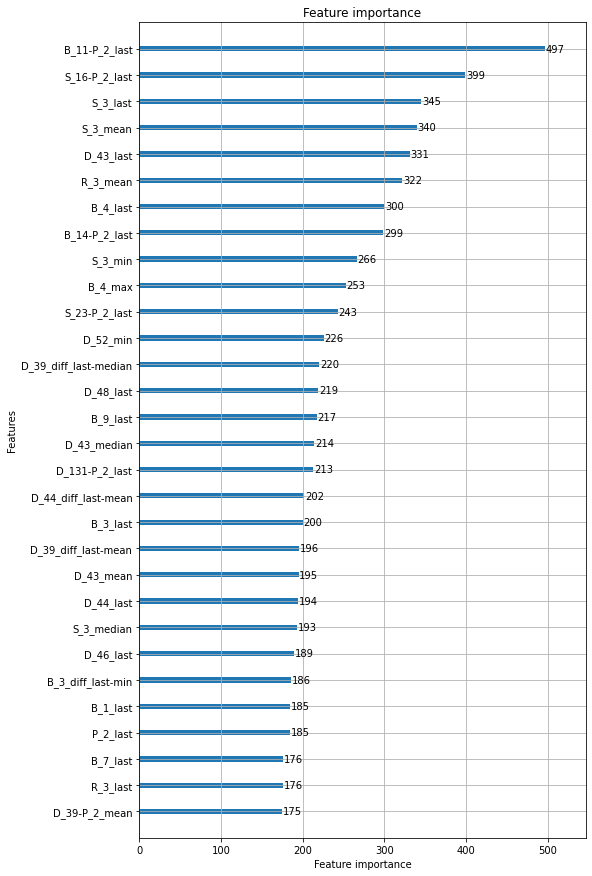

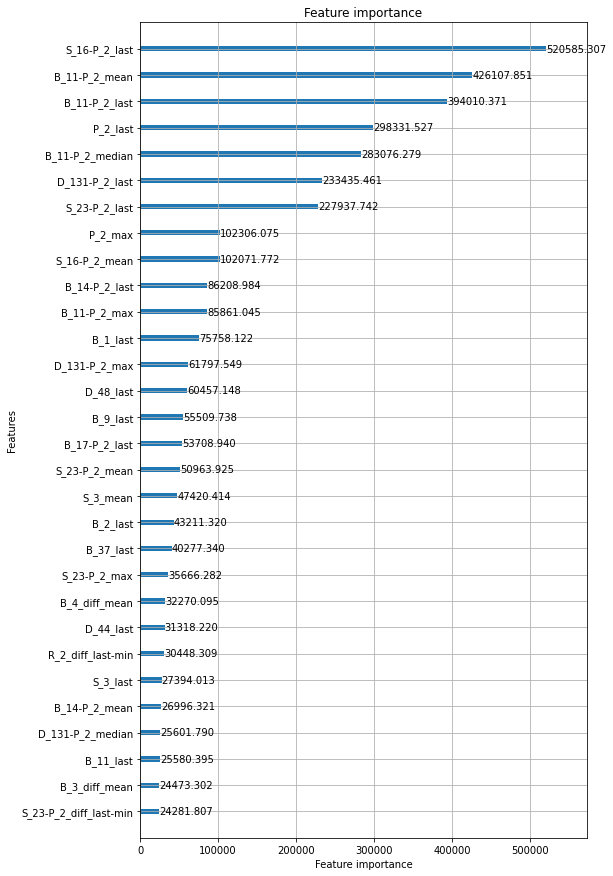

Training time: 39.603584404786424 min.
OOF recall_at4: 0.6595162756252735
OOF normalized_gini: 0.9228550644676049
OOF competition metric: 0.7911856700464392


CPU times: user 1d 5h 18min 54s, sys: 1min 29s, total: 1d 5h 20min 23s
Wall time: 1h 59min 15s


In [11]:
%%time 

all_models = list()
all_oof_dfs = list()

for repetition in range(N_REPEATS):
    print(f" repeated cross-validation step: {repetition+1}/{N_REPEATS} ".center(100, "#"))

    folds = pd.read_csv(f'../data/processed/cv{repetition}.csv', index_col="customer_ID")
    _train = pd.merge(train, folds, how="inner", left_index=True, right_index=True).reset_index(drop=True)
    
    tic = time.time()
    models,oof = train_models(_train)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
          
    # oof metrics
    print("OOF recall_at4:", compute_recall_at4(oof.target.values, oof.pred.values))
    print("OOF normalized_gini:", compute_normalized_gini(oof.target.values, oof.pred.values))
    print("OOF competition metric:", compute_amex_metric(oof.target.values, oof.pred.values))
    
    all_models.append(models)
    all_oof_dfs.append(oof)
    
    # save oof predictions
    oof.to_csv(OOF_PATH/f"oof-cv{repetition}.csv", index=False)
    # save models
    for fold,_model in enumerate(models):
        _model.save_model(ART_PATH/f"/model-cv{repetition}-fold{fold}.txt")
          
    del _train, folds; gc.collect()

In [12]:
results = list()

for oof in all_oof_dfs:  
    r = {
        "recall_at4": compute_recall_at4(oof.target.values, oof.pred.values),
        "gini": compute_normalized_gini(oof.target.values, oof.pred.values),
        "metric": compute_amex_metric(oof.target.values, oof.pred.values),
    }
    results.append(r)

results = pd.DataFrame(results)
display(results)

print("\nmean:")
display(results.mean(axis=0))

print("\nstd:")
display(results.std(axis=0))

,recall_at4,gini,metric
0,0.662041,0.922934,0.792487
1,0.660198,0.922936,0.791567
2,0.659516,0.922855,0.791186



mean:


recall_at4    0.660585
gini          0.922908
metric        0.791747
dtype: float64


std:


recall_at4    0.001306
gini          0.000046
metric        0.000669
dtype: float64

In [13]:
del train
gc.collect()

21

***
## make predictions and submit

In [14]:
def make_predictions(dataframe:pd.DataFrame, input_feats:list, models:list) -> np.array:
    preds = [model.predict(dataframe[input_feats]) for model in models]
    return np.mean(preds, axis=0)    

In [15]:
test = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/test.parquet")
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [16]:
%%time

all_preds = list()

for repetition in range(N_REPEATS):
    if "prediction" in sub.columns:
        sub.drop("prediction", axis=1, inplace=True)
    if "prediction" in test.columns:
        test.drop("prediction", axis=1, inplace=True)
        
    models = all_models[repetition]
    preds = make_predictions(test, input_feats, models)
    all_preds.append(preds)
       
    test["prediction"] = preds
    sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
    assert sub.prediction.isna().sum() == 0
    sub.to_csv(SUB_PATH/f"submission-cv{repetition}.csv", index=False)

CPU times: user 1h 42min 26s, sys: 35 s, total: 1h 43min 1s
Wall time: 6min 49s


In [17]:
%%time
# predict using all the trained models
if "prediction" in sub.columns:
    sub.drop("prediction", axis=1, inplace=True)
if "prediction" in test.columns:
    test.drop("prediction", axis=1, inplace=True)

test["prediction"] = np.mean(all_preds, axis=0)
sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
assert sub.prediction.isna().sum() == 0
sub.to_csv(SUB_PATH/f"submission-all.csv", index=False)

CPU times: user 3.36 s, sys: 594 ms, total: 3.95 s
Wall time: 3.95 s


***